# Exploratory Data Analysis
In this notebook, I will do basic EDA to get a preliminary understanding of raw data.<br>
For the records related to project description, progress, challenge and solution, please refer to [TBrain 2021 Esun AI](https://hackmd.io/_Vmlnai6QT2ou6er4Vbwww).

In [11]:
# Import packages
import os 
import sys
import gc
import csv
import warnings
from random import random, sample
import json
import pickle
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

module_path = os.path.abspath("..")
sys.path.append(module_path)
from metadata import *
from utils.fe import *

# Configurations
warnings.simplefilter('ignore')
pd.set_option('max_column',  300)
pd.set_option('max_row', 100)
%matplotlib inline

In [12]:
DATA_PATH_RAW = "../data/raw/raw_data.parquet"
DATA_PATH_TXN_AMTS = "../data/raw/raw_txn_amts.parquet"
DATA_PATH_APC = "../data/raw/raw_apc.parquet"

# 1. Basic Description
The most important thing to notice is the **limitation of RAM**, I shrink down the data size I read in. Then, I use this subset of the raw data to help me get a quick sense about what's the data appearance and behavior. 

In [7]:
# Utility function definitions
def proc_sub_df(buffer):
    '''Process sub dataframe, including NaN imputation and dtype conversion.
    
    Parameters:
        buffer: list, subset of the data samples
    
    Return:
        df_tmp: pd.DataFrame, processed dataframe
    '''
    df_tmp = pd.DataFrame(buffer, columns=cols)
    df_tmp.replace(to_replace={'shop_tag': {'other': '49'}}, value=None, inplace=True)
    df_tmp.replace(to_replace='', value=np.nan, inplace=True)
    df_tmp = df_tmp.astype(dtype='float32')
    
    return df_tmp

## a. Data Appearance
Understanding what the data looks like can help me gain a preliminary sense about how to do the further data processing and analysis.
### Analysis and Observation
1. Shape of raw data is (32975653, 53).
2. All the entries are with dtype `str`, which takes up to 49 bytes per string even if it's empty.

In [9]:
# Check shape of raw dataframe 
# with open("../data/raw/tbrain_cc_training_48tags_hash_final.csv", newline='') as f:
#     c = 0
#     for i, l in enumerate(csv.reader(f)):
#         c += 1
#     print(f"#Samples {c}")

In [ ]:
# Read a subset of whole raw data to check #columns
cols = []
buffer = []
# print(f"Ref count of list buffer is {sys.getrefcount(buffer)}")
with open("../data/raw/tbrain_cc_training_48tags_hash_final.csv", newline='') as f: 
    for i, l in enumerate(csv.reader(f)):
        if i == 0:
            cols = l
            continue
        if i == 10e4:
            break
        buffer.append(l)
#         print(f"Ref count of list buffer is {sys.getrefcount(buffer)}")
df = pd.DataFrame(buffer, columns=cols) 
print(f"#Columns (PK + features) {len(cols)}")

In [ ]:
# Check entry size
print("=====Entry size (take random chid and txn_amt)=====")
print(f"One customer identifier takes {sys.getsizeof(df['chid'][0])} bytes.")
print(f"One transaction amount takes {sys.getsizeof(df['txn_amt'][100])} bytes.")

## b. Data Types
To convert each column to suitable data type to **reduce memory loading**, I perform the following processing and analysis tricks.
### Analysis and Observation
1. By checking upper and lower bounds of each column, I select the best dtype for each column manually. For more detailed information about column dtypes, please refer to [feat_bounds.json](../data/raw/feat_bounds.json).
2. Dtype conversion faces a challenge when there's any NaN in the column, which is represented as **empty string ""** in this case. Hence, I check NaN columns first, then impute them with proper values in advanece to avoid the conversion error (*i.e.*, when there's NaN in column, it's impossible to convert it to dtypy like `np.int8`.).

In [ ]:
# Check upper and lower bounds of each column, 
# helping determine dtypes to convert to
def update_bounds(buffer):
    '''Update lower and upper bounds of each feature.
    
    Parameters:
        buffer: list, subset of the data samples
    
    Return:
        None
    '''
    df_tmp = proc_sub_df(buffer)
    min_max_tmp = df_tmp.describe().loc[['min', 'max'], :]
    for col in min_max_tmp:
        if min_max_tmp[col]['min'] < bound_map[col]['min']:
            bound_map[col]['min'] = min_max_tmp[col]['min']
        if min_max_tmp[col]['max'] > bound_map[col]['max']:
            bound_map[col]['max'] = min_max_tmp[col]['max']
        
cols = []
buffer = []
bound_map = {k: {'min': 10e18, 'max': 10e-18} for k in df.columns}
with open("../data/raw/tbrain_cc_training_48tags_hash_final.csv", newline='') as f: 
    for i, l in enumerate(csv.reader(f)):
        if i == 0:
            continue
        buffer.append(l)
        if i % 10e4 == 0 or i == N_LINES-1:
            # Update boundaries every 10^5 samples
            print(f"Start updating boundaries | round{i//10e4}...")
            update_bounds(buffer)
            del buffer 
            buffer = []
            
with open("../data/raw/feat_bounds.json", 'w') as f:
    json.dump(bound_map, f)

In [ ]:
# Check if there's NaN value in each column
def check_nan(buffer):
    '''Check if there's NaN value (empty string) within each column.
    
    Parameters:
        buffer: list, subset of the data samples
        
    Return:
        sub_cols_with_nan: list, column names of columns with NaN values
    '''
    df_tmp = proc_sub_df(buffer)
    nans = pd.isna(df_tmp).any()
    sub_cols_with_nan = df_tmp.columns[nans].tolist()
    
    return sub_cols_with_nan
    
buffer = []
cols_with_nan = []
with open("../data/raw/tbrain_cc_training_48tags_hash_final.csv", newline='') as f: 
    for i, l in enumerate(csv.reader(f)):
        if i == 0:
            continue
        buffer.append(l)
        if i % 10e4 == 0 or i == N_LINES-1:
            # Check NaN every 10^5 samples
            print(f"Start check NaN | round{i//10e4}...")
            cols_with_nan += check_nan(buffer)
            del buffer 
            buffer = []
print(f"Columns with NaN values (empty strings): {set(cols_with_nan)}.")

In [ ]:
# Generate complete raw data
# df = pd.DataFrame()
# for file in tqdm(sorted(os.listdir("../data/partitioned/"))):
#     df_ = pd.read_parquet(os.path.join("../data/partitioned/", file))
#     df = pd.concat([df, df_], ignore_index=True)
#     del df_
# df.to_parquet("../data/raw/raw_data.parquet", index=False)

# 2. Advanced Data Analysis
After obtaining the complete raw data and having a sence about what data looks like, I need to do advanced data analysis, including **univariate** data analysis, **multivariate** interaction, etc. At the same time, I want to find out if there's any sample containing unreasonable value in each column.

## a. Univariate Analysis
In the first step, I want to observe how each variable behaves independently; that is, I'll use a single **bar chart** or **histogram** to see the discrete or continuos value distribution.
### Analysis and Observation
1. The interpretation of value counts and distribution of variable is recorded [here](https://hackmd.io/vIC1fF5uSnSnGYrv2GBUsA).

<div class='alert alert-warning'>
    <p>
        <strong>(Solved)</strong>2. Analyzing upper and lower bounds of each continuous variable helps us find out an unreasonable issue. That is, all features related to transaction count have negative values located in some samples.
     </p>
</div>

3. The interpretation of the boxplots is recorded [here](https://hackmd.io/vIC1fF5uSnSnGYrv2GBUsA), same as above.
4. Nearly 60% of **continuous** features have zero ratios greater than 0.9, and 80% greater than 0.8. 
5. No NaN values are left to be processed.
6. Observing featmaps with two axes (both spatial and temporal), I simply conclude that temporal patterns are hard to find by merely visualization. Furthermore, most clients seem to consume the specific subsets of `shop_tag`s.
7. Number of `shop_tag`s each client has consumed follows **curved power law**.
8. Average number of `shop_tag`s each client consumed per month follows **power law**, indicating that the majority of clients focus on small subsets of `shop_tag`s.
9. Quantile report shows that average number of `shop_tag`s each client consumed per month tends to be a small number, and there's the special case of only 1 `shop_tag`. Also, 98% of clients have this value less than or equal to 10 `shop_tag`s.
10. Nealy 60% of clients have their first transaction at month 1. And there are more and more clients joining in.
11. `slam` is a dynamic feature.
12. The first level of balancing (*i.e.*, `illeg` versus `leg`) shows that the `leg` samples are generally more than `illeg` ones.
13. The second level of balancing (*i.e.*, `shop_tag` balance in `leg` only) shows that some of the `shop_tag`s are dominant in `#samples`.
14. Distribution of #`shop_tag`s each client consumes in each month seems **consistent**. And, they all follow **power law**, indicating most of the clients focus on small subsets of `shop_tag`s.

In [3]:
# Prepare data to analyze 
df = pd.read_parquet(DATA_PATH_RAW)
print(f"Shape of raw data: {df.shape}")
N_SAMPLES = len(df)

# Display all the columns
display(df.columns)

# Display basic stats
# df.describe()

Shape of raw data: (32975653, 53)


Index(['dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt', 'domestic_offline_cnt',
       'domestic_online_cnt', 'overseas_offline_cnt', 'overseas_online_cnt',
       'domestic_offline_amt_pct', 'domestic_online_amt_pct',
       'overseas_offline_amt_pct', 'overseas_online_amt_pct', 'card_1_txn_cnt',
       'card_2_txn_cnt', 'card_3_txn_cnt', 'card_4_txn_cnt', 'card_5_txn_cnt',
       'card_6_txn_cnt', 'card_7_txn_cnt', 'card_8_txn_cnt', 'card_9_txn_cnt',
       'card_10_txn_cnt', 'card_11_txn_cnt', 'card_12_txn_cnt',
       'card_13_txn_cnt', 'card_14_txn_cnt', 'card_other_txn_cnt',
       'card_1_txn_amt_pct', 'card_2_txn_amt_pct', 'card_3_txn_amt_pct',
       'card_4_txn_amt_pct', 'card_5_txn_amt_pct', 'card_6_txn_amt_pct',
       'card_7_txn_amt_pct', 'card_8_txn_amt_pct', 'card_9_txn_amt_pct',
       'card_10_txn_amt_pct', 'card_11_txn_amt_pct', 'card_12_txn_amt_pct',
       'card_13_txn_amt_pct', 'card_14_txn_amt_pct', 'card_other_txn_amt_pct',
       'masts', 'educd', 'trdtp', 'naty

In [ ]:
def plot_bar(cols_discrete):
    '''Plot bar chart to display the count of each discrete value.
    
    Parameters:
        cols_discrete: list, columns with discrete values
        
    Return:
        None
    '''
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(14, 7))    
    for i, col_name in enumerate(cols_discrete):
        val_cnts = df[col_name].value_counts()
        val_cnts.sort_index(axis=0, ascending=True, inplace=True)
        axs[i//4, i%4].bar(x=list(val_cnts.index), height=list(val_cnts.values))
        axs[i//4, i%4].set_title(f"Value Counts of Column {col_name}\nwith {len(val_cnts)} Unique Values")
        axs[i//4, i%4].set_xlabel(f"{col_name}")
        axs[i//4, i%4].set_ylabel("Value Count")
        del val_cnts
    plt.tight_layout()
    
def plot_hist(cols_cont):
    '''Plot histogram to display the distribution of each continuous value.
    
    Parameters:
        cols_cont: list, columns with continuous values
        
    Return:
        None
    '''
    n_cols = 3
    fig, axs = plt.subplots(nrows=14, ncols=n_cols, figsize=(35, 85))
    for i, col_name in enumerate(cols_cont):
        axs[i//n_cols, i%n_cols].hist(x=df[col_name], bins=250)
        axs[i//n_cols, i%n_cols].set_title(f"Distribution of Column {col_name}")
        axs[i//n_cols, i%n_cols].set_xlabel(f"{col_name}")
        axs[i//n_cols, i%n_cols].set_ylabel("Binned Value Count")
    
    plt.tight_layout()

DISCRETE_VARS = [col for col in df.columns if not (col.endswith('amt') or col.endswith('cnt') or col.endswith('pct') or col == 'slam')]
CONT_VARS = [col for col in df.columns if col not in DISCRETE_VARS+['chid']]

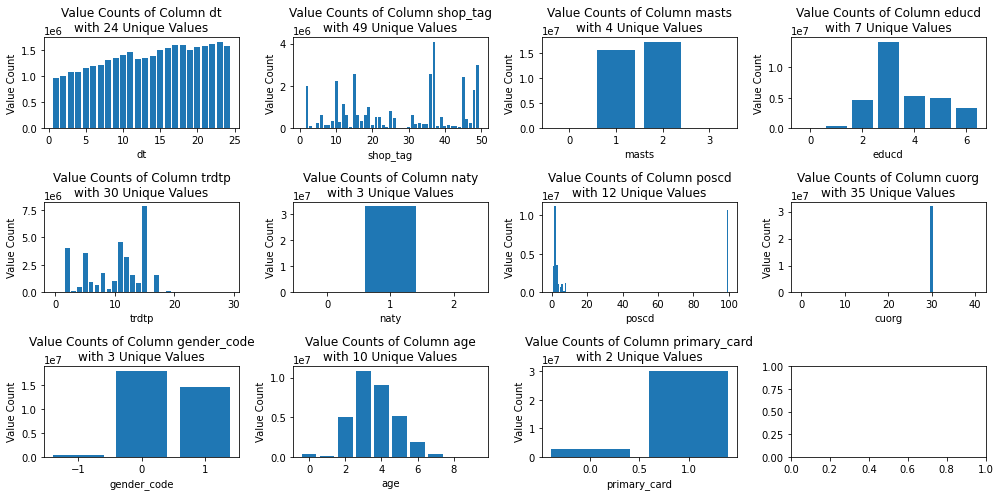

In [8]:
# 1.a Display univariate value counts for discrete variables using bar chart
DISCRETE_VARS.remove('chid')   # #Clients is too large to fit in a plot (0.5M)
plot_bar(DISCRETE_VARS)

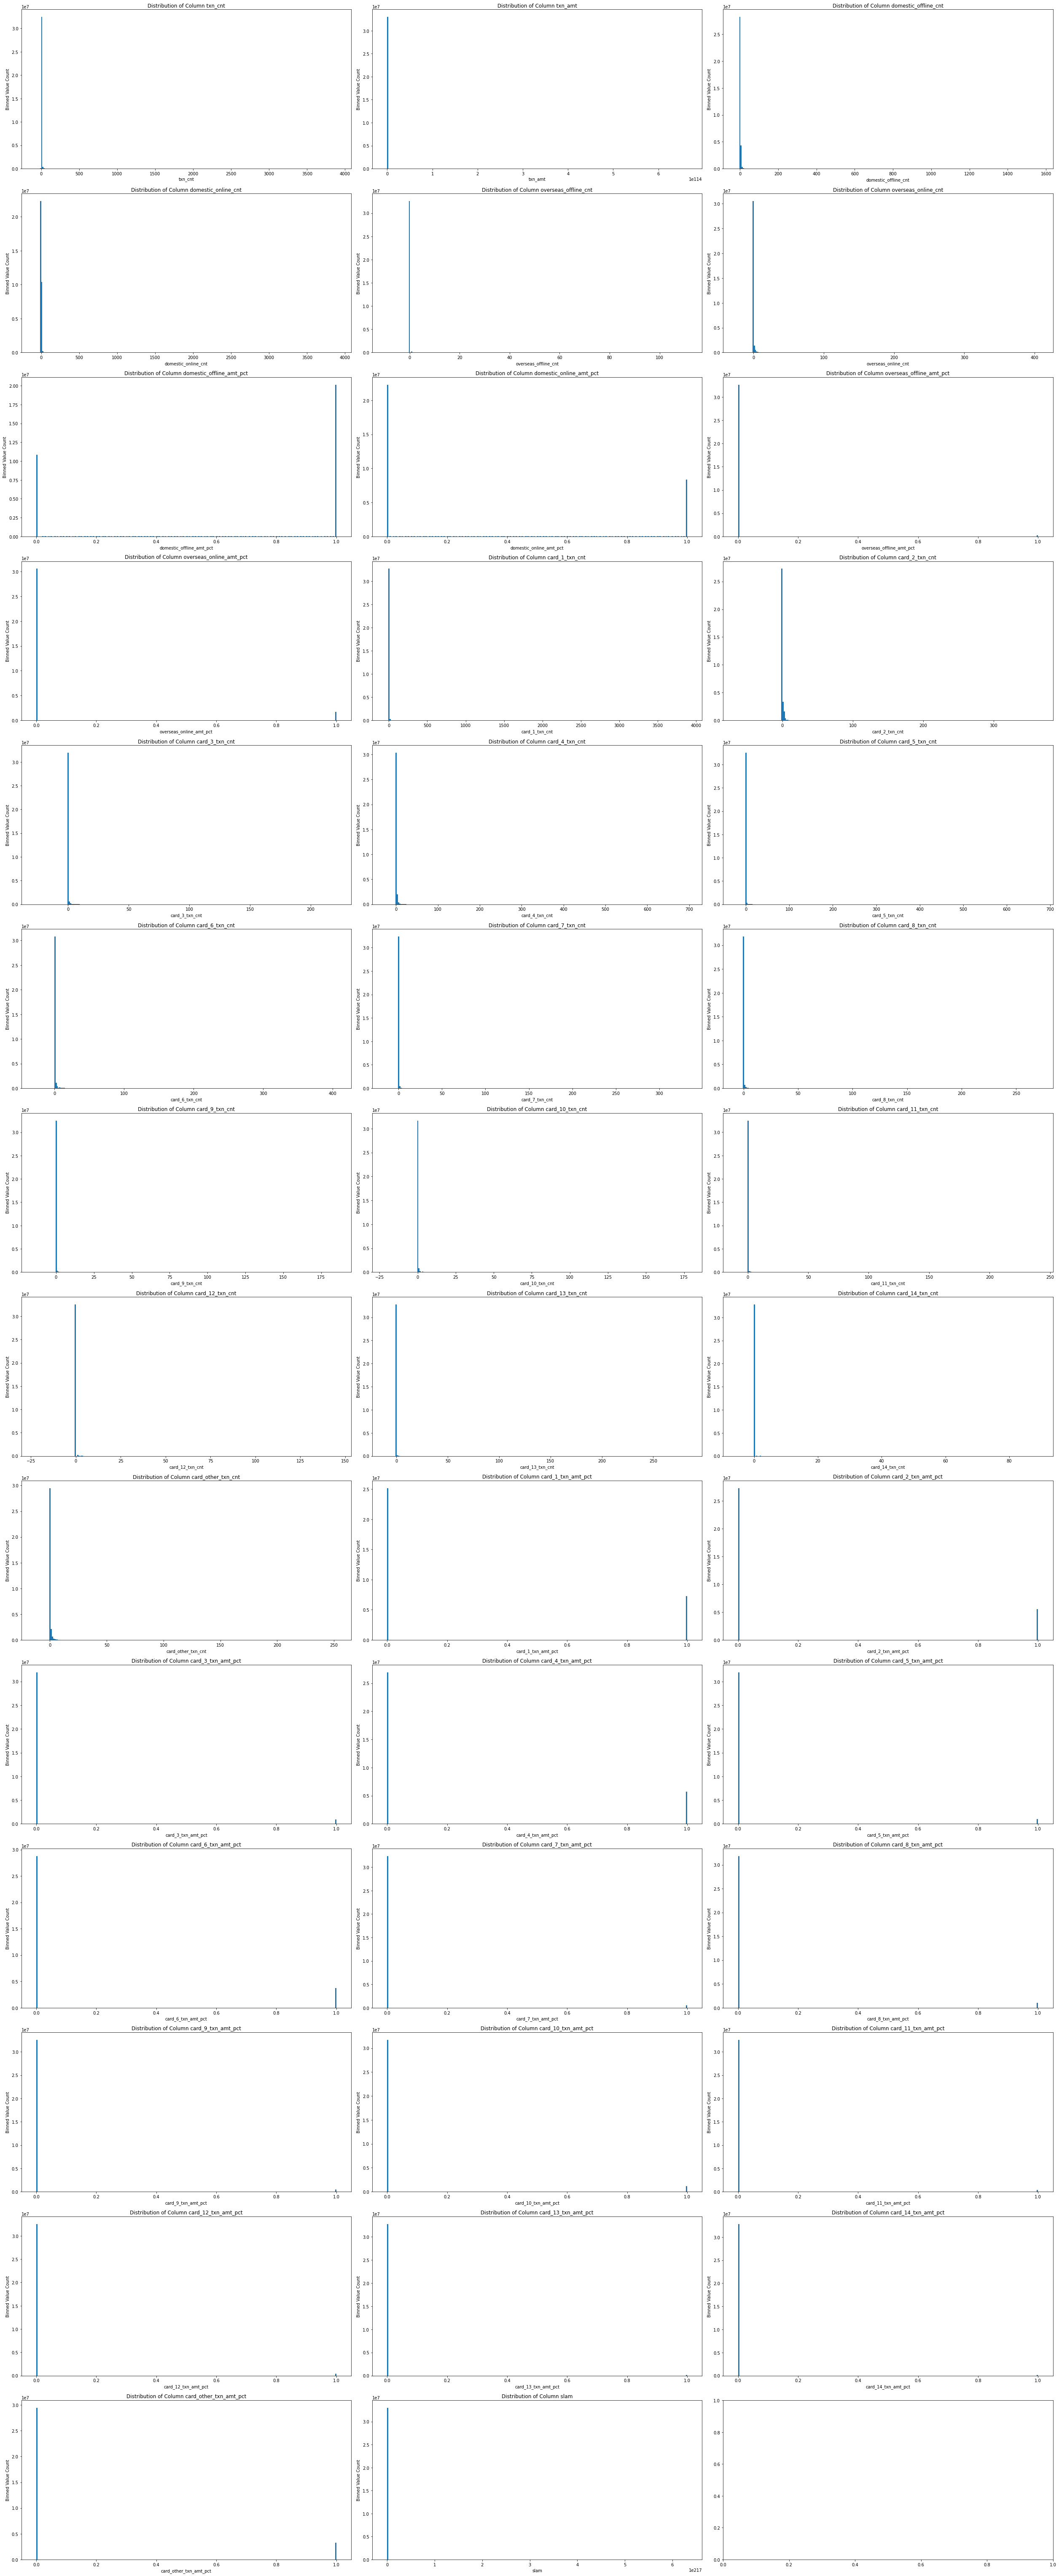

In [9]:
# 1.b Display univariate distribution for continuous variables using histogram
plot_hist(CONT_VARS)

In [8]:
# 2. Show upper and lower bounds of each continuous variable
with open("../data/raw/feat_bounds.json", "r") as f:
    feat_bounds = json.load(f)
for f, bounds in feat_bounds.items():
    if f in CONT_VARS:
        n_neg_vals = np.sum(df[f] < 0)
        alert_prefix = '(V) ' if n_neg_vals > 0 else ''
        print(f"{alert_prefix}{f} | Upper bound {bounds['max']} | Lower bound {bounds['min']}" 
              f"| Samples with neg values {n_neg_vals}")

(V) txn_cnt | Upper bound 3884.0 | Lower bound -63.0| Samples with neg values 4327
txn_amt | Upper bound inf | Lower bound 22.370851516723633| Samples with neg values 0
(V) domestic_offline_cnt | Upper bound 1558.0 | Lower bound -10.0| Samples with neg values 1054
(V) domestic_online_cnt | Upper bound 3884.0 | Lower bound -63.0| Samples with neg values 2758
(V) overseas_offline_cnt | Upper bound 111.0 | Lower bound -9.0| Samples with neg values 200
(V) overseas_online_cnt | Upper bound 405.0 | Lower bound -22.0| Samples with neg values 1427
domestic_offline_amt_pct | Upper bound 1.0 | Lower bound 0.0| Samples with neg values 0
domestic_online_amt_pct | Upper bound 1.0 | Lower bound 0.0| Samples with neg values 0
overseas_offline_amt_pct | Upper bound 1.0 | Lower bound 0.0| Samples with neg values 0
overseas_online_amt_pct | Upper bound 1.0 | Lower bound 0.0| Samples with neg values 0
(V) card_1_txn_cnt | Upper bound 3884.0 | Lower bound -22.0| Samples with neg values 1011
(V) card_2_tx

In [ ]:
def plot_box(title, props):
    '''Plot box plot for each continuous value to observe detailed
    distribution properties (e.g., mean, 1st quarter, etc)
    
    Parameters:
        title: str, title of the plot
        props: dict, properties to apply on the plot, including  
            cols: list, names of features to plot
            show_mean: bool, whether to show the mean
            show_fliers: bool, whether to show outliers
            
    Return:
        None
    '''
    fig, ax = plt.subplots(figsize=(14, 7))
    cols = props['cols']
    ax.boxplot(df[cols], notch=True, showmeans=props['show_mean'], showfliers=props['show_fliers'])
    ax.set_xticks(ticks=range(1, len(cols)+1))
    ax.set_xticklabels(labels=cols, rotation=90)
    ax.set_xlabel("Feature Name")
    ax.set_ylabel("Value")
    ax.set_title(title)
    plt.show()

In [ ]:
# 3. Display boxplots to interpret value distribution from different perspective
cont_var_groups = {
    'Transaction Count': {
        'cols': [col for col in COLS if col.endswith('cnt')],
        'show_mean': True, 'show_fliers': True
    },
    'Transaction Amount Percentage': {
        'cols': [col for col in COLS if col.endswith('amt_pct')],
        'show_mean': True, 'show_fliers': True
    }, 
    'Transaction Amount and Slam': {
        'cols': ['txn_amt', 'slam'],
        'show_mean': False, 'show_fliers': True
    }
}
for title, props in cont_var_groups.items():
    plot_box(title, props)

In [6]:
# 4. Show ratios of zero values of continuous variables
df_zero_ratios = pd.DataFrame(columns=['feature', 'zero_ratio'])
for col in CONT_VARS:
    series = df[col]
    zero_ratio = { 
        'feature': col,
        'zero_ratio': (series == 0).sum() / N_SAMPLES
    }
    df_zero_ratios = df_zero_ratios.append(zero_ratio, ignore_index=True)
    del series
df_zero_ratios.sort_values(by=['zero_ratio'], ascending=False, inplace=True)
df_zero_ratios.T

23                   38               22  \
feature     card_14_txn_cnt  card_14_txn_amt_pct  card_13_txn_cnt   
zero_ratio          0.99529             0.995281          0.99438   

                             37                    4   \
feature     card_13_txn_amt_pct  overseas_offline_cnt   
zero_ratio             0.994359                0.9892   

                                  8                21                   36  \
feature     overseas_offline_amt_pct  card_12_txn_cnt  card_12_txn_amt_pct   
zero_ratio                  0.989199         0.986759             0.986731   

                        18                  33               20  \
feature     card_9_txn_cnt  card_9_txn_amt_pct  card_11_txn_cnt   
zero_ratio        0.986271            0.986231         0.985949   

                             35              16                  31  \
feature     card_11_txn_amt_pct  card_7_txn_cnt  card_7_txn_amt_pct   
zero_ratio             0.985931        0.981017            0.980985   

                        14                  29              12  \
feature     card_5_txn_cnt  card_5_txn_amt_pct  card_3_txn_cnt   
zero_ratio        0.969041            0.968985        0.968922   

                            27              17                  32  \
feature     card_3_txn_amt_pct  card_8_txn_cnt  card_8_txn_amt_pct   
zero_ratio            0.968843        0.964519            0.964479   

                         19                   34                       9   \
feature     card_10_txn_cnt  card_10_txn_amt_pct  overseas_online_amt_pct   
zero_ratio         0.960937             0.960882                 0.926737   

                             5                   24                      39  \
feature     overseas_online_cnt  card_other_txn_cnt  card_other_txn_amt_pct   
zero_ratio             0.926725            0.892597                 0.89242   

                        15                  30              11  \
feature     card_6_txn_cnt  card_6_txn_amt_pct  card_2_txn_cnt   
zero_ratio        0.872408            0.872008        0.827566   

                            26              13                  28  \
feature     card_2_txn_amt_pct  card_4_txn_cnt  card_4_txn_amt_pct   
zero_ratio             0.82718        0.817083            0.816714   

                        10                  25                   3   \
feature     card_1_txn_cnt  card_1_txn_amt_pct  domestic_online_cnt   
zero_ratio        0.762479            0.762092             0.676799   

                                 7                     2   \
feature     domestic_online_amt_pct  domestic_offline_cnt   
zero_ratio                 0.675423              0.328627   

                                  6         40        0        1   
feature     domestic_offline_amt_pct      slam   txn_cnt  txn_amt  
zero_ratio                  0.327867  0.053067  0.002242      0.0

In [15]:
# 5. Check if there's any column with NaN value left
assert not df.isna().any().any()

In [3]:
df = pd.read_parquet(DATA_PATH_RAW, columns=['dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt'])
df.head()

dt      chid  shop_tag  txn_cnt       txn_amt
0   1  10321418        45        3   3891.965283
1   1  10414574        15        2  10616.561549
2   1  10134567        48        2  23527.655416
3   1  10001003        48        9  17751.558260
4   1  10267183         2        1  21701.307598

In [3]:
def plot_dt_shop_tag_hmap(chid, feat):
    '''Plot heatmap indicating the intensity of feature values based on
    each (`dt`, `shop_tag`) entry.
    
    Parameters:
        chid: int, client identifier
        feat: str, name of feature to plot 
    
    Return:
        None
    '''
    df_ = df[df['chid'] == chid].loc[:, ['dt', 'shop_tag', feat]]
    feat_vals = np.zeros((len(SHOP_TAGS), len(DTS)))
    for i, r in df_.iterrows():
        shop_tag = int(r['shop_tag'])
        dt = int(r['dt'])
        feat_vals[-shop_tag][dt-1] = r[feat].round(1)
        
    fig, ax = plt.subplots(figsize=(14, 28))
    hmap = ax.imshow(feat_vals)
    ax.set_xticks(np.arange(len(DTS)))
    ax.set_yticks(np.arange(len(SHOP_TAGS)))
    ax.set_xticklabels(DTS, rotation=45)
    ax.set_yticklabels(SHOP_TAGS)
    for i in range(len(SHOP_TAGS)):
        for j in range(len(DTS)):
            text = ax.text(j, len(SHOP_TAGS)-1-i, feat_vals[len(SHOP_TAGS)-1-i][j],
                           ha="center", va="center", color="w")
    ax.set_title(f"Feature Hmap of Client {chid}")
    fig.tight_layout()
    plt.show()

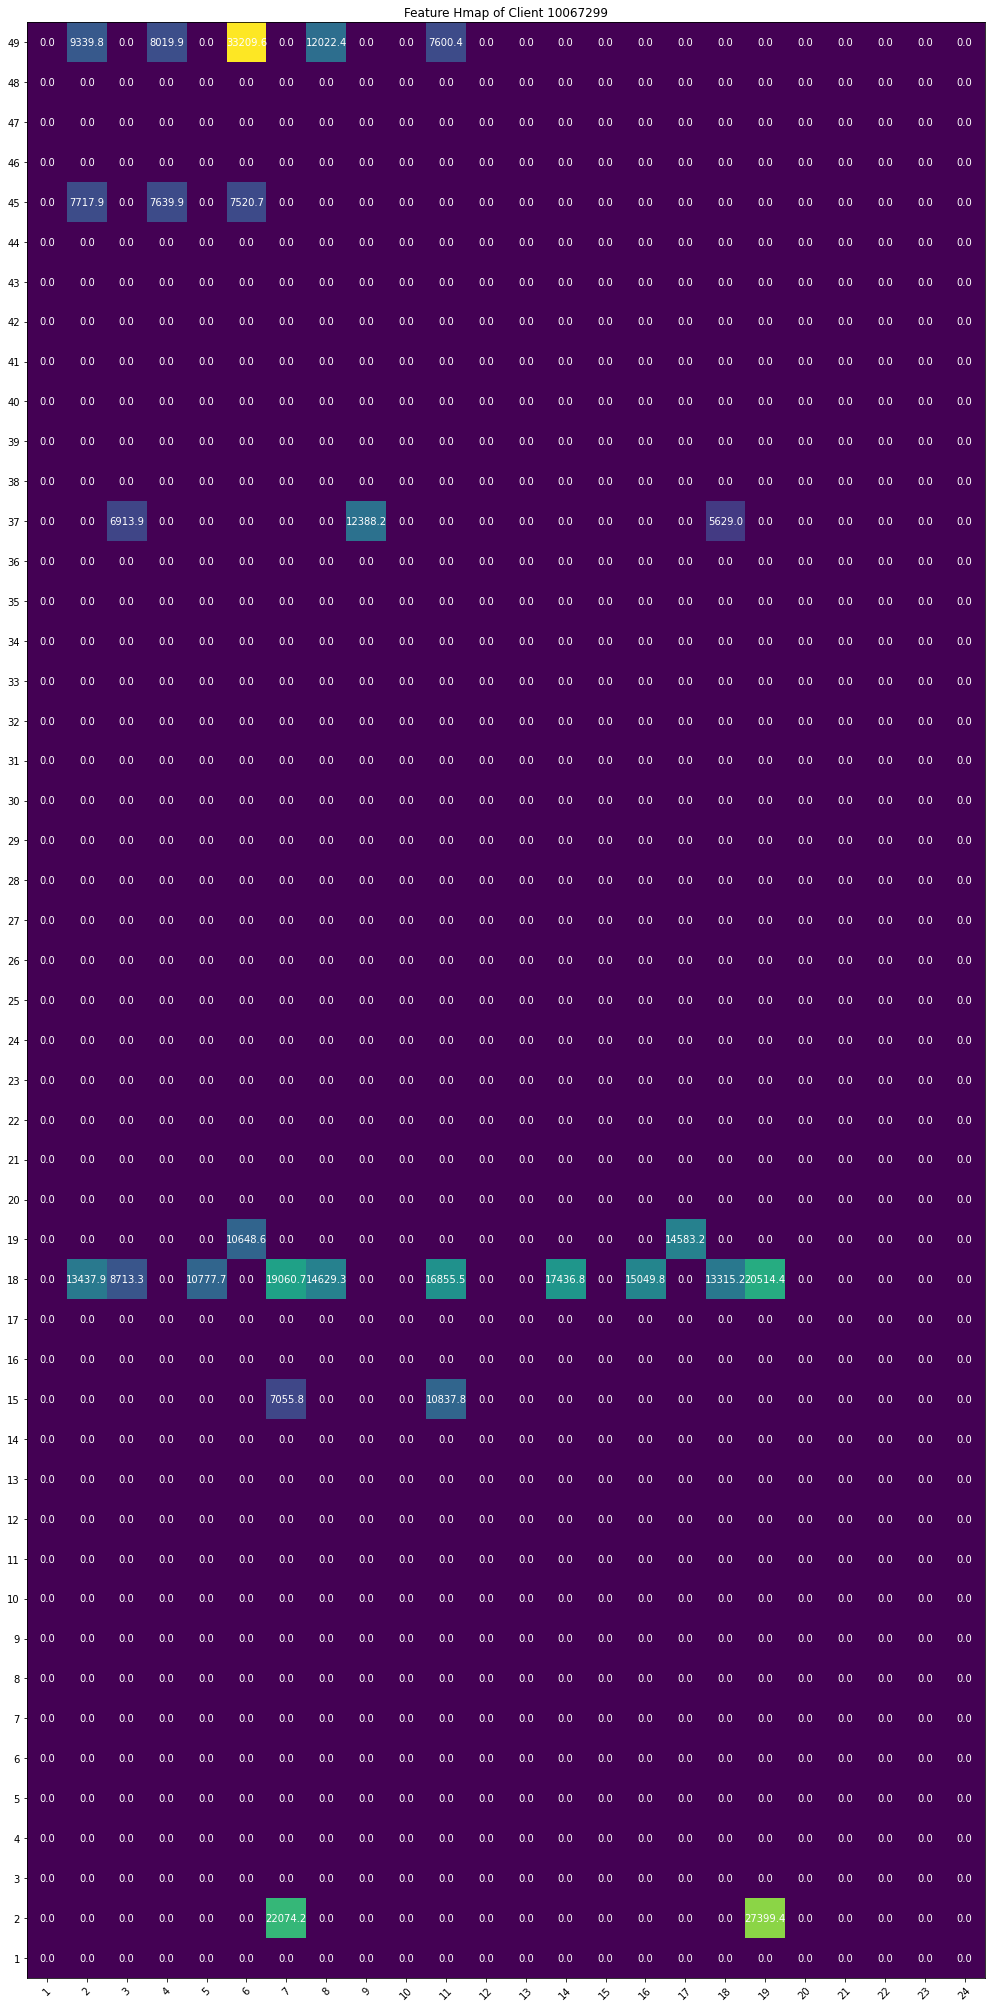

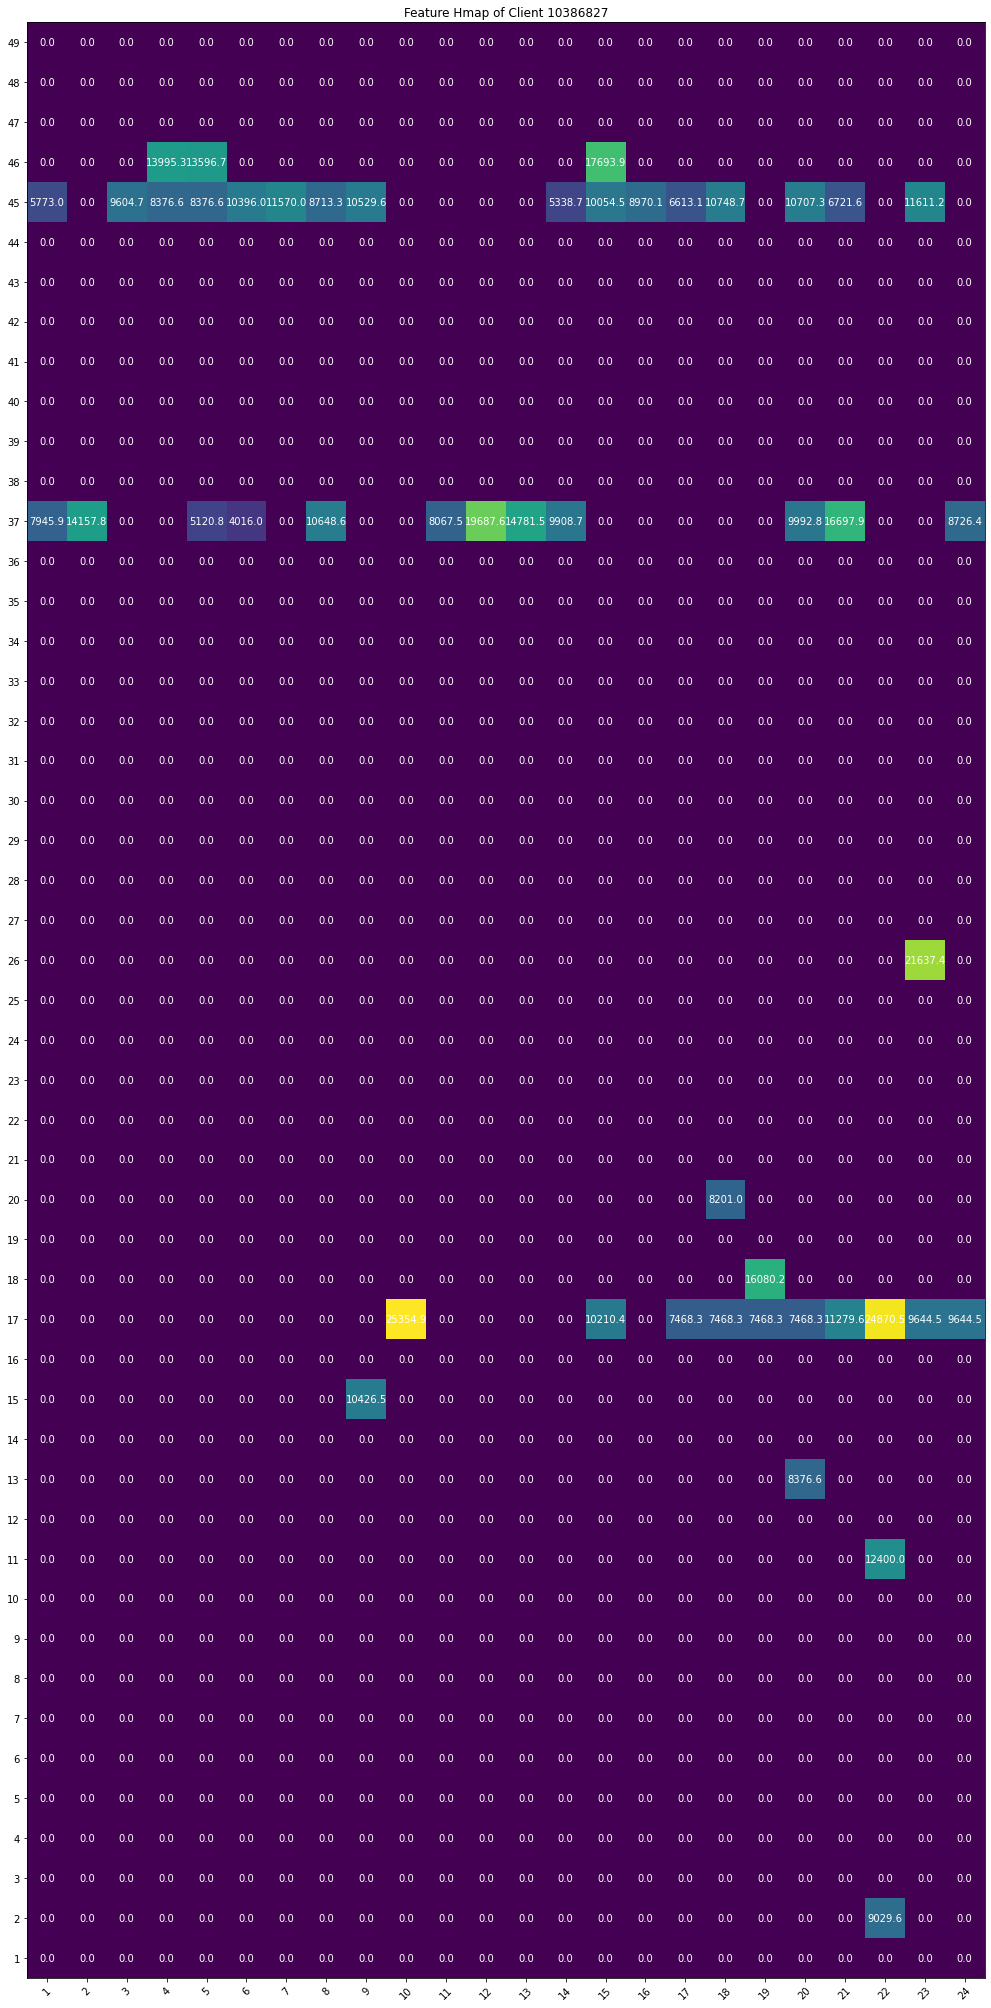

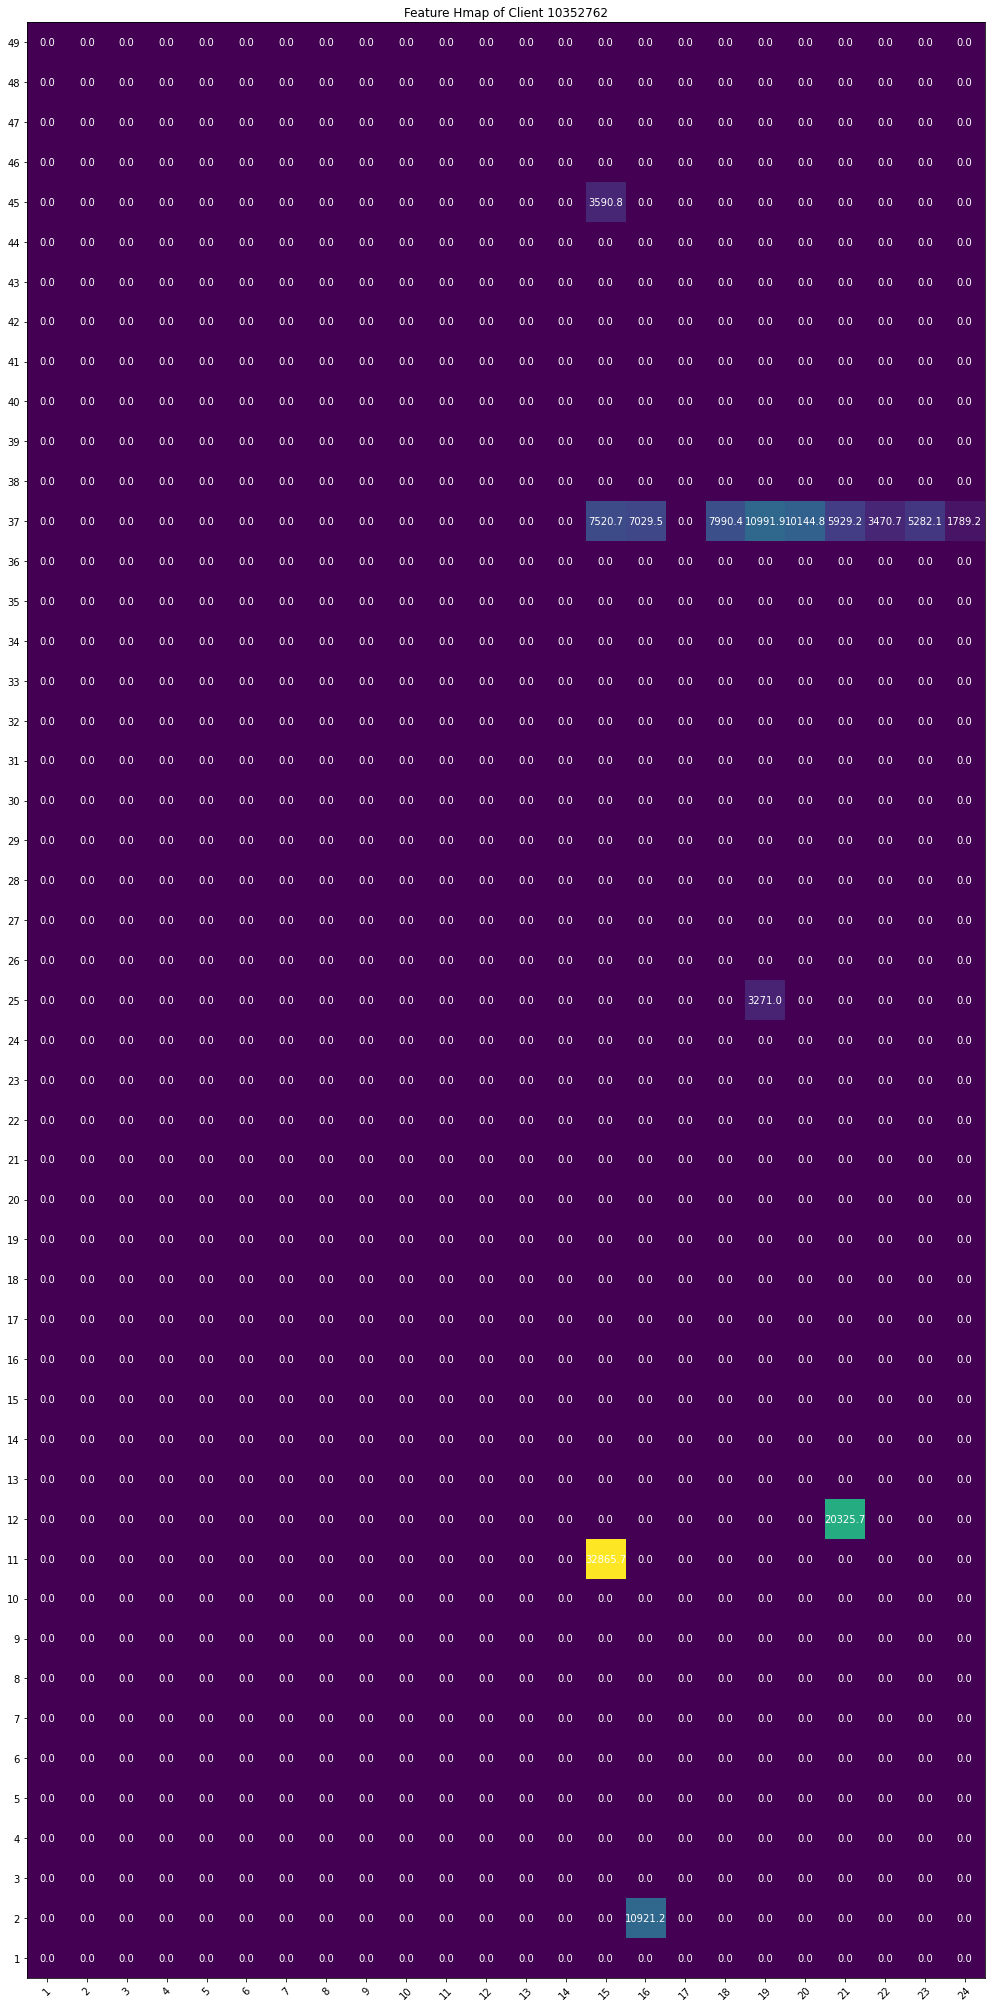

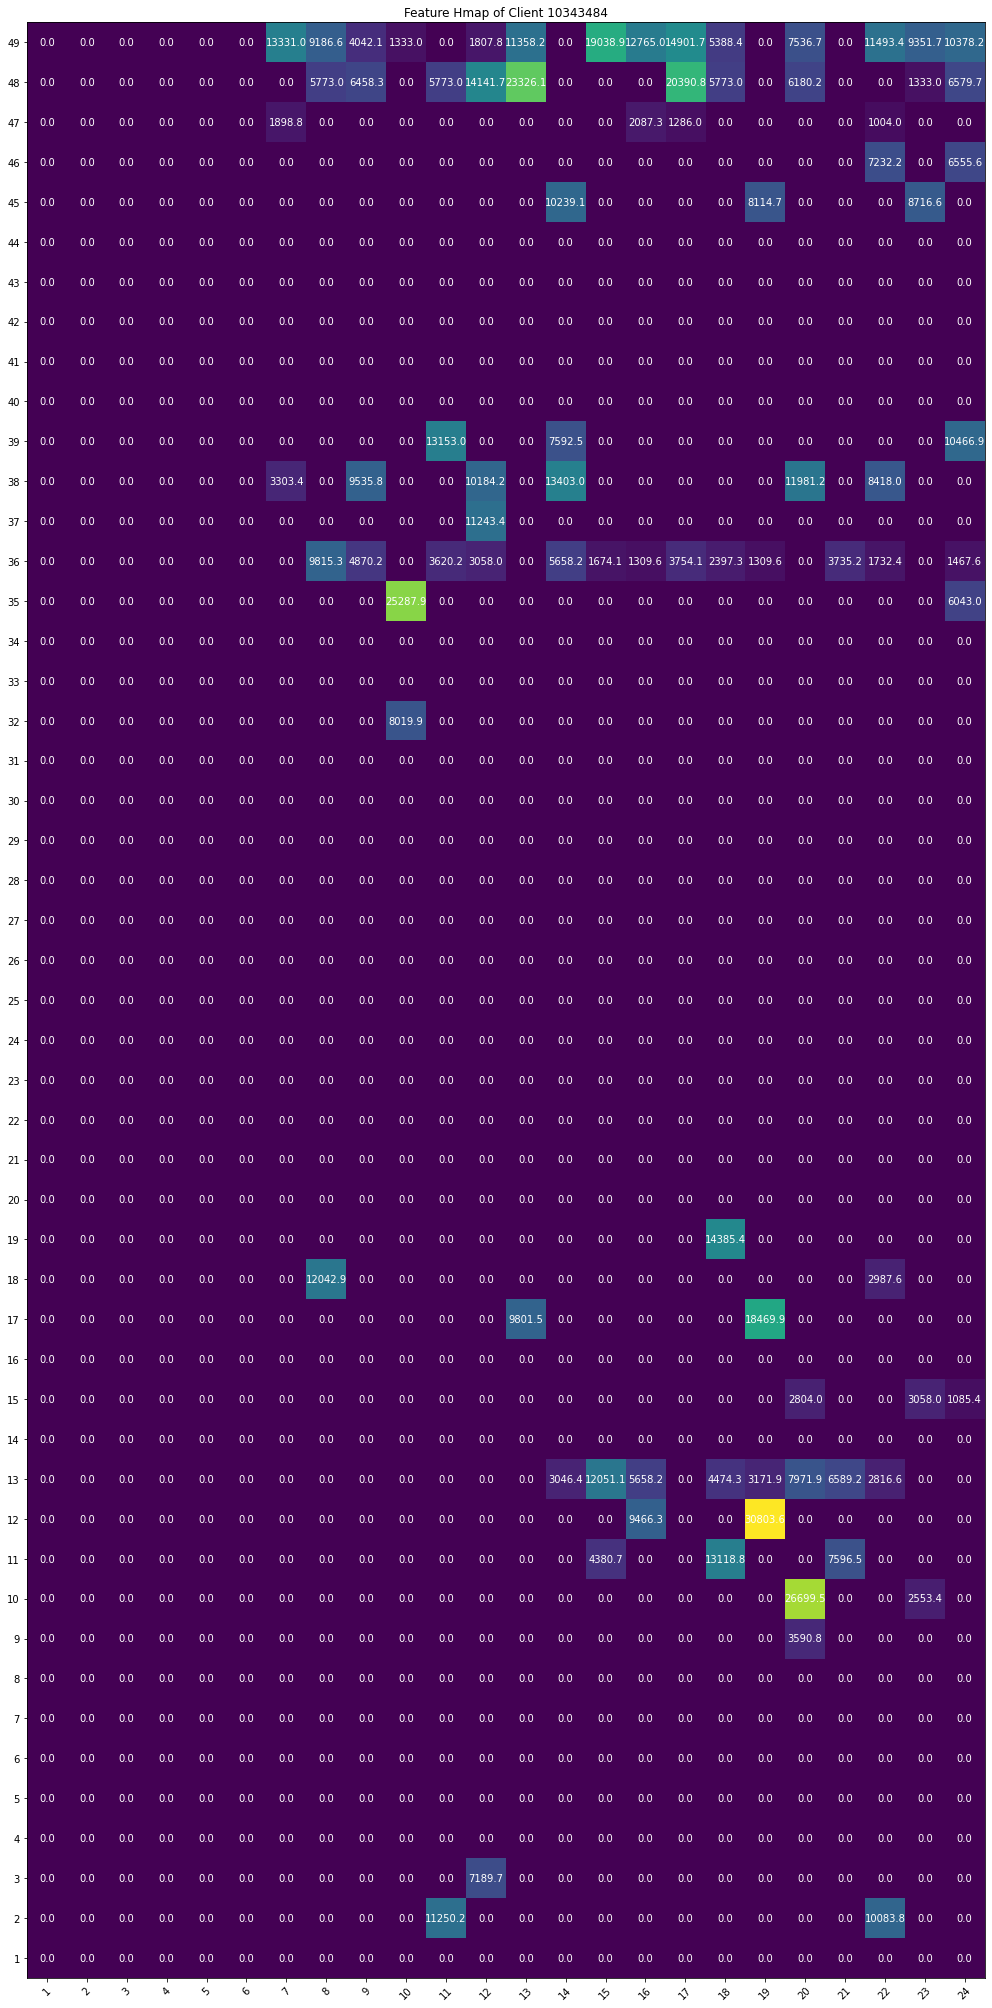

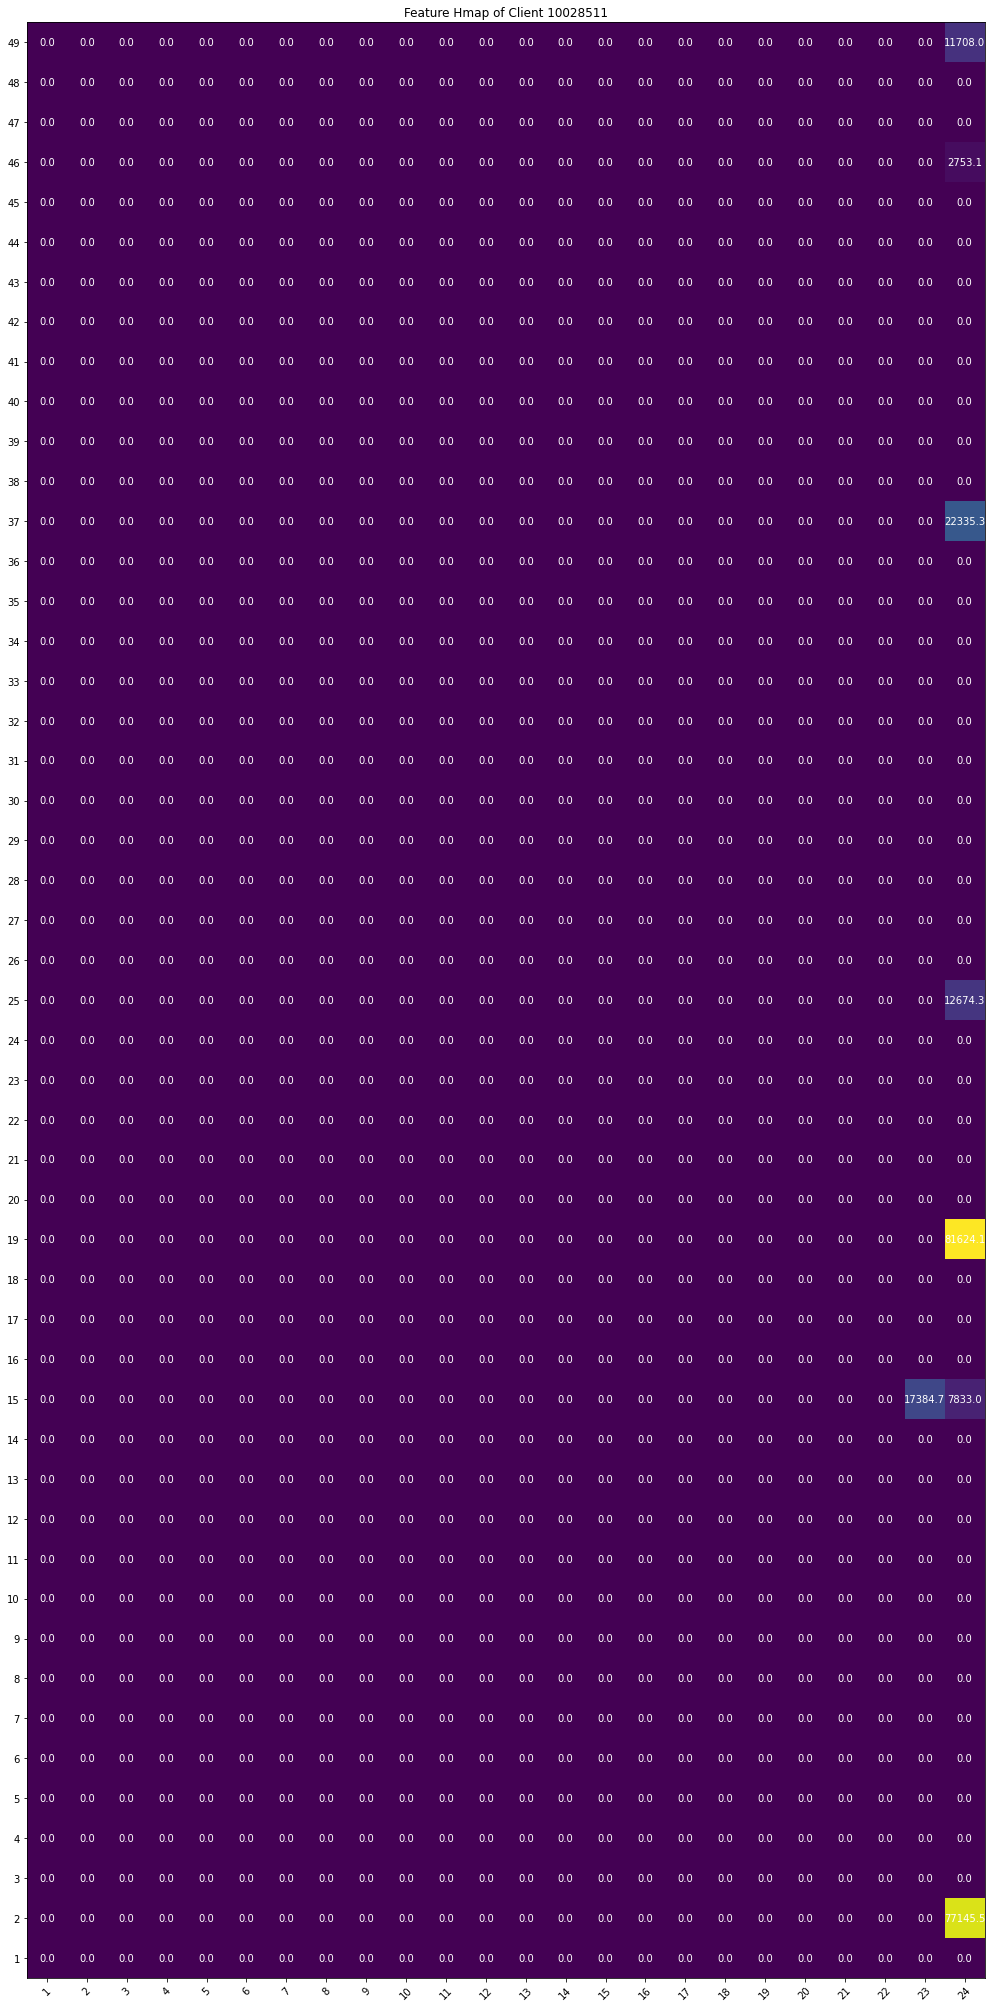

In [5]:
# 6. Check if the specified patterns have some special patterns
# either spatial (i.e., between shop_tags) or temporal
chids = sample(list(df['chid'].unique()), 5)
for chid in chids:
    plot_dt_shop_tag_hmap(chid, 'txn_amt')

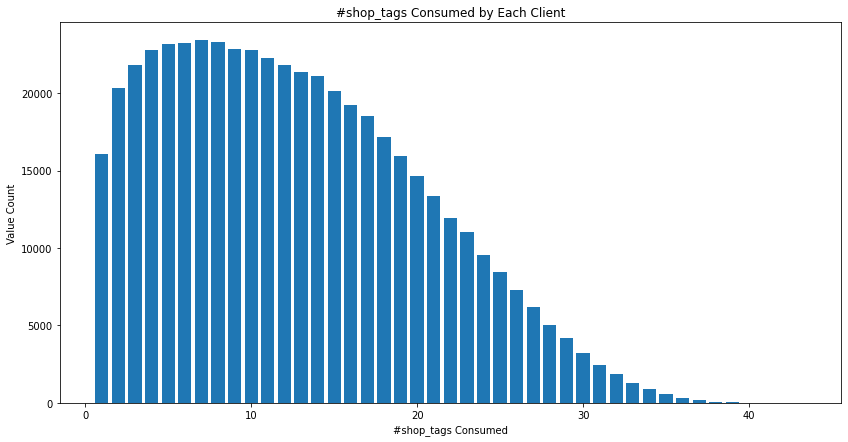

In [23]:
# 7. Check number of shop_tags every client has consumed so far;
# that is, those having been consumed by the client in the past
n_shop_tags = df.groupby(by=['chid'])['shop_tag'].nunique()
n_shop_tag_counts = n_shop_tags.value_counts()
n_shop_tag_counts.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x=n_shop_tag_counts.index, height=n_shop_tag_counts.values)
ax.set_xlabel("#shop_tags Consumed")
ax.set_ylabel("Value Count")
ax.set_title("#shop_tags Consumed by Each Client")
plt.show()

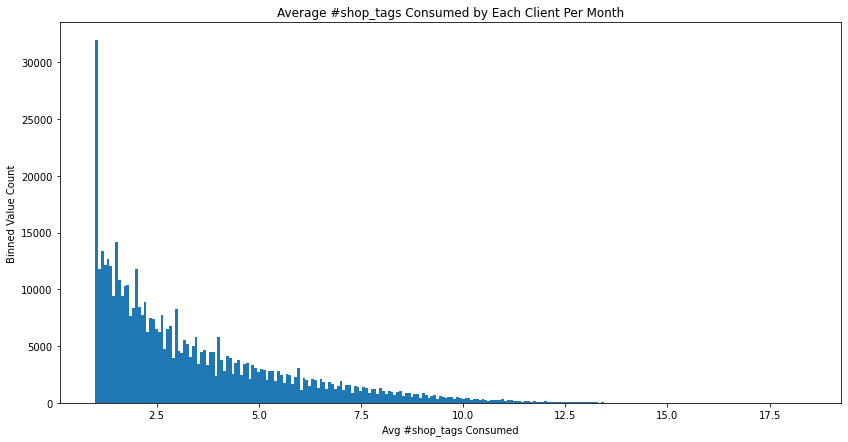

In [35]:
# 8. Check average number of shop_tags every client consumed per month
avg_shop_tags = df.groupby(by=['chid', 'dt'], 
                           sort=False)['shop_tag'].nunique()
chid = avg_shop_tags.index.droplevel('dt')
avg_shop_tags = pd.DataFrame(avg_shop_tags.values, 
                             index=chid,
                             columns=['n_shop_tags'])
avg_shop_tags = avg_shop_tags.groupby(by=avg_shop_tags.index,
                                      sort=True)['n_shop_tags'].mean()

fig, ax = plt.subplots(figsize=(14, 7))
ax.hist(x=avg_shop_tags, bins=250)
ax.set_title(f"Average #shop_tags Consumed by Each Client Per Month")
ax.set_xlabel(f"Avg #shop_tags Consumed")
ax.set_ylabel("Binned Value Count")
plt.show()

In [32]:
# 9. Analyze quantiles of average #shop_tags consumed by each client per month
qs, qvs = [], []
for q in np.arange(0.1, 1, 0.1):
    qs.append(int(q*100))
    qvs.append(n_shop_tags_avg_per_month.quantile(q).round(2))
print(f"=====Quantiles of Avg #shop_tags Consumed (from 10% ~ 90% Quantiles)=====")
print(qs)
print(qvs)
print(f"Minimum: {n_shop_tags_avg_per_month.quantile(0)} | Maximum {n_shop_tags_avg_per_month.quantile(1)}")
print(f"Nearly {np.sum(n_shop_tags_avg_per_month <= 10) / 500000 * 100:.2f}% of avg #shop_tags consumed is less or equal to 10.")

=====Quantiles of Avg #shop_tags Consumed (from 10% ~ 90% Quantiles)=====
[10, 20, 30, 40, 50, 60, 70, 80, 90]
[1.17, 1.46, 1.78, 2.17, 2.65, 3.26, 4.04, 5.14, 6.8]
Minimum: 1.0 | Maximum 18.375
Nearly 98.36% of avg #shop_tags consumed is less or equal to 10.


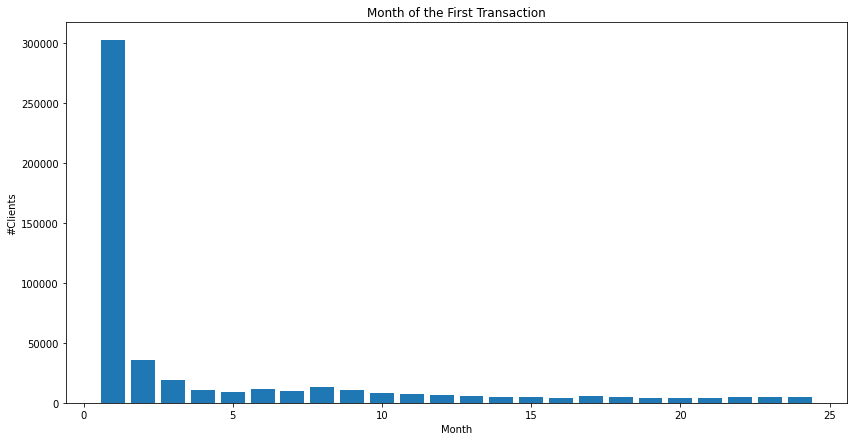

In [10]:
# 10. Display the time point of each client's first consumption 
dts, dts_first_txn = np.unique(chid_gps['dt'].min(), return_counts=True)
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x=dts, height=dts_first_txn)
ax.set_title(f"Month of the First Transaction")
ax.set_xlabel("Month")
ax.set_ylabel("#Clients")
plt.show()

In [5]:
# 11. Observe if 'slam' is dynamic
n_slams = df.groupby(by=['chid'])['slam'].nunique()

for i, n_slam in n_slams.iteritems():
    if n_slam > 1:
        print("Feature slam is dynamic.")
        break

Feature slam is dynamic.


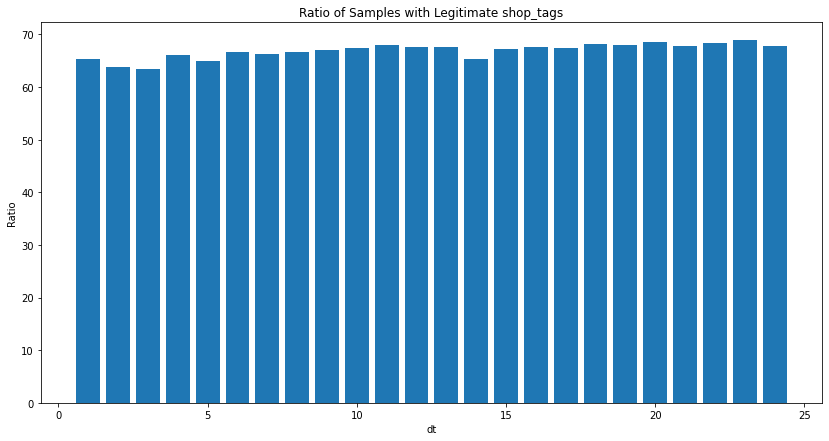

In [6]:
# 12. Observe if sampling technique (e.g., over sampling) is needed for leg shop_tags
ratios_with_leg_shop_tags = []
for dt in DTS:
    df_ = df[df['dt'] == dt]
    ratio_with_leg_shop_tags = df_[df_['shop_tag'].isin(LEG_SHOP_TAGS)].shape[0] / len(df_) * 100
    ratios_with_leg_shop_tags.append(ratio_with_leg_shop_tags)
    del df_
    
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x=DTS, height=ratios_with_leg_shop_tags)
ax.set_title("Ratio of Samples with Legitimate shop_tags")
ax.set_xlabel("dt")
ax.set_ylabel("Ratio")
plt.show()

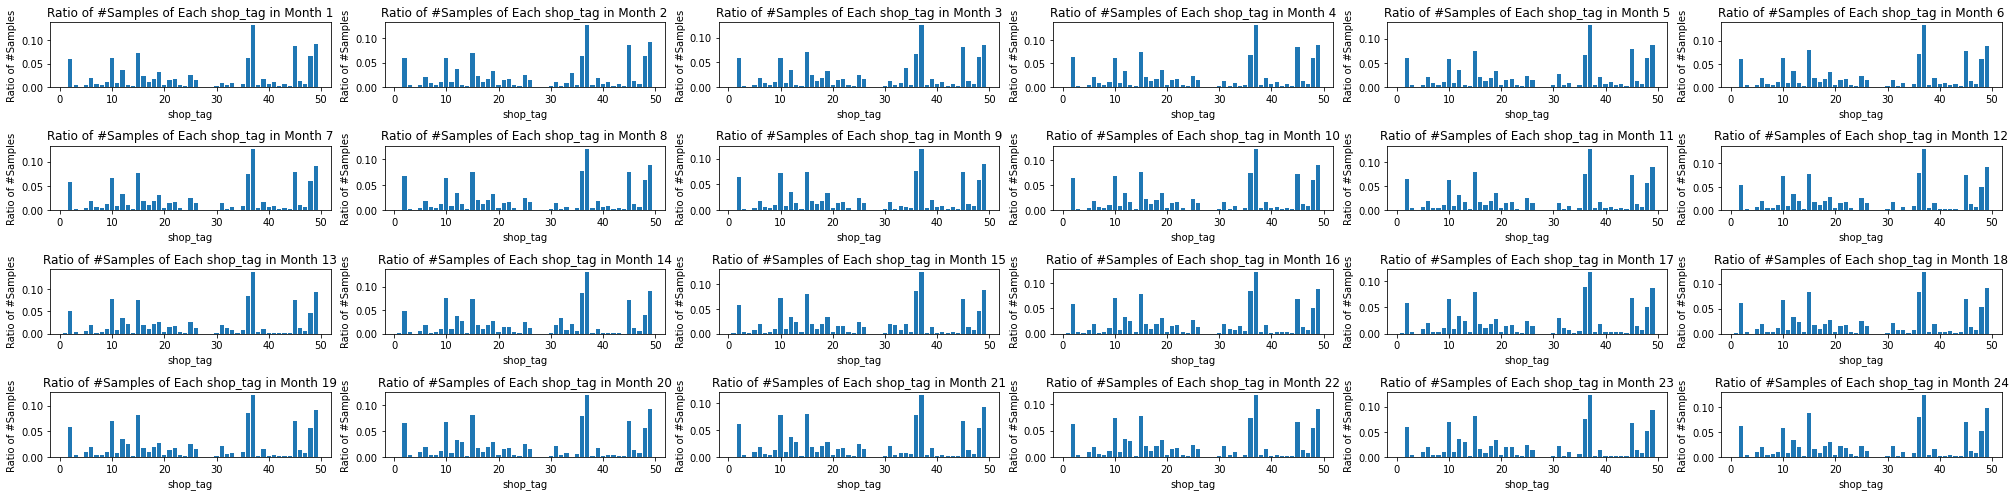

In [4]:
# 13. Check balancing of #samples of each legitimate shop_tags in each month
# (also, the distribution can help me observe the discrepancy among months)
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(28, 7))

for i, dt in enumerate(DTS):
    df_ = df[(df['dt'] == dt)]# & (df['shop_tag'].isin(LEG_SHOP_TAGS))]
    val_cnts = df_['shop_tag'].value_counts(normalize=True, sort=False)
    val_cnts.sort_index(inplace=True)
    
    axs[i//6, i%6].bar(x=list(val_cnts.index), height=list(val_cnts.values))
    axs[i//6, i%6].set_title(f"Ratio of #Samples of Each shop_tag in Month {dt}")
    axs[i//6, i%6].set_xlabel("shop_tag")
    axs[i//6, i%6].set_ylabel(f"Ratio of #Samples")
    del df_, val_cnts
plt.tight_layout()

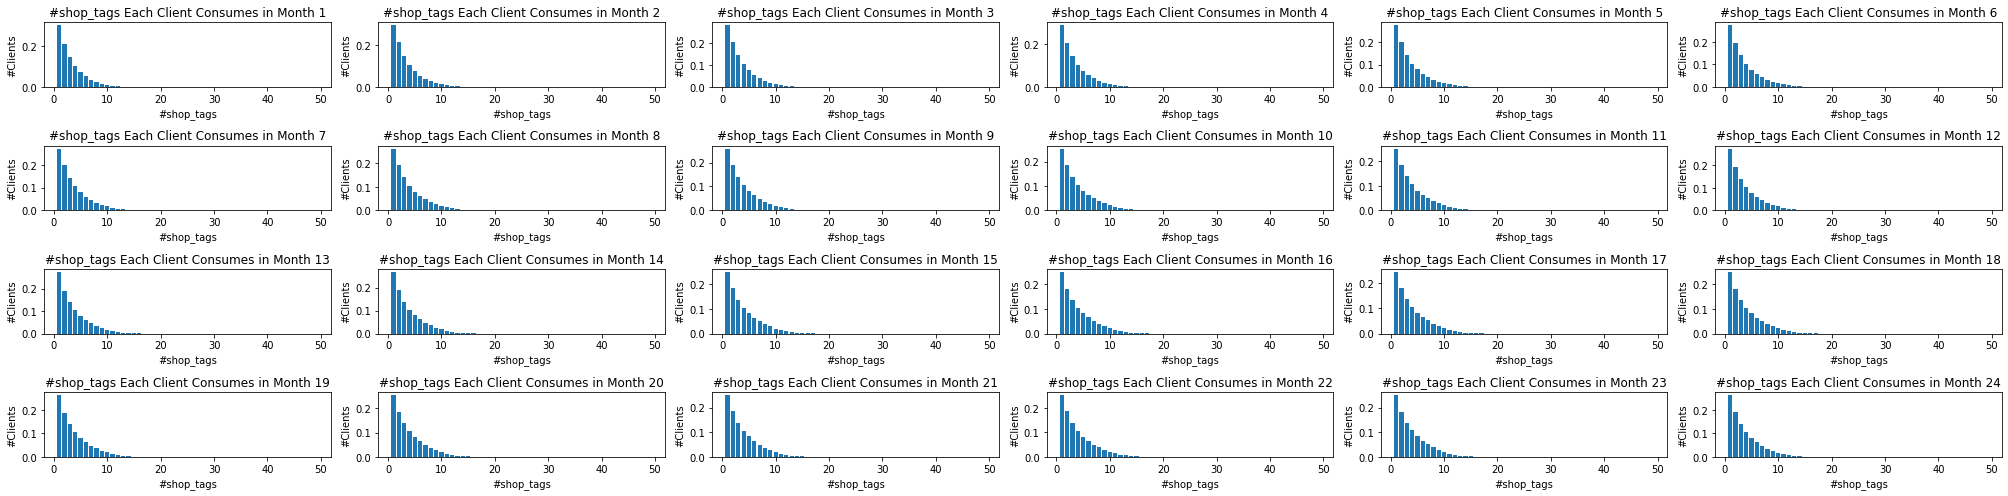

In [28]:
# 14. Check #shop_tags each client consumes in each month
# (also, the distribution can help me observe the discrepancy among months)
n_shop_tags = df.groupby(by=['dt', 'chid'])['shop_tag'].nunique()
n_shop_tags = n_shop_tags.reset_index(level=['chid'], drop=False)
n_shop_tags = n_shop_tags.groupby(by=n_shop_tags.index)['shop_tag'].value_counts()

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(28, 7))
for i, dt in enumerate(DTS):
    n_shop_tags_ = n_shop_tags[(n_shop_tags.index.get_level_values('dt') == dt)]# & (df['shop_tag'].isin(LEG_SHOP_TAGS))]
    n_shop_tags_.reset_index(level='dt', drop=True, inplace=True)
    n_shop_tags_ = n_shop_tags_.reindex(SHOP_TAGS_, fill_value=0)
    
    axs[i//6, i%6].bar(x=n_shop_tags_.index, height=n_shop_tags_.values / np.sum(n_shop_tags_.values))
    axs[i//6, i%6].set_title(f"#shop_tags Each Client Consumes in Month {dt}")
    axs[i//6, i%6].set_xlabel("#shop_tags")
    axs[i//6, i%6].set_ylabel(f"#Clients")
    del n_shop_tags_
plt.tight_layout()

## b. Multivariate Analysis
In the second part, I take feature interaction into consideration, meaning that the analysis is based on more than one single feature. With this analysis, we can dig deeper into the underlying data behavior, and try to find out if there are some unreasonable conditions among the data.

### *`(cnt, amt)` Pairs*
Because each tranaction count corresponds to a transaction amount, I think there might be some situations that the correspondence fails.
#### Analysis and Observation
1. There are 9907490 samples with `(cnt, amt)` not aligned. That is, either the following situations occurs:
    * Transaction count is zero, but amount isn't.
    * Transaction count isn't zero, but amount is.

> The first situation above is reasonable due to the occurrence of **returning consumption for refund**.

<div class='alert alert-warning'>
    <p>
    <strong>(Solved)</strong> 2. There are 30137 samples with <strong>unreasonable</strong> <code>(cnt, amt)</code> pairs. That is, the second situation described above occurs.
    </p>
</div>

In [3]:
# Check if transaction amount and transaction count are aligned;
# that is, if one of them is zero, how about the other one 
def check_cnt_amt_aligned(sub_df):
    '''Check if (cnt, amt) pairs are aligned or not.
    *Note: This function is designed for subset of raw data to save mem.
    
    Parameters:
        sub_df: pd.DataFrame, subset of raw data 
    
    Return:
        aligned: ndarray, numbers of non-aligned (cnt, amt) pairs per sample
    '''
    sub_df_cnt = sub_df[cols_cnt].astype(bool).to_numpy()
    sub_df_amt = sub_df[cols_amt].astype(bool).to_numpy()
    aligned = np.sum(np.logical_xor(sub_df_cnt, sub_df_amt), axis=1)
    
    return aligned
    
cols_cnt = [col for col in COLS if col.endswith('cnt')]
cols_amt = [col for col in COLS if col.endswith('pct') or col == 'txn_amt']
chid_not_aligned = [] 
for file in tqdm(os.listdir("../data/partitioned/")):
    sub_df = pd.read_parquet(os.path.join("../data/partitioned/", file))
    sub_df['cnt_amt_aligned'] = check_cnt_amt_aligned(sub_df)
    chid_not_aligned += list(sub_df[sub_df['cnt_amt_aligned'] != 0]['chid'])
    
    del sub_df

100%|██████████| 330/330 [00:07<00:00, 43.94it/s]


In [13]:
# Analyze clients with (cnt, amt) not aligned
def check_cnt_amt_reasonable(df_not_aligned):
    '''Check if the non-alignment is reasonable or not.
    
    Parameters:
        df_not_aligned: pd.DataFrame, samples with non-aligned (cnt, amt)
    
    Return:
        reasonable: list, number of unreasonable (cnt, amt) pairs per sample
    '''
    df_not_aligned_cnt = df_not_aligned[cols_cnt].astype(bool).to_numpy()
    df_not_aligned_amt = df_not_aligned[cols_amt].astype(bool).to_numpy()
    reasonable = []
    for i in tqdm(range(df_not_aligned_cnt.shape[0])):
        reasonable_tmp = 0
        for j in range(df_not_aligned_cnt.shape[1]):
            if df_not_aligned_cnt[i][j] != 0 and df_not_aligned_amt[i][j] == 0:
                reasonable_tmp += 1
        reasonable.append(reasonable_tmp)
    return reasonable

df = pd.read_parquet(DATA_PATH_RAW)
df_not_aligned = df[df['chid'].isin(chid_not_aligned)]
del df 
gc.collect()
df_not_aligned['cnt_amt_reasonable'] = check_cnt_amt_reasonable(df_not_aligned)
df_unreasonable = df_not_aligned[df_not_aligned['cnt_amt_reasonable'] != 0]
print(f"#Samples with (cnt, amt) pairs not aligned: {len(df_not_aligned)}\n"
      f"#Samples with unreasonable (cnt, amt) pairs: {len(df_unreasonable)}")

#Clients with (cnt, amt) pairs not aligned: 9907490
#Clients with unreasonable (cnt, amt) pairs: 30137


### *`primary_card` Interpretation*
If one client make transactions with more than one card on the same consumption category in one month. How to interpret `primary_card`?
#### Analysis and Observation
<div class='alert alert-warning'>
    <p>
    <strong>(Solved)</strong> 1. There are 1249538 samples with transaction card counts not equal to one. And I don't know how to interpret <code>primary card</code>. Notice that I explore this phenomenon using <code>card_x_txn_cnt</code> which might lead to some missing transactions if there exists any <strong>return for refund</strong>.
     </p>
</div>

In [11]:
# Check 'primary_card' behavior of those samples with more than one
# card having non-zero transaction counts
def count_txn_cards(sub_df):
    '''Count number of cards used in each sample.
    
    Parameters:
        sub_df: pd.DataFrame, subset of raw data 
        
    Return:
        card_counts: list, number of cards used per sample
    '''
    sub_df_card_txn_cnt = sub_df[cols_card_txn_cnt].astype(bool).to_numpy()
    card_counts = list(np.sum(sub_df_card_txn_cnt, axis=1))
    
    return card_counts

cols_card_txn_cnt = [col for col in COLS if col.startswith('card') and col.endswith('txn_cnt')] 
txn_cards = []
for file in tqdm(FILE_ORDERED):
    sub_df = pd.read_parquet(os.path.join("../data/partitioned/", file))
    txn_cards += count_txn_cards(sub_df)
    
    del sub_df
    
df = pd.read_parquet(DATA_PATH_RAW)
df['txn_cards'] = txn_cards
df_ = df[df['txn_cards'] != 1]
print(f"#Samples making transactions with more than one card: {len(df_)}")

#Samples making transactions with more than one card: 1249538


### *Spatial-Temporal - `PIF` Analysis*
The main idea comes from [Modeling Personalized Item Frequency Information forNext-basket Recommendation](https://dl.acm.org/doi/pdf/10.1145/3397271.3401066). Namely, this is the analysis of **personalized item frequency**, from which I can understand if this specific dataset follows the statement in the paper. Notice that I randomly sample a subset of clients to speed up the process. And, the clients (~2000 out of 15000 samples) having no next baskets (*i.e.*, |T|=0) are excluded.
#### Analysis and Observation
1. Nearly 90 % items in the next baskets can be captured by either **repeated purchases pattern** (client-specific)
2. Nearly 100 % items in the next baskets can be captured by either **collaborative purchases pattern**.
3. Neighbors seem to have a better capturing capability. Actually, I think it's because #`shop_tag`s is rather small compared to other benchmark datasets. Hence, after aggregating the baskets from neighbors, it's easy to hit items in the **next target basket**.
4. Nearly all of the items in the next baskets can be capture by either of them (i.e., ~0% not captured, see recall_NP_NN).

In [3]:
df = pd.read_parquet(DATA_PATH_RAW, columns=['dt', 'chid', 'shop_tag'])
df.sort_values(by=['chid', 'dt', 'shop_tag'], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

dt      chid  shop_tag
0   1  10000000        10
1   1  10000000        12
2   2  10000000        46
3   3  10000000        10
4   4  10000000        10

In [3]:
def get_purch_vec(chid_dt_gp):
    '''Return purchasing vector of one client for one month.
    
    Parameter:
        chid_dt_gp: pd.DataFrame, purchasing record of one client for 
                    one month
    
    Return:
        purch_vec: ndarray, purchasing vector indicating purchasing the 
                   shop_tag or not (i.e., represented by 0/1)
    '''
    purch_vec = np.zeros(49, dtype=np.int8)
    purch_vec[chid_dt_gp['shop_tag'].values-1] = 1
    
    return purch_vec
    
def get_purch_map(chid_gp):
    '''Return purchasing map of one client (including all months).
    
    Parameter:
        chid_dt_gp: pd.DataFrame, purchasing record of one client
    
    Return:
        purch_map: ndarray, purchasing map indicating purchasing the 
                   shop_tag or not (i.e., represented by 0/1)
    '''
    purch_map = chid_gp.groupby(by=['dt']).apply(get_purch_vec)
    empty_dts = [dt-1 for dt in DT_INDICES 
                 if dt not in purch_map.index]   # -1 to align with insertion idx
    purch_map = purch_map.values   # Shape (24, )
    purch_map = np.vstack(purch_map)
    # Insert empty basket index by index, becasuse inserting all at once leads to 
    # undesired results, for more information, see np.insert
    for empty_dt in empty_dts:
        purch_map = np.insert(purch_map, obj=empty_dt, values=EMPTY_BASKET, axis=0)
    
    return purch_map

def get_pif(purch_map, t1, t2):
    '''Return personalized item frequency computed from the given time
    interval.
    
    Parameters:
        purch_map: ndarray, purchasing map indicating purchasing the 
                   shop_tag or not (i.e., represented by 0/1)
        t1: int, time lower bound
        t2: int, time upper bound
    
    Return:
        pif: ndarray, personalized item frequency vector
    '''
    # Align with array index
    purch_map = purch_map[t1:t2]
    pif = np.sum(purch_map, axis=0)
    return pif

In [ ]:
# Generate and dump purchasing maps
chid_gps = df.groupby(by=['chid'])
DT_INDICES = [t+1 for t in range(N_MONTHS)]
EMPTY_BASKET = np.zeros(N_SHOP_TAGS, dtype=np.int8)
purch_maps = {}
for chid_gp_name, chid_gp in tqdm(chid_gps):
    purch_maps[chid_gp_name] = get_purch_map(chid_gp)

with open("../data/processed/purch_maps.pkl", 'wb') as f:
    pickle.dump(purch_maps, f)

In [4]:
# Generate pif and target baskets for further importance analysis
with open("../data/processed/purch_maps.pkl", 'rb') as f:
    purch_maps = pickle.load(f)
pifs = {}
t_start, t_end = 0, 23   # Notice that t_end is excluded

for chid, purch_map in tqdm(purch_maps.items()):   
    pifs[chid] = get_pif(purch_map, t1=t_start, t2=t_end)
target_baskets = {chid: purch_map[-1] for chid, purch_map in purch_maps.items()}

100%|██████████| 500000/500000 [00:02<00:00, 179629.98it/s]


In [7]:
# Analyze importances of two patterns behind pif
cosine_sim = lambda v1, v2: np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
recall_P, recall_N, recall_P_N, recall_NP_NN = 0, 0, 0, 0 
n_neighbors = 50
n_chid_samples = 15000
n_chid_no_next_basket = 0
chid_samples = sample(purch_maps.keys(), n_chid_samples)

for chid in tqdm(chid_samples):
    sim_vecs = {}
    P, T = pifs[chid], target_baskets[chid]
    neighbor_candidates = sample(purch_maps.keys(), 500)
    
    for chid_ in neighbor_candidates:
        if chid == chid_: continue
        neighbor = pifs[chid_]
        sim_vecs[chid_] = cosine_sim(T, neighbor)
    sim_vecs = dict(sorted(sim_vecs.items(), 
                           key=lambda item: item[1], 
                           reverse=True))
    neighbors = list(sim_vecs.keys())[:n_neighbors]
    N = np.array([False for _ in range(N_SHOP_TAGS)])
    for n in neighbors:
        N = np.bitwise_or(N, pifs[n].astype(bool))
        if N.sum() == N_SHOP_TAGS:
            # If all shop_tags are included in the past baskets of neighbors
            break
    P, T = P.astype(bool), T.astype(bool)
    NP, NN = ~P, ~N
    if T.sum() == 0:
        n_chid_no_next_basket += 1
    else:
        recall_P += (P * T).sum() / T.sum() 
        recall_N += (N * T).sum() / T.sum()
        recall_P_N += (P * N * T).sum() / T.sum()
        recall_NP_NN += (NP * NN * T).sum() / T.sum()
    del T, sim_vecs, neighbor_candidates, neighbors

n_chid_valid = n_chid_samples - n_chid_no_next_basket
recall_P = recall_P / n_chid_valid
recall_N = recall_N / n_chid_valid
recall_P_N = recall_P_N / n_chid_valid
recall_NP_NN = recall_NP_NN / n_chid_valid
print("=====PIF Pattern Importance=====")
print(f"{n_chid_no_next_basket} has no next basket.")
print("{:>15}{:>15}{:>15}{:>15}".format('Recall_P', 'Recall_N', 'Recall_P_N', 'Recall_NP_NN'))
print("{:15}{:15}{:15}{:15}".format(recall_P.round(4), recall_N.round(4), recall_P_N.round(4), recall_NP_NN.round(4)))

100%|██████████| 15000/15000 [02:40<00:00, 93.44it/s]

=====PIF Pattern Importance=====
1933 has no next basket.
       Recall_P       Recall_N     Recall_P_N   Recall_NP_NN
         0.9013         0.9995         0.9009         0.0001


### *Spatial-Temporal - Dynamic of `txn_cnt`*
To observe the temporal patterns of transaction counts and the popularity of each `shop_tag`s, I decide to explore the **global transaction count patterns** using different visualzation methods.
#### Analysis and Observation 
1. The legitimate `shop_tag`s all have relatively high transaction counts, which are displayed as follows:<br>
[2, 6, 10, 12, 13, 15, 18, 19, 21, 22, 25, 26, 36, 37, 39, 48]
2. Peak months are clustered at closer months. One of the reason is that the number of clients participating in and starting the transactions increases with time, which can also be observed from the figure summing transaction counts over `shop_tag`s.

<div class='alert alert-block alert-warning'>
    <p><s>3. We can see that there are more transaction counts in some months compared with the neighbor months. Hence, I use <strong>seansonal decomposition</strong> to see if it can help me find out the correct month. Combined with some surveys, I guess that month id 24 is <i>September</i>.</p></s>
</div>

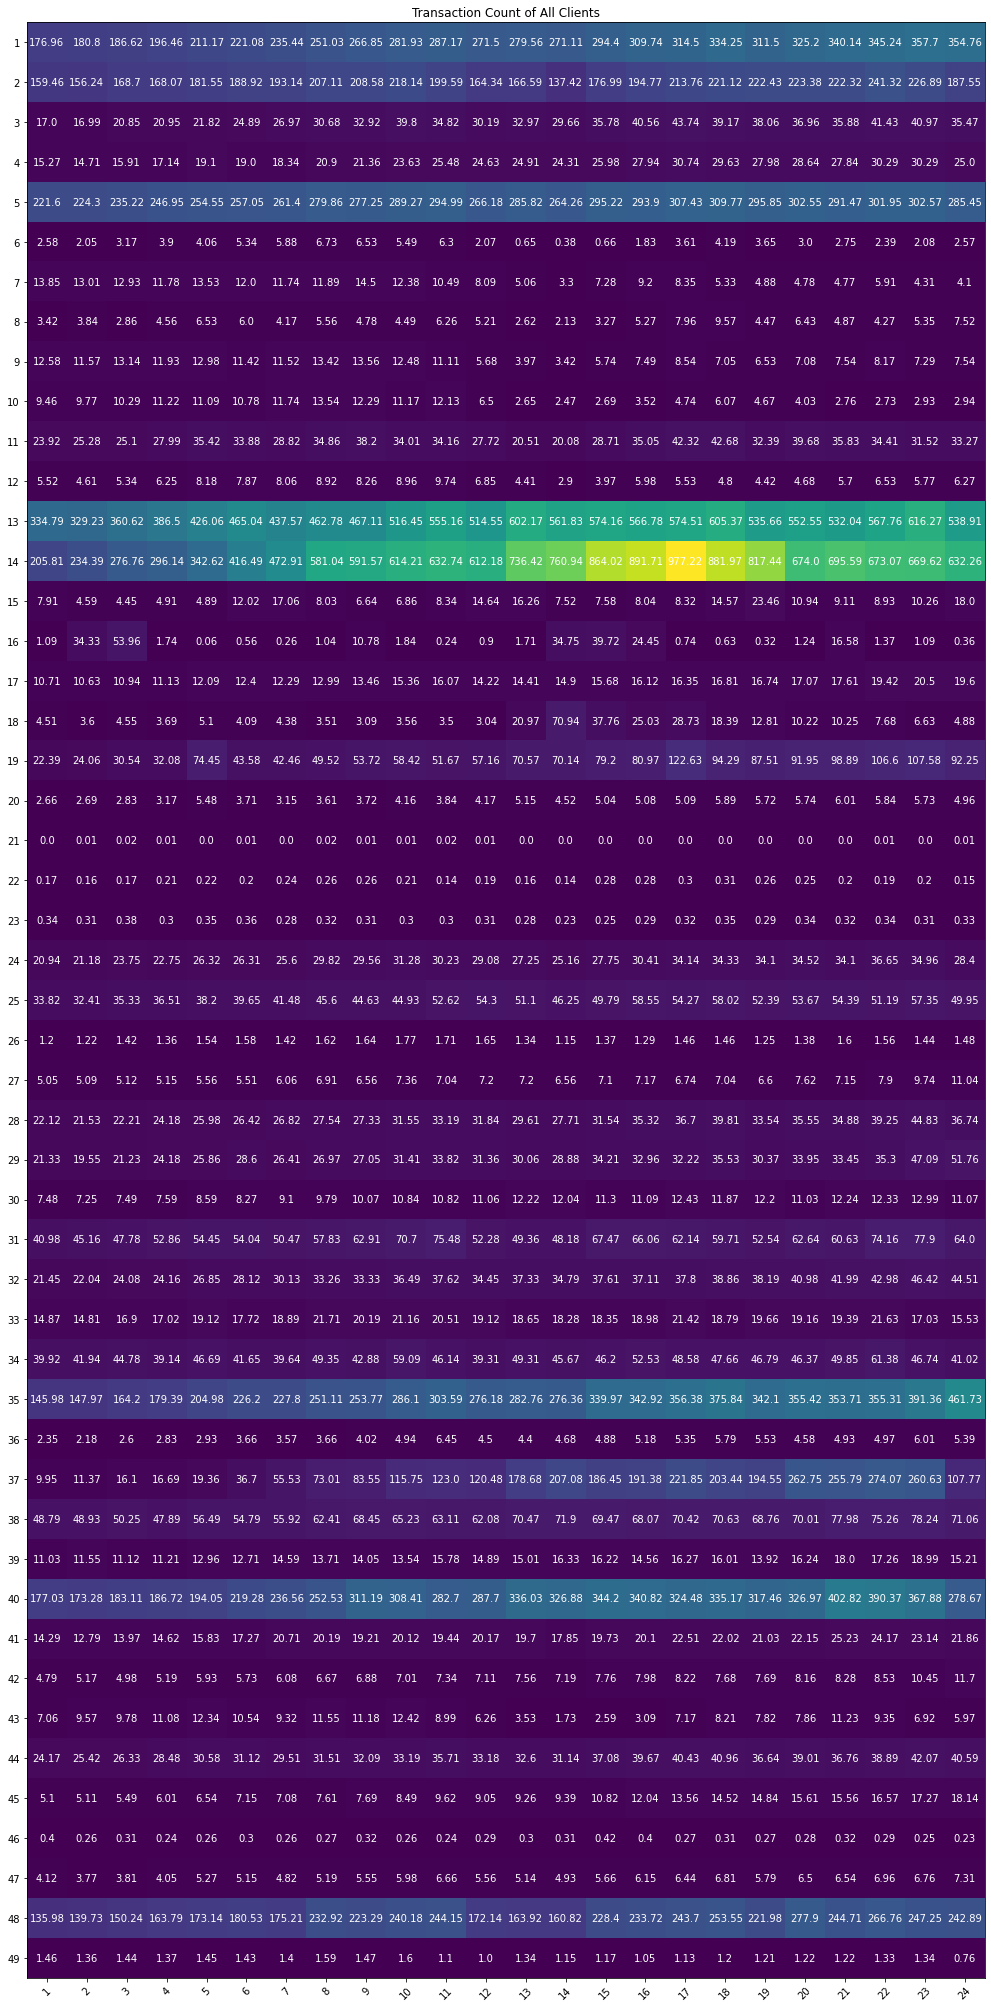

In [7]:
# Analyze transaction peaks using vanilla total transaction counts
# txn_cnt_map = get_txn_cnt_map(df, chid=None)
# with open("../data/processed/txn_cnt_map_global.npy", 'wb') as f:
#     np.save(f, txn_cnt_map_global)

# Load global transaction count map
## Notice the ordering bug ##
with open("../data/processed/txn_cnt_map_global.npy", 'rb') as f:
    txn_cnt_map = np.load(f)
txn_cnt_map = np.round_(txn_cnt_map / 1000, decimals=2)   # Scale to facilitate visualization

fig, ax = plt.subplots(figsize=(20, 28))
hmap = ax.imshow(txn_cnt_map)
ax.set_xticks(np.arange(len(DTS)))
ax.set_yticks(np.arange(len(SHOP_TAGS)))
ax.set_xticklabels(DTS, rotation=45)
ax.set_yticklabels(SHOP_TAGS)
for i in range(len(SHOP_TAGS)):
    for j in range(len(DTS)):
        text = ax.text(j, len(SHOP_TAGS)-1-i, txn_cnt_map[len(SHOP_TAGS)-1-i][j],
                       ha="center", va="center", color="w")
ax.set_title(f"Transaction Count of All Clients")
fig.tight_layout()
plt.show()

Consumption peak months: 
[ 3  8  9 10 11 14 15 16 17 18 19 20 21 22 23 24]
[ 3  3  2  3  2  1  1  1  4  4  1  1  3  4 10  6]


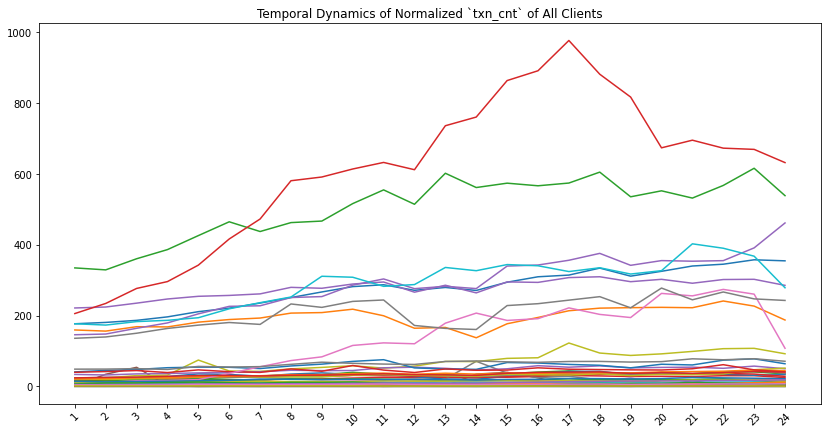

In [8]:
# Use line plot to show transaction count curve
# and counts of peak months are also shown
fig, ax = plt.subplots(figsize=(14, 7))
for shop_tag in SHOP_TAGS:
    ax.plot(txn_cnt_map[shop_tag-1, ])
ax.set_xticks(np.arange(len(DTS)))
ax.set_xticklabels(DTS, rotation=45)
ax.set_title(f"Temporal Dynamics of Normalized `txn_cnt` of All Clients")
fig.show()

peak_month = np.argmax(txn_cnt_map, axis=1) + 1
peak_months, peak_month_cnts = np.unique(peak_month, return_counts=True)
print(f"Consumption peak months: \n{peak_months}\n{peak_month_cnts}")

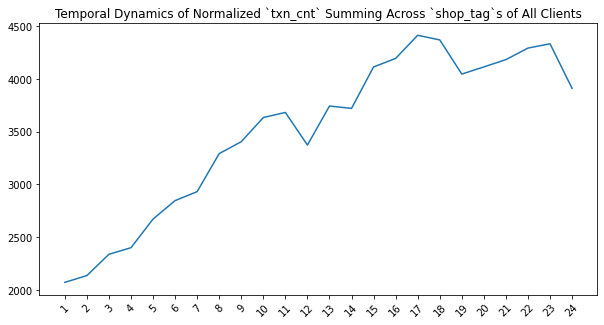

In [9]:
# Display transaction count at the global scale
# (i.e., summing over `shop_tag`s)
txn_cnt_vec = np.sum(txn_cnt_map, axis=0)   # Transaction counts summing across `shop_tag`s
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(txn_cnt_vec)
ax.set_xticks(np.arange(len(DTS)))
ax.set_xticklabels(DTS, rotation=45)
ax.set_title(f"Temporal Dynamics of Normalized `txn_cnt` Summing Across `shop_tag`s of All Clients")
fig.show()

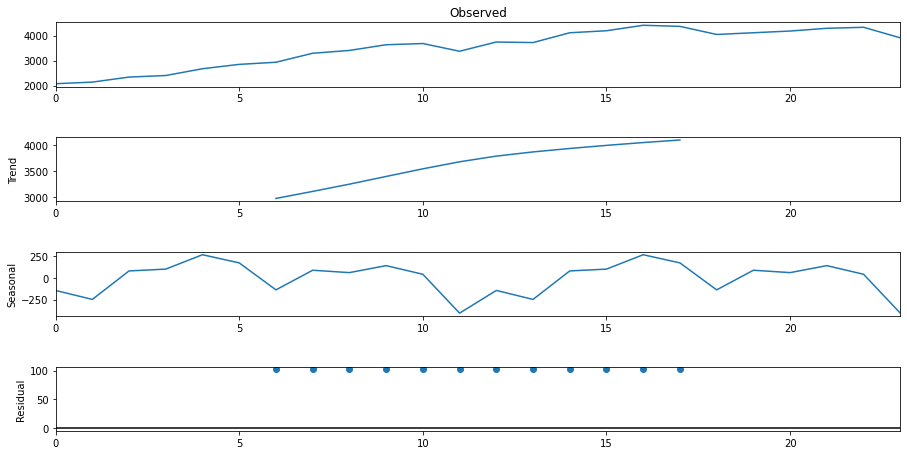

In [10]:
# Use simple seasonal decomposition to facilitate the guessing of the month
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(txn_cnt_vec, period=12, model='additive')
fig = decomp.plot()
fig.set_size_inches(14, 7)

### *Transaction Gap*
To explore if there's a chance to guess the real meanings of `shop_tag`s, I analyze the time gap between two transactions on the same `shop_tag` for each client. From this analysis, we can varify if **closer** transactions have stronger effect on the next transaction basket. Notice that for those `shop_tag`s having not been consumed so far or only once, I filter them out to facilitate the better quality of visualization.

#### Analysis and Observation 
1. Transaction gaps for all `shop_tag`s seem to follow power law, varifying the assumption that closer transactions have stronger motivation for clients to buy them again in the near months.

<div class='alert alert-block alert-warning'>
    <p>2. An interesting phenomenon occurs at value bin 10 ~ 11, and I've not come up with any idea about why it behaves like this.</p>
</div>

3. If samples with transaction gaps greater than 23 are included, value bin 23 ~ 24 will dominate the plot. And, it again introduces the idea that each `shop_tag` has its own loyal clients. In other words, clients make transactions on the specific subsets of `shop_tag`s.
4. There are some `shop_tag`s show the property of yearly transaction (*e.g.*, `17` and `34`), because value bin 11 ~ 12 has the most number of clients.

100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


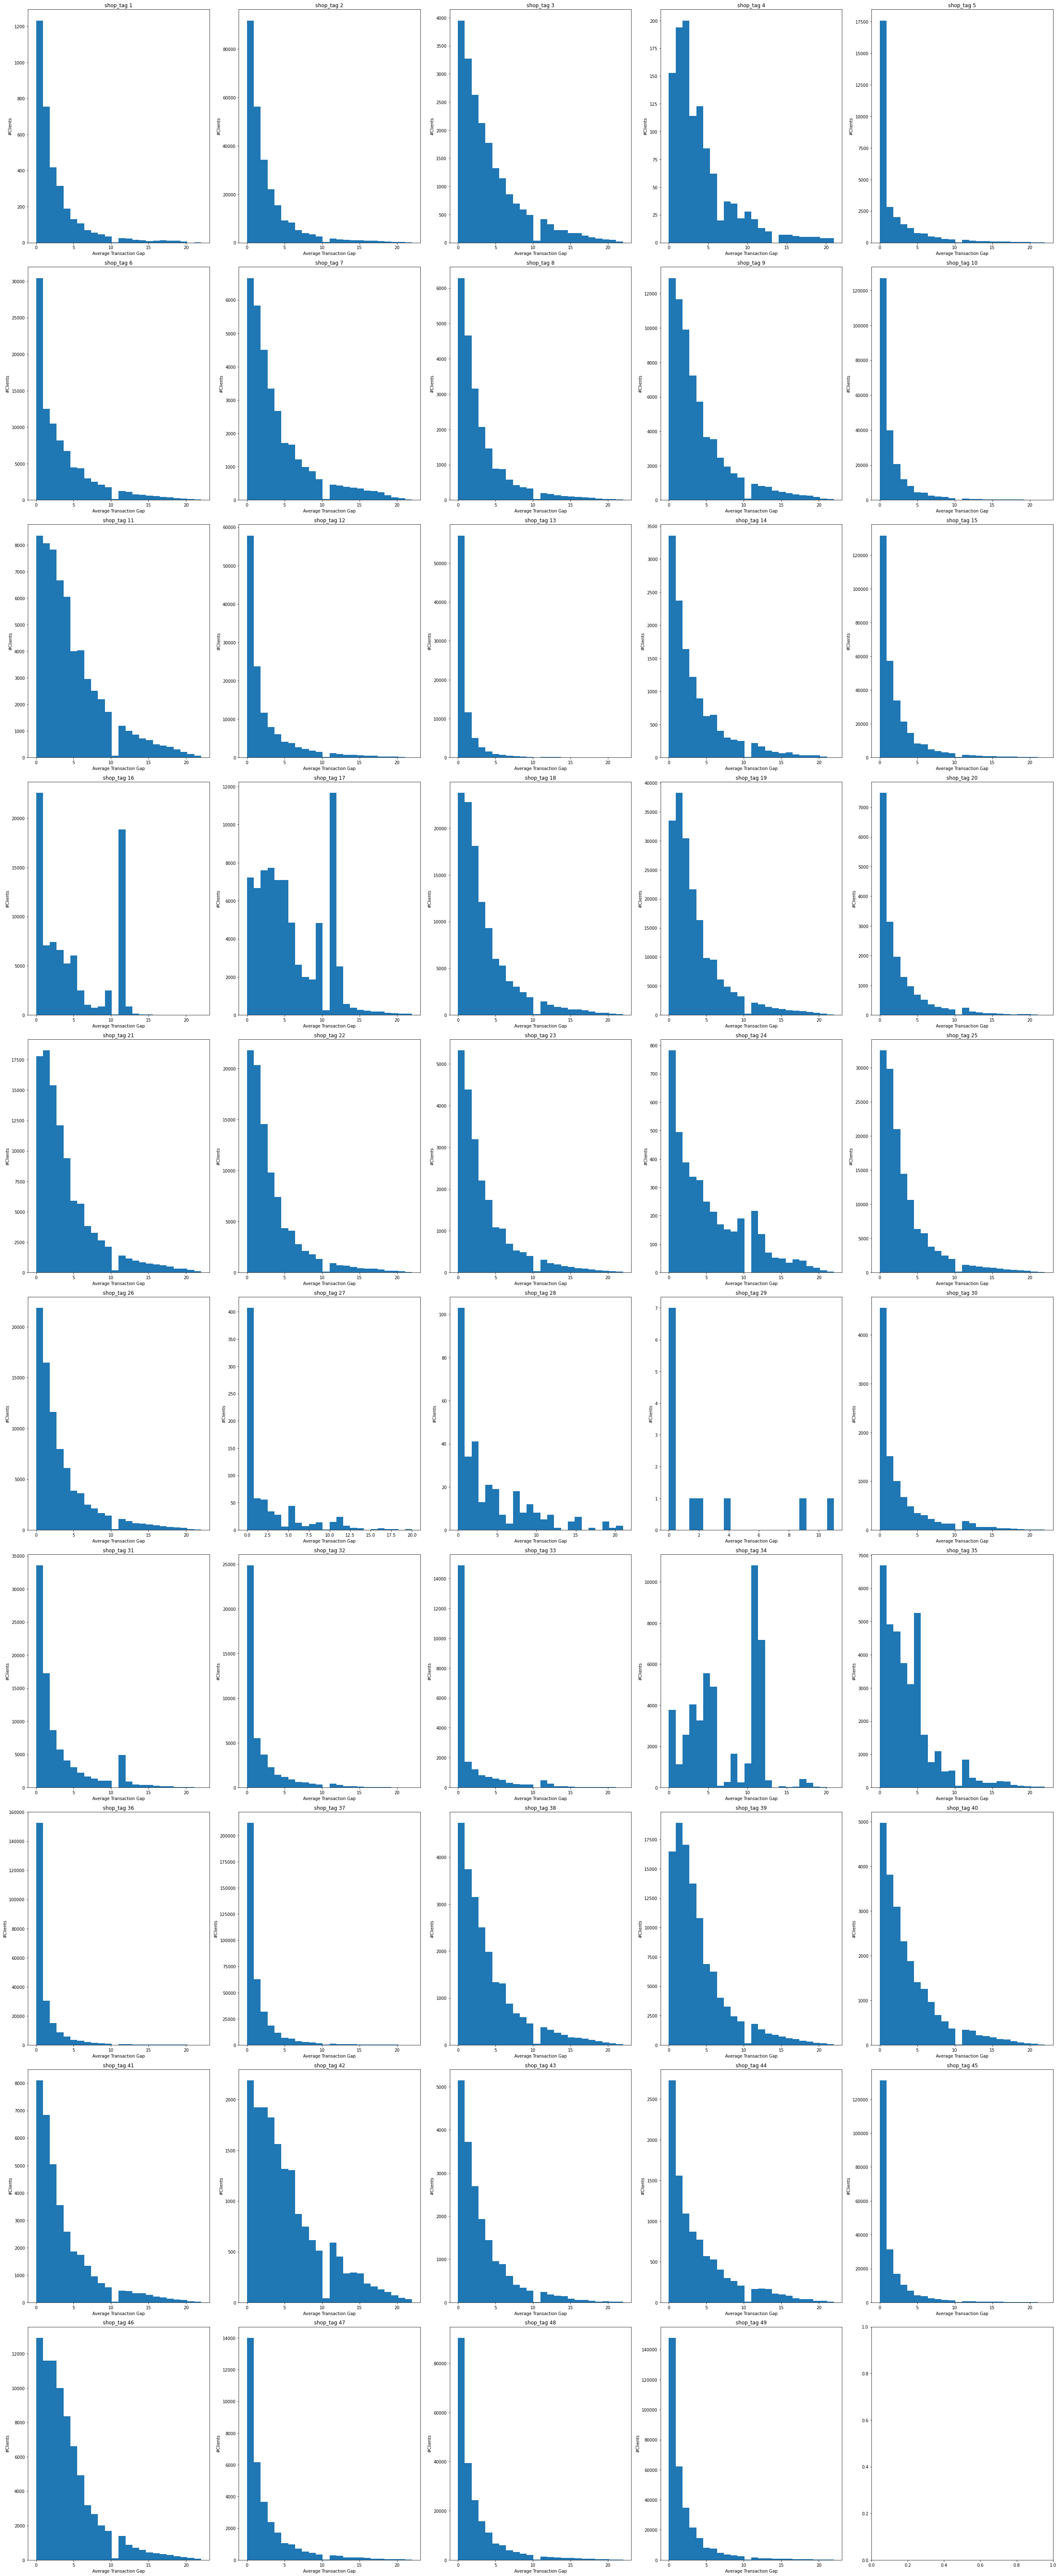

In [4]:
# Analyze transaction gap to see if the closer transaction 
# has the stronger effect on the next transaction basket
# txn_gap_vecs = get_txn_gap_vecs(df)
# with open("../data/processed/txn_gap_vecs.pkl", 'wb') as f:
#     pickle.dump(txn_gap_vecs, f)

# Load transaction gap vectors
with open("../data/processed/txn_gap_vecs.pkl", 'rb') as f:
    txn_gap_vecs = pickle.load(f)
    
n_cols = 5
fig, axs = plt.subplots(nrows= 10, ncols=n_cols, figsize=(35, 85))
for i in tqdm(range(N_SHOP_TAGS)):
    gaps = []
    for chid, txn_gap_vec in txn_gap_vecs.items():
        if txn_gap_vec[i] > 23:
            # Exclude the situations that there's no transaction
            # or only one appear in the records
            continue
        gaps.append(txn_gap_vec[i])
    axs[i//n_cols, i%n_cols].hist(x=gaps, bins=24)
    axs[i//n_cols, i%n_cols].set_title(f"shop_tag {i+1}")
    axs[i//n_cols, i%n_cols].set_xlabel(f"Average Transaction Gap")
    axs[i//n_cols, i%n_cols].set_ylabel("#Clients")
    del gaps
plt.tight_layout()

## c. Categorical Features
So far, I've not considered **categorical features** yet, which may contain rich information for me to use. The analysis will focus on observing how client attributes (*e.g.*, age, gender) affect other features.

### *Number of Client Attribute Vectors*
Observe number of client attribute vectors of each client, and analyze what's difference between these two groups.
#### Analysis and Observation 
##### *Two Groups - Static and Dynamic Client Attribute*
1. Most of clients (> 80%) have only one client vector. The maximum number is **6**, and only one client has 6 attribute vectors. 
2. Distributions of each numeric feature among two groups (static and dynamic client attribute vector) show significantly different **outlier** patterns. Moreover, observing distributions without outliers, I find that features related to `card_1`, `domestic_online` and `slam` behave differently among two groups.   
3. `shop_tag`s [2, 10, 12, 13, 37] show relatively obvious discrepancy among two groups, where 37 is the most significant.
4. Over 90% of clients in group with dynamic client attributes make their transaction at `dt==1`; that is, for those joining earlier, the client attribute vectors are easier to change as time goes.
5. Most clients in both groups make their last transactios at `dt==24`. And, dynamic group has relatively higher ratio at `dt==24`.

In [2]:
# Prepare data to use
df = pd.read_parquet("./data/raw/raw_data.parquet")
df.head(1)

dt      chid  shop_tag  txn_cnt      txn_amt  domestic_offline_cnt  \
0   1  10321418        45        3  3891.965283                     3   

   domestic_online_cnt  overseas_offline_cnt  overseas_online_cnt  \
0                    0                     0                    0   

   domestic_offline_amt_pct  domestic_online_amt_pct  \
0                       1.0                      0.0   

   overseas_offline_amt_pct  overseas_online_amt_pct  card_1_txn_cnt  \
0                       0.0                      0.0               0   

   card_2_txn_cnt  card_3_txn_cnt  card_4_txn_cnt  card_5_txn_cnt  \
0               0               0               3               0   

   card_6_txn_cnt  card_7_txn_cnt  card_8_txn_cnt  card_9_txn_cnt  \
0               0               0               0               0   

   card_10_txn_cnt  card_11_txn_cnt  card_12_txn_cnt  card_13_txn_cnt  \
0                0                0                0                0   

   card_14_txn_cnt  card_other_txn_cnt  card_1_txn_amt_pct  \
0                0                   0                 0.0   

   card_2_txn_amt_pct  card_3_txn_amt_pct  card_4_txn_amt_pct  \
0                 0.0                 0.0                 1.0   

   card_5_txn_amt_pct  card_6_txn_amt_pct  card_7_txn_amt_pct  \
0                 0.0                 0.0                 0.0   

   card_8_txn_amt_pct  card_9_txn_amt_pct  card_10_txn_amt_pct  \
0                 0.0                 0.0                  0.0   

   card_11_txn_amt_pct  card_12_txn_amt_pct  card_13_txn_amt_pct  \
0                  0.0                  0.0                  0.0   

   card_14_txn_amt_pct  card_other_txn_amt_pct  masts  educd  trdtp  naty  \
0                  0.0                     0.0      1      4      5     1   

   poscd  cuorg          slam  gender_code  age  primary_card  
0     99     30  95982.822967            1    4             1

In [3]:
# 1. Number of client attribute vectors per client
chid_gps = df[CLI_ATTRS].groupby(by=['chid'])
n_cli_attr_vecs = {}

for chid, gp in chid_gps:
    cli_attr_mat = gp.values
    n_cli_attr_vec = np.unique(cli_attr_mat, axis=0)
    n_cli_attr_vecs[chid] = n_cli_attr_vec.shape[0]

n_cli_attr_vecs = pd.DataFrame.from_dict(n_cli_attr_vecs, orient='index')
print(f"Max #client attribute vectors for a single client {np.max(n_cli_attr_vecs.values)} | Min {np.min(n_cli_attr_vecs.values)}")
del chid_gps
gc.collect()

Max #client attribute vectors for a single client 6 | Min 1


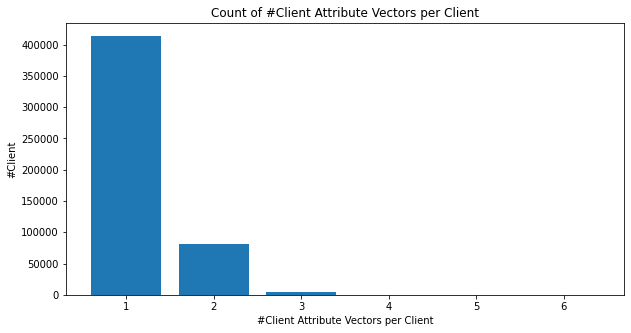

Cnt: [413960  80796   4962    269     12      1]
Pct: [8.27920e-01 1.61592e-01 9.92400e-03 5.38000e-04 2.40000e-05 2.00000e-06]


In [5]:
# 1. (cont.)
val_cnts = n_cli_attr_vecs.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=[cnt for cnt in range(1, 7)], height=val_cnts.values)
ax.set_title("Count of #Client Attribute Vectors per Client")
ax.set_xlabel("#Client Attribute Vectors per Client")
ax.set_ylabel("#Client")
plt.show()
print(f"Cnt: {np.array(val_cnts)}")
print(f"Pct: {np.array(val_cnts) / N_CLIENTS}")

In [6]:
# 1. (cont.) 
# Analyze clients with dynamic client attribute vectors
chids_with_dyn_cli_attr = n_cli_attr_vecs[n_cli_attr_vecs[0] > 1].index.values
print(f"#Clients with dynamic client attribute vectors {len(chids_with_dyn_cli_attr)}")

#Clients with dynamic client attribute vectors 86040


In [27]:
# 2. Distributions of numeric features among two groups
# Split clients into two groups, one with dynamic client attributes, the other static
df['cli_attr_dyn'] = np.where(np.isin(df['chid'].values, chids_with_dyn_cli_attr), 1, 0)
assert df[df['cli_attr_dyn'] == 1]['chid'].nunique() == 86040

41it [01:06,  1.62s/it]


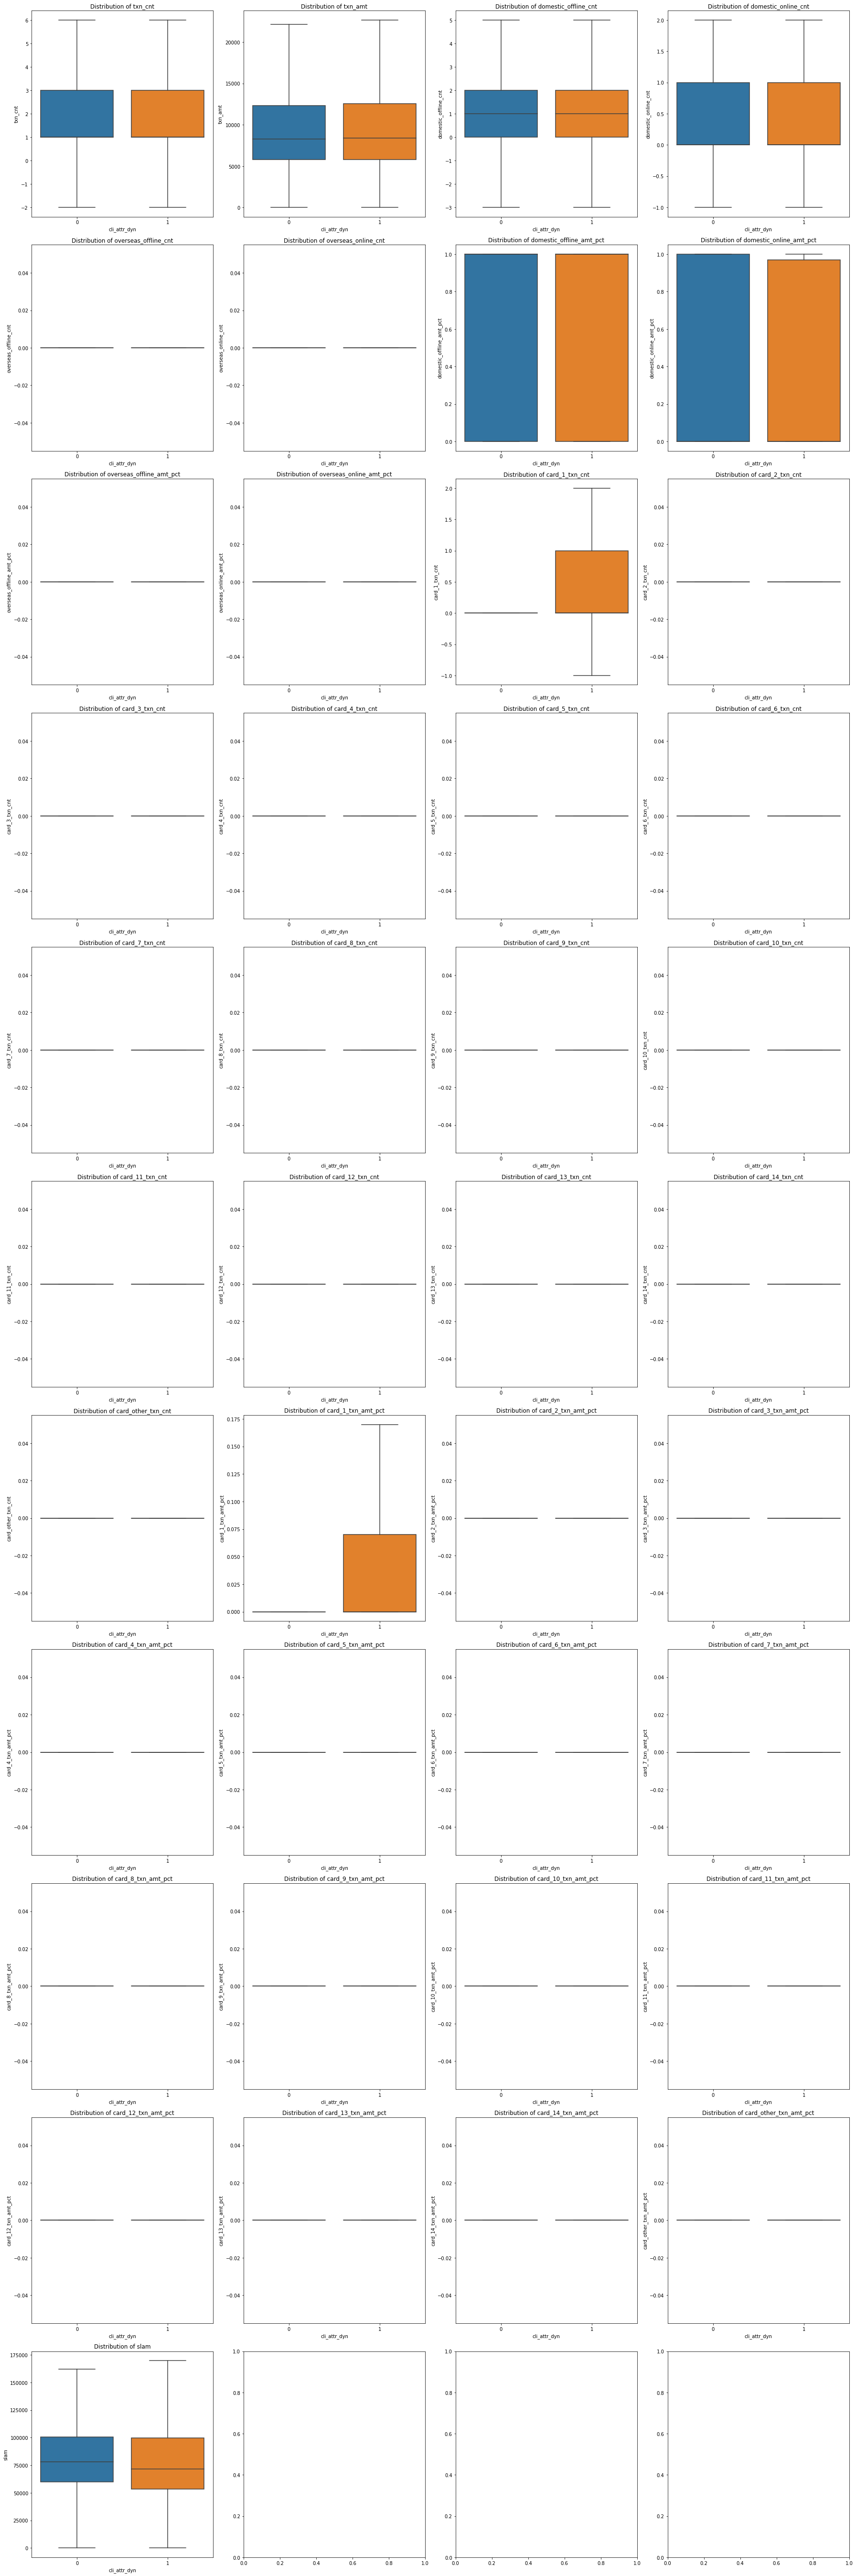

In [28]:
# 2. (cont.)
numeric_feats = [col for col in COLS if col not in CAT_FEATURES]

n_cols = 4
fig, axs = plt.subplots(nrows=11, ncols=n_cols, figsize=(25, 75))
for i, f in tqdm(enumerate(numeric_feats)):
    df_ = df[['cli_attr_dyn', f]]
    sns.boxplot(x='cli_attr_dyn', y=f, data=df_, showfliers=False,
                ax=axs[i//n_cols, i%n_cols])
    axs[i//n_cols, i%n_cols].set_title(f"Distribution of {f}")
    del df_
plt.tight_layout()

41it [01:08,  1.68s/it]


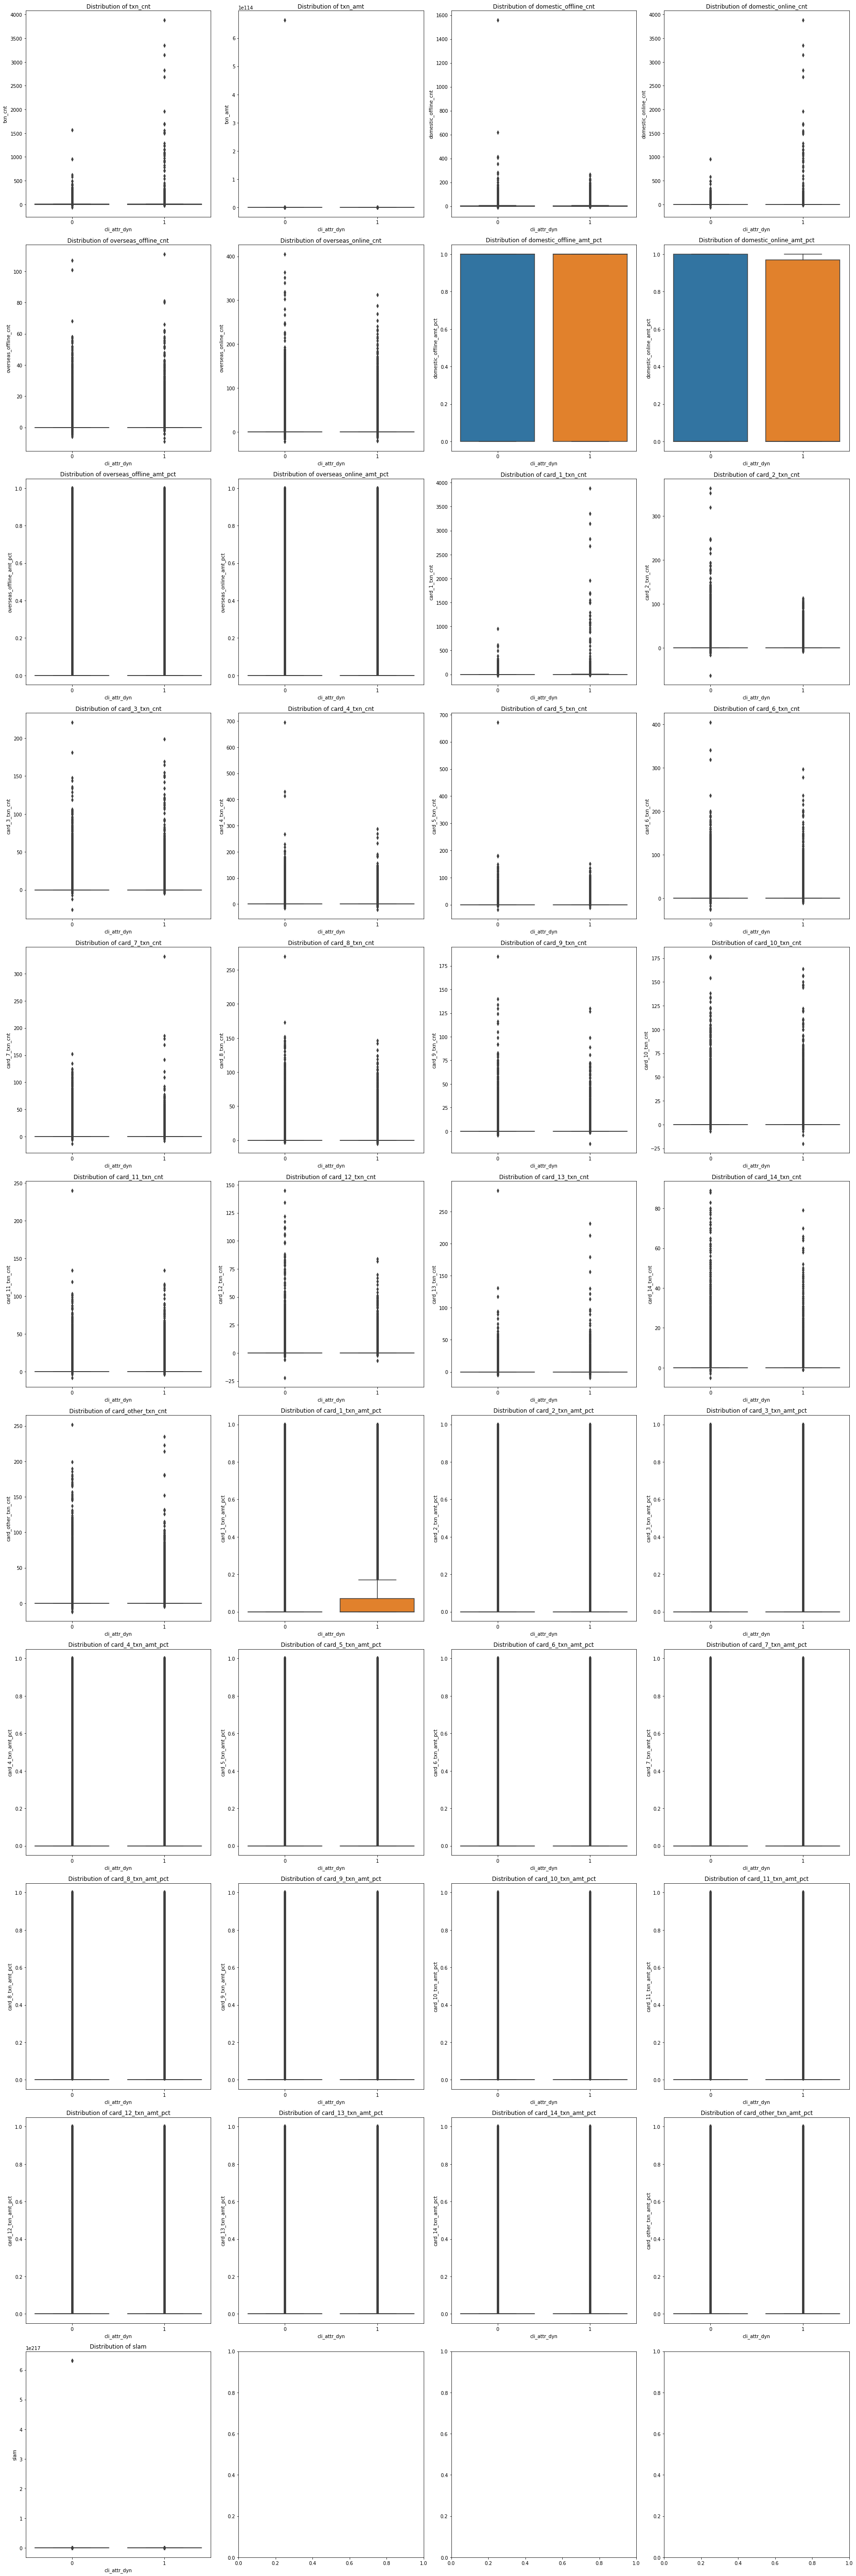

In [29]:
# 2. (cont.)
fig, axs = plt.subplots(nrows=11, ncols=n_cols, figsize=(25, 75))
for i, f in tqdm(enumerate(numeric_feats)):
    df_ = df[['cli_attr_dyn', f]]
    sns.boxplot(x='cli_attr_dyn', y=f, data=df_, showfliers=True,
                ax=axs[i//n_cols, i%n_cols])
    axs[i//n_cols, i%n_cols].set_title(f"Distribution of {f}")
    del df_
plt.tight_layout()

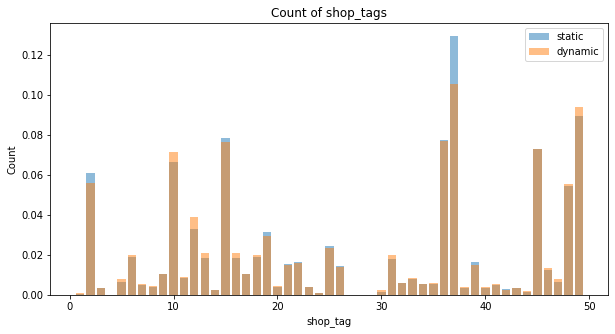

In [37]:
# 3. `shop_tag` discrepancy among two groups
shop_tag_cnts_st_gp = df[df['cli_attr_dyn'] == 0]['shop_tag'].value_counts().sort_index()
shop_tag_cnts_dyn_gp = df[df['cli_attr_dyn'] == 1]['shop_tag'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=SHOP_TAGS_, height=shop_tag_cnts_st_gp.values / shop_tag_cnts_st_gp.sum(), alpha=0.5, label='static')
ax.bar(x=SHOP_TAGS_, height=shop_tag_cnts_dyn_gp.values / shop_tag_cnts_dyn_gp.sum(), alpha=0.5, label='dynamic')
ax.set_title("Count of shop_tags")
ax.set_xlabel("shop_tag")
ax.set_ylabel("Count")
ax.legend()
plt.show()

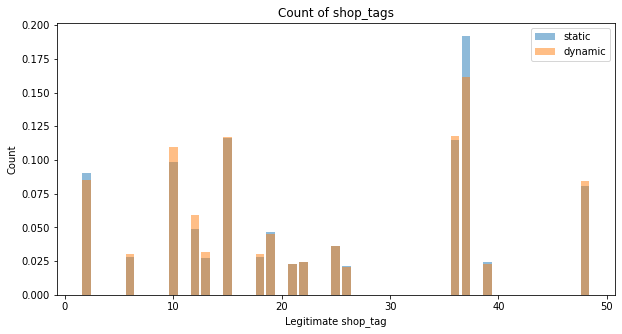

In [39]:
# 3. (cont.)
leg_shop_tag_cnts_st_gp = shop_tag_cnts_st_gp.values[LEG_SHOP_TAGS_INDICES]
leg_shop_tag_cnts_dyn_gp = shop_tag_cnts_dyn_gp.values[LEG_SHOP_TAGS_INDICES]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=LEG_SHOP_TAGS, height=leg_shop_tag_cnts_st_gp / leg_shop_tag_cnts_st_gp.sum(), alpha=0.5, label='static')
ax.bar(x=LEG_SHOP_TAGS, height=leg_shop_tag_cnts_dyn_gp / leg_shop_tag_cnts_dyn_gp.sum(), alpha=0.5, label='dynamic')
ax.set_title("Count of shop_tags")
ax.set_xlabel("Legitimate shop_tag")
ax.set_ylabel("Count")
ax.legend()
plt.show()

del shop_tag_cnts_st_gp, shop_tag_cnts_dyn_gp
gc.collect()

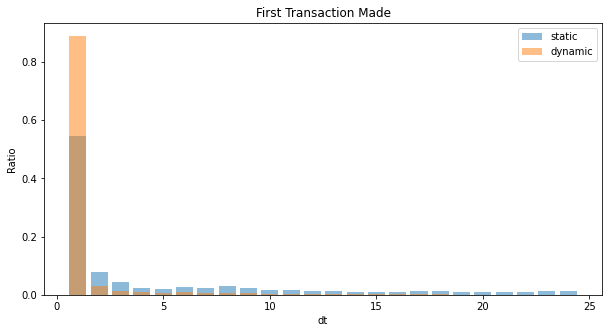

In [45]:
# 4. First txn made 
first_txn_st = (df[df['cli_attr_dyn'] == 0].groupby('chid')['dt']
                                           .min().value_counts().sort_index())
first_txn_dyn = (df[df['cli_attr_dyn'] == 1].groupby('chid')['dt']
                                            .min().value_counts().sort_index())
first_txn_ratios_st = first_txn_st.values / first_txn_st.sum()
first_txn_ratios_dyn = first_txn_dyn.values / first_txn_dyn.sum()
first_txn_ratios_dyn = np.insert(first_txn_ratios_dyn, 23, 0)   # Client joining at dt==24 must have static cli attr

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=DTS, height=first_txn_ratios_st, alpha=0.5, label='static')
ax.bar(x=DTS, height=first_txn_ratios_dyn, alpha=0.5, label='dynamic')
ax.set_title("First Transaction Made")
ax.set_xlabel("dt")
ax.set_ylabel("Ratio")
ax.legend()
plt.show()

del first_txn_st, first_txn_dyn
gc.collect()

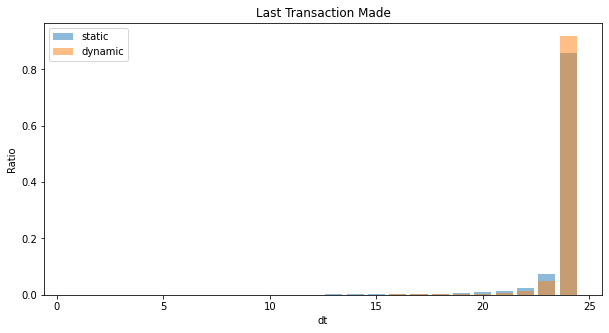

55391

In [50]:
# 5. Last txn made 
last_txn_st = (df[df['cli_attr_dyn'] == 0].groupby('chid')['dt']
                                           .max().value_counts().reindex(DTS, fill_value=0))
last_txn_dyn = (df[df['cli_attr_dyn'] == 1].groupby('chid')['dt']
                                            .max().value_counts().reindex(DTS, fill_value=0))
last_txn_ratios_st = last_txn_st.values / last_txn_st.sum()
last_txn_ratios_dyn = last_txn_dyn.values / last_txn_dyn.sum()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=DTS, height=last_txn_ratios_st, alpha=0.5, label='static')
ax.bar(x=DTS, height=last_txn_ratios_dyn, alpha=0.5, label='dynamic')
ax.set_title("Last Transaction Made")
ax.set_xlabel("dt")
ax.set_ylabel("Ratio")
ax.legend()
plt.show()

del last_txn_st, last_txn_dyn
gc.collect()

In [7]:
# Sub DataFrame of the client having 6 client attr. vec.
chid_with_6_cli_attrs = n_cli_attr_vecs[n_cli_attr_vecs[0] == 6].index.values[0]
df_10021604 = df[df['chid'] == chid_with_6_cli_attrs]
df_10021604.head()

dt      chid  shop_tag  txn_cnt       txn_amt  domestic_offline_cnt  \
23404    1  10021604        10        1  18357.611764                     0   
186200   2  10021604        10        1   2215.814607                     0   
186208   2  10021604        37        1  10173.700632                     1   
657838  10  10021604        10        2  13811.563465                     0   
657845  10  10021604        13        3  11338.095896                     0   

        domestic_online_cnt  overseas_offline_cnt  overseas_online_cnt  \
23404                     1                     0                    0   
186200                    0                     0                    1   
186208                    0                     0                    0   
657838                    2                     0                    0   
657845                    0                     0                    3   

        domestic_offline_amt_pct  domestic_online_amt_pct  \
23404                        0.0                      1.0   
186200                       0.0                      0.0   
186208                       1.0                      0.0   
657838                       0.0                      1.0   
657845                       0.0                      0.0   

        overseas_offline_amt_pct  overseas_online_amt_pct  card_1_txn_cnt  \
23404                        0.0                      0.0               0   
186200                       0.0                      1.0               0   
186208                       0.0                      0.0               0   
657838                       0.0                      0.0               0   
657845                       0.0                      1.0               0   

        card_2_txn_cnt  card_3_txn_cnt  card_4_txn_cnt  card_5_txn_cnt  \
23404                0               0               1               0   
186200               0               0               1               0   
186208               0               0               1               0   
657838               0               0               0               0   
657845               0               0               0               0   

        card_6_txn_cnt  card_7_txn_cnt  card_8_txn_cnt  card_9_txn_cnt  \
23404                0               0               0               0   
186200               0               0               0               0   
186208               0               0               0               0   
657838               0               0               0               0   
657845               0               0               0               0   

        card_10_txn_cnt  card_11_txn_cnt  card_12_txn_cnt  card_13_txn_cnt  \
23404                 0                0                0                0   
186200                0                0                0                0   
186208                0                0                0                0   
657838                2                0                0                0   
657845                3                0                0                0   

        card_14_txn_cnt  card_other_txn_cnt  card_1_txn_amt_pct  \
23404                 0                   0                 0.0   
186200                0                   0                 0.0   
186208                0                   0                 0.0   
657838                0                   0                 0.0   
657845                0                   0                 0.0   

        card_2_txn_amt_pct  card_3_txn_amt_pct  card_4_txn_amt_pct  \
23404                  0.0                 0.0                 1.0   
186200                 0.0                 0.0                 1.0   
186208                 0.0                 0.0                 1.0   
657838                 0.0                 0.0                 0.0   
657845                 0.0                 0.0                 0.0   

        card_5_txn_amt_pct  card_6_txn_amt_pct  card_7_txn_amt_pct  \
23404

### *Groupby Each Client Attribute*
In this section, fine-grained analysis is done by grouping samples using different client attributes (*e.g.*, age, education). 
#### Analysis and Observation 
##### *Fine-grained Cli-Attr*
1. Numeric feature distributions show rich information when grouping feature values by different client attributes. Hence, I think it's promising to fuse this information into **feature engineering**.

In [3]:
numeric_feats = [col for col in COLS if col not in CAT_FEATURES]

In [2]:
# 1. 
def plot_box_single_attr(attr, showfliers, n_cols=4):
    '''Plot box plot by splitting samples using only one specified attr
    as groupby key.
    '''
    n_rows = (len(numeric_feats) // n_cols) + 1
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, len(numeric_feats)*2-8))
    for i, f in tqdm(enumerate(numeric_feats)):
        df_ = df[[attr, f]]
        sns.boxplot(x=attr, y=f, data=df_, showfliers=showfliers,
                    ax=axs[i//n_cols, i%n_cols])
        axs[i//n_cols, i%n_cols].set_title(f"Distribution of {f}")
        del df_
    plt.tight_layout()

41it [01:04,  1.58s/it]


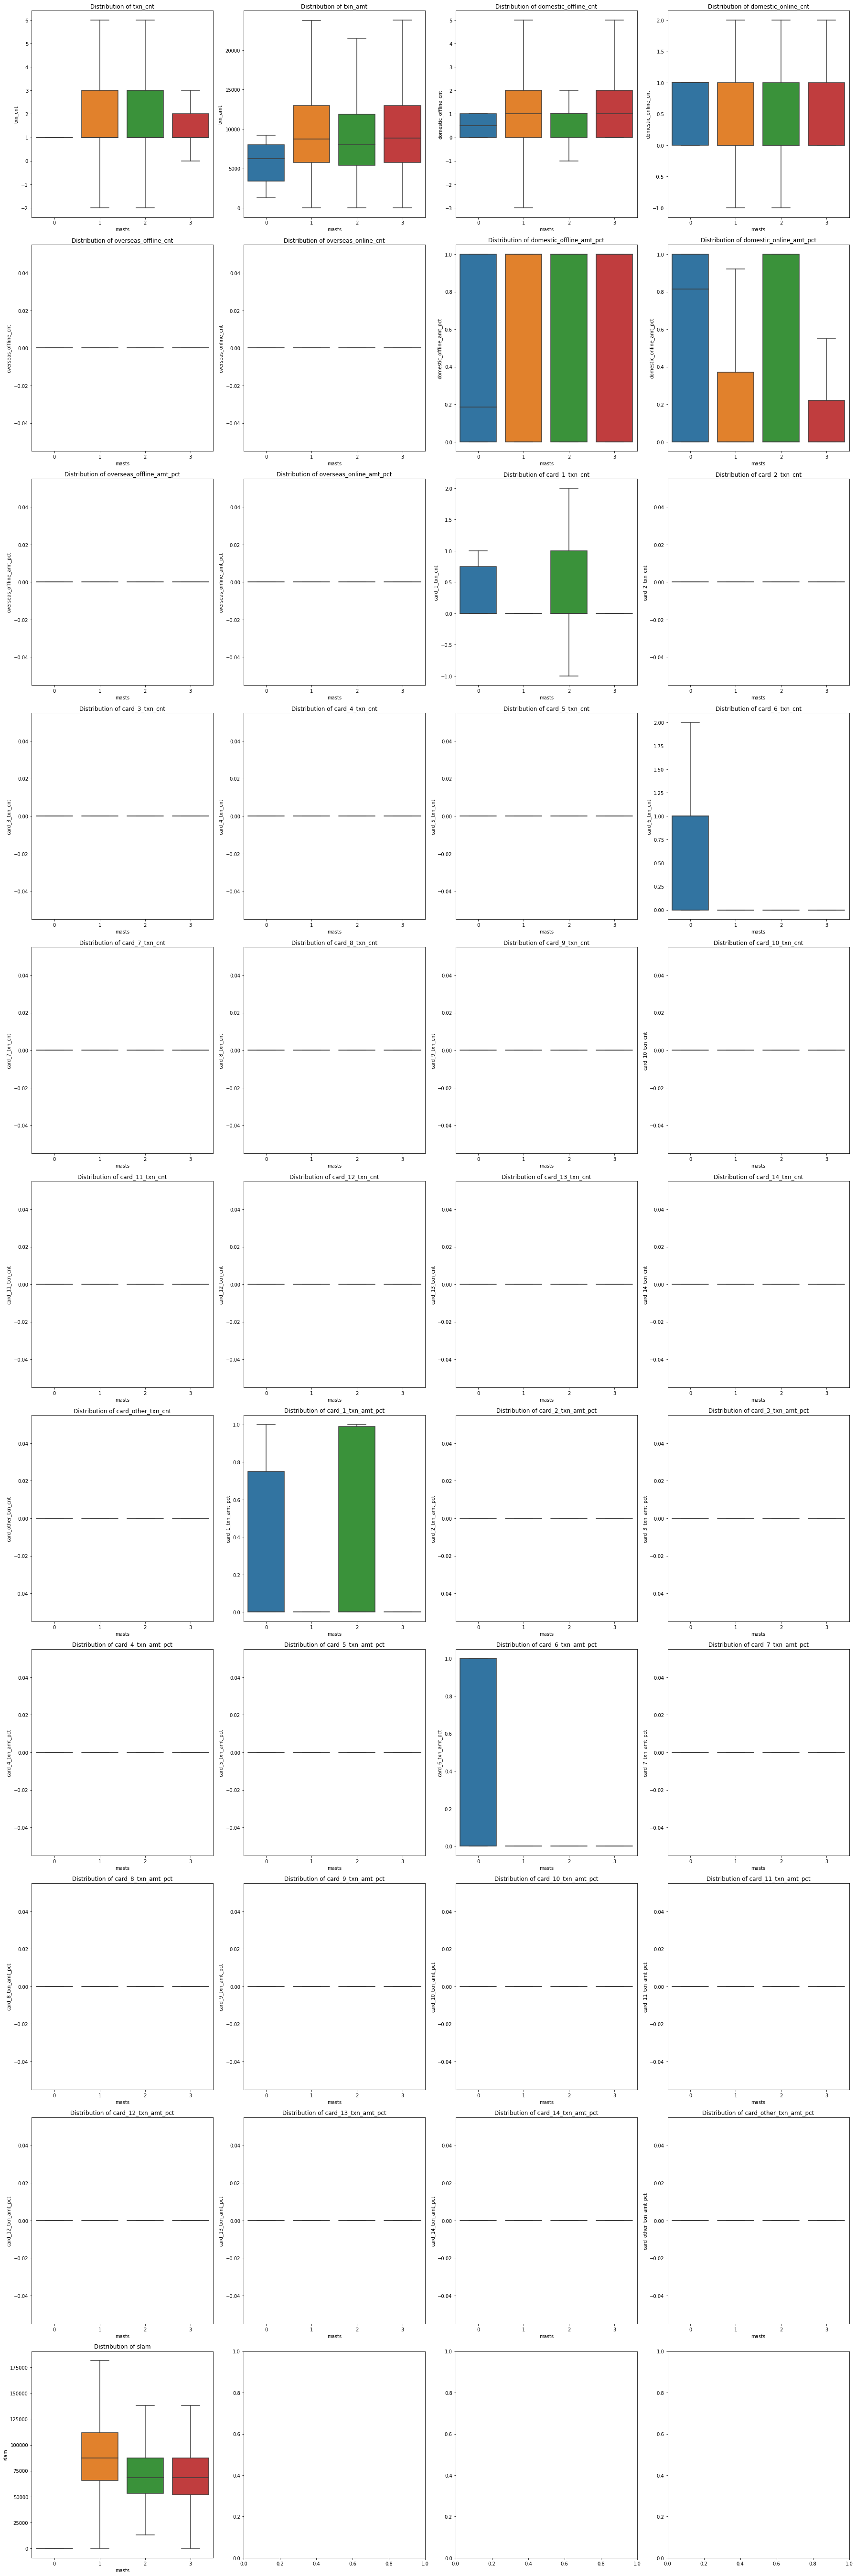

In [5]:
plot_box_single_attr('masts', showfliers=False)

41it [01:06,  1.61s/it]


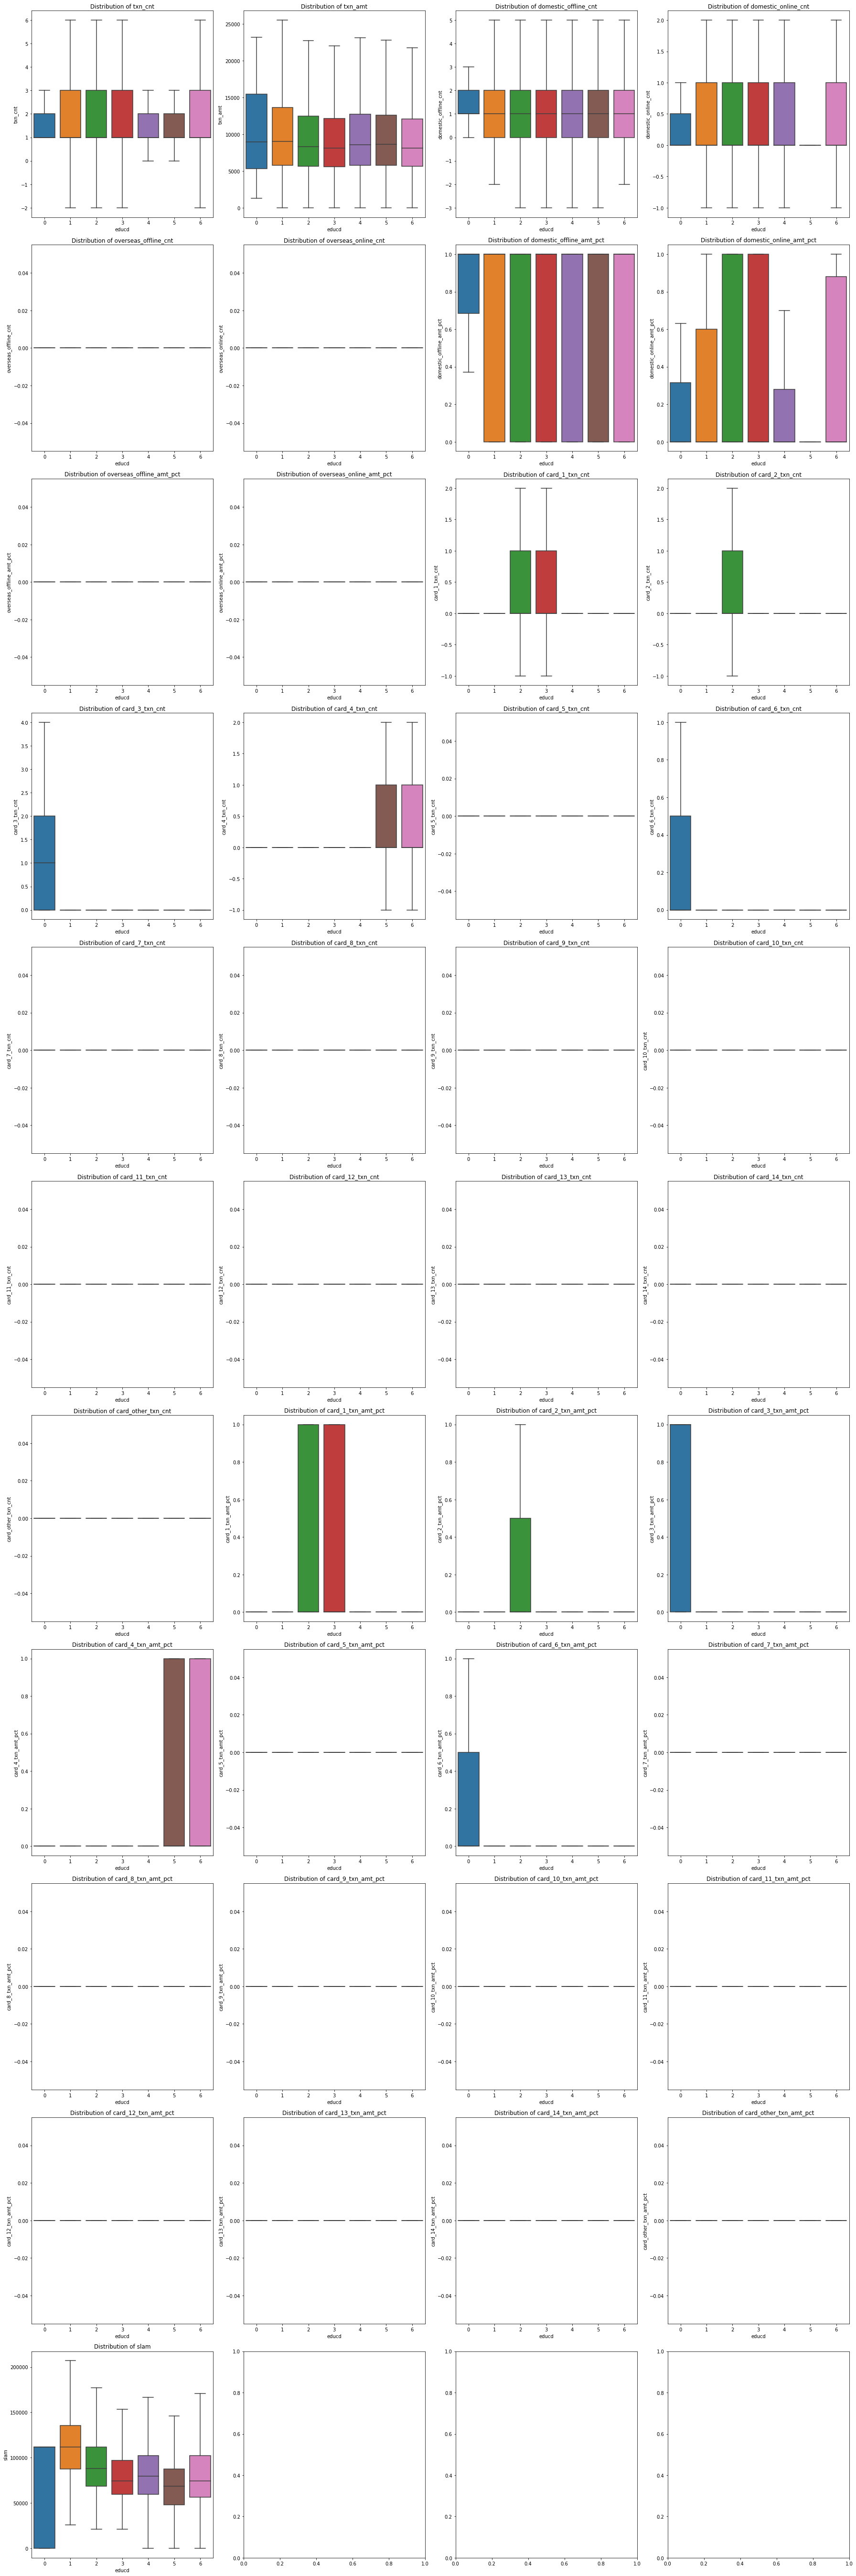

In [54]:
plot_box_single_attr('educd', showfliers=False)

41it [01:15,  1.83s/it]


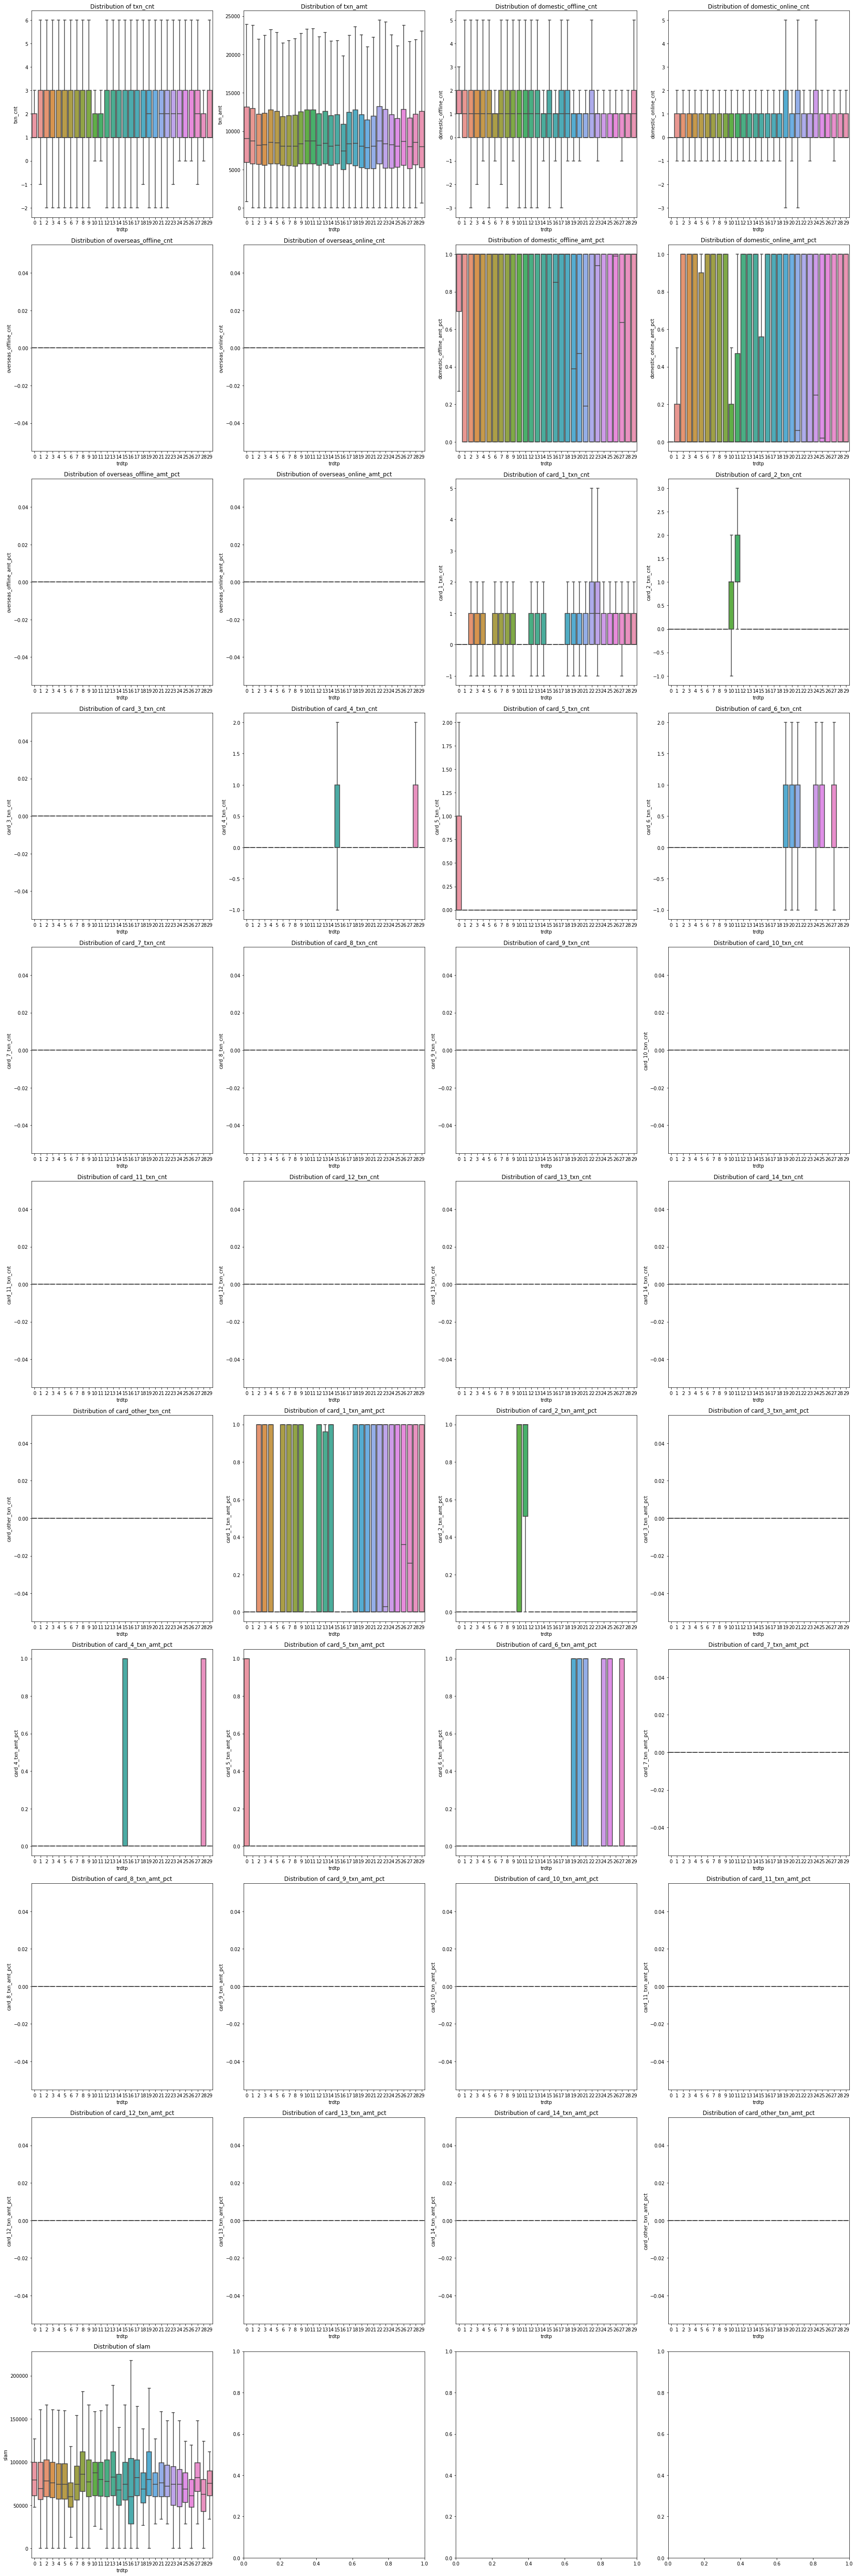

In [55]:
plot_box_single_attr('trdtp', showfliers=False)

41it [01:00,  1.47s/it]


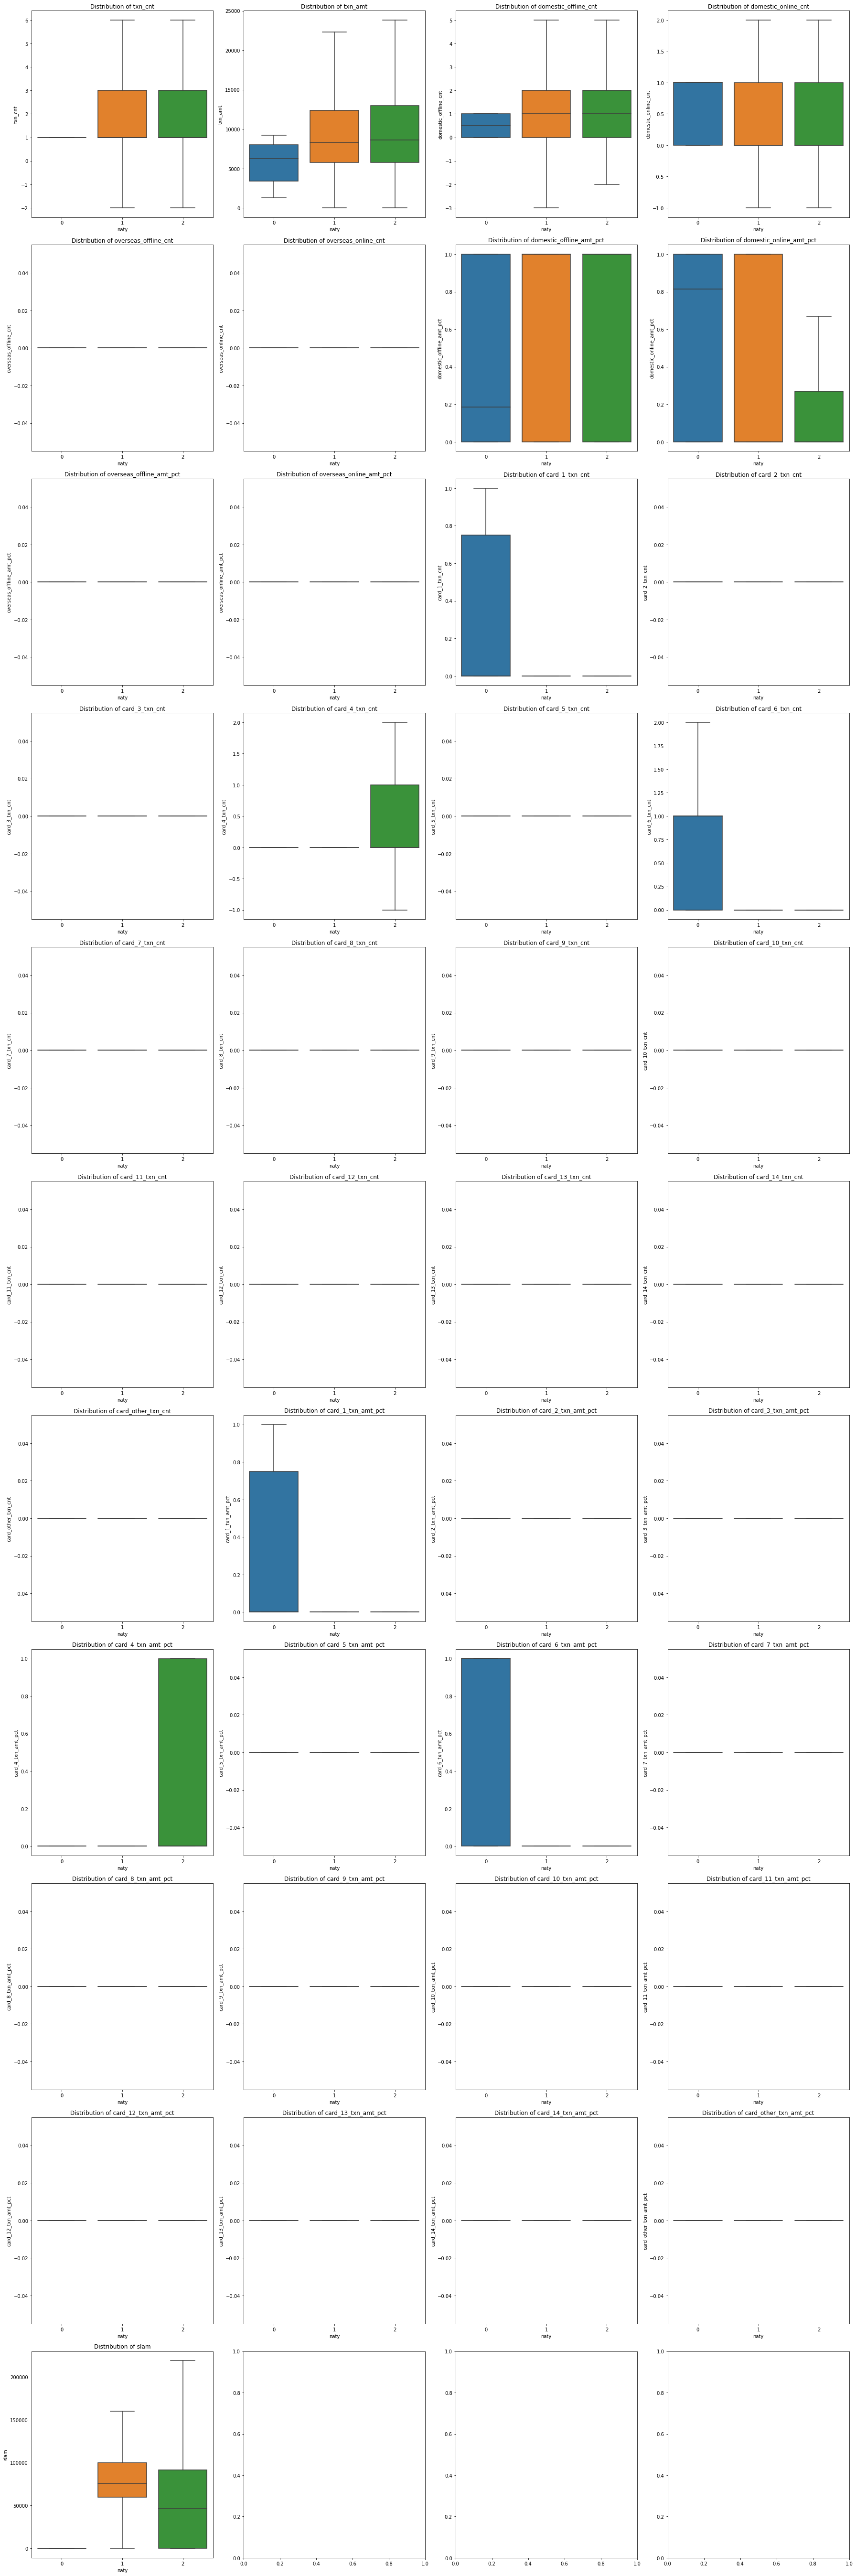

In [56]:
plot_box_single_attr('naty', showfliers=False)

41it [01:08,  1.66s/it]


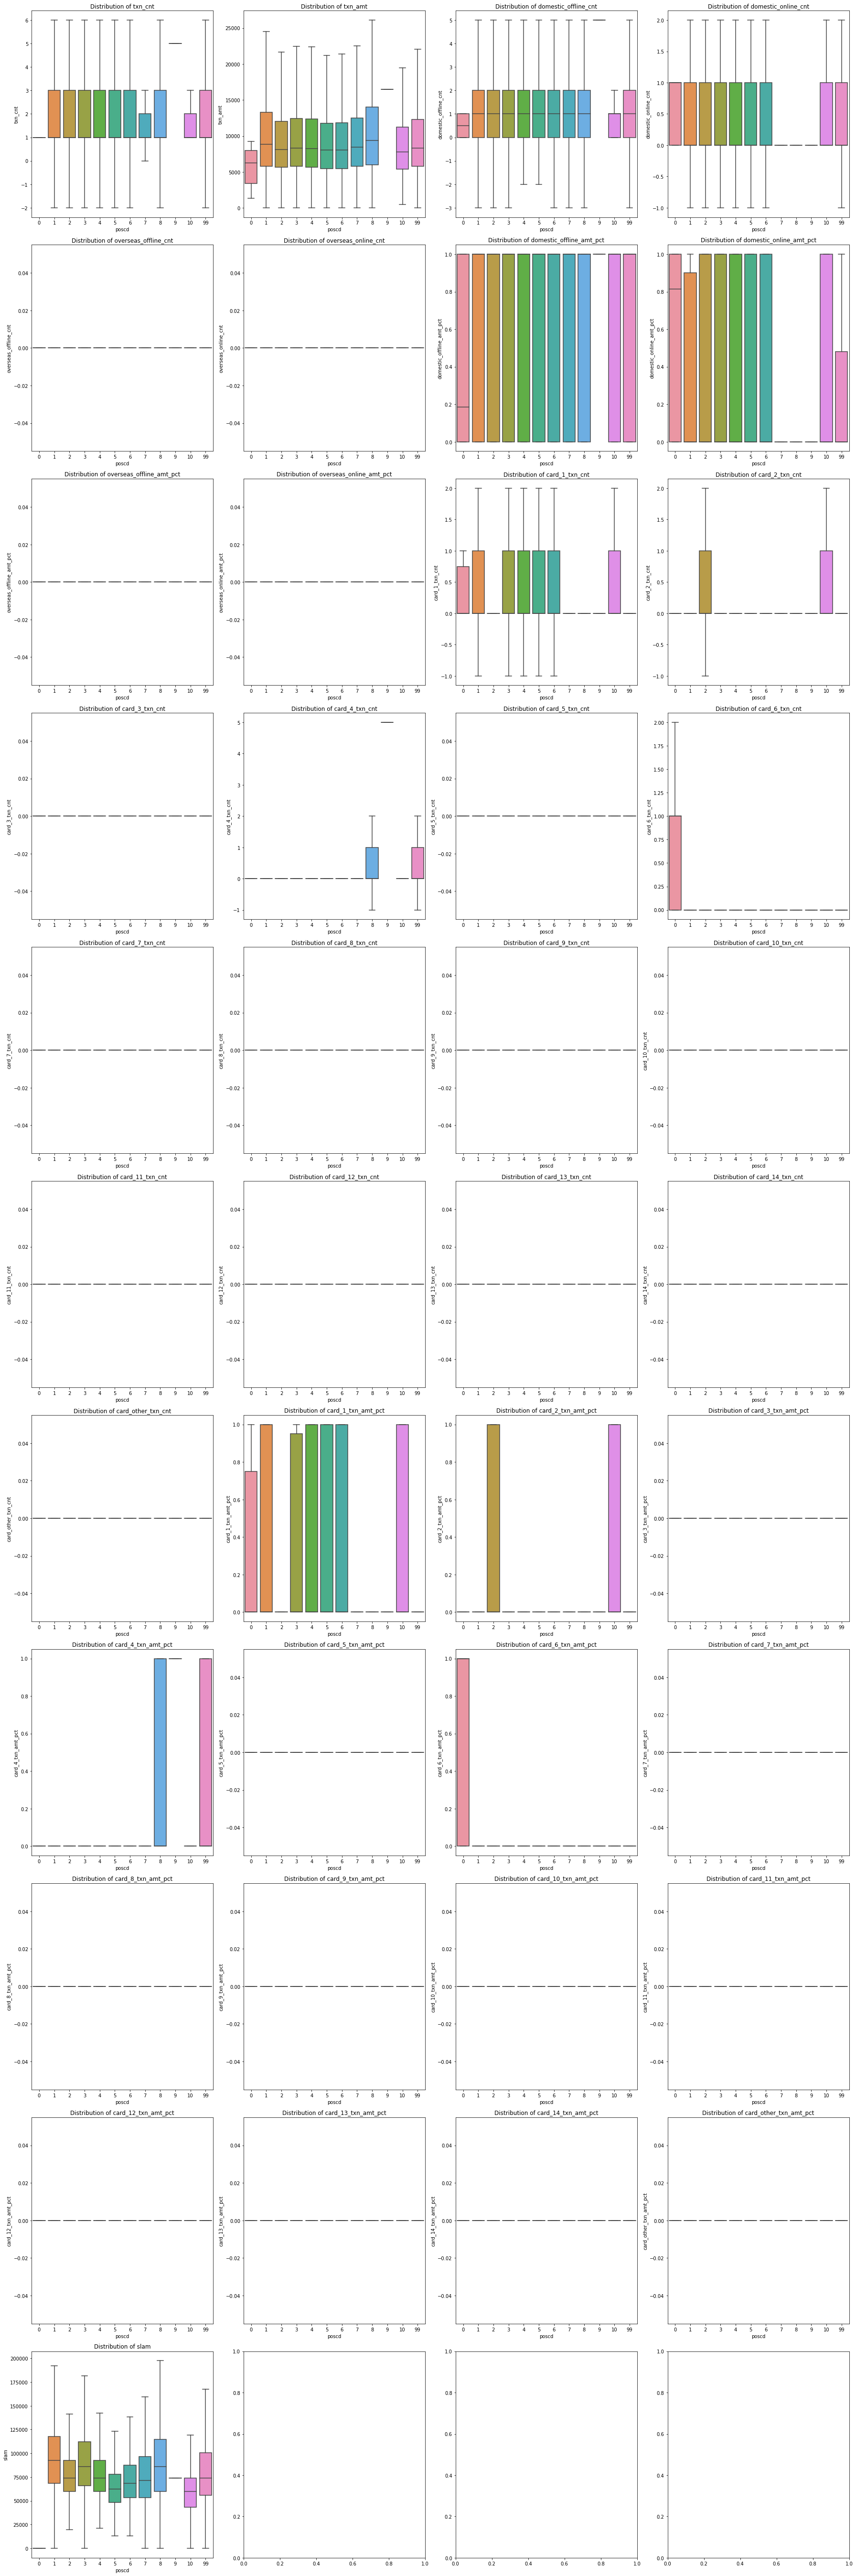

In [57]:
plot_box_single_attr('poscd', showfliers=False)

41it [01:06,  1.62s/it]


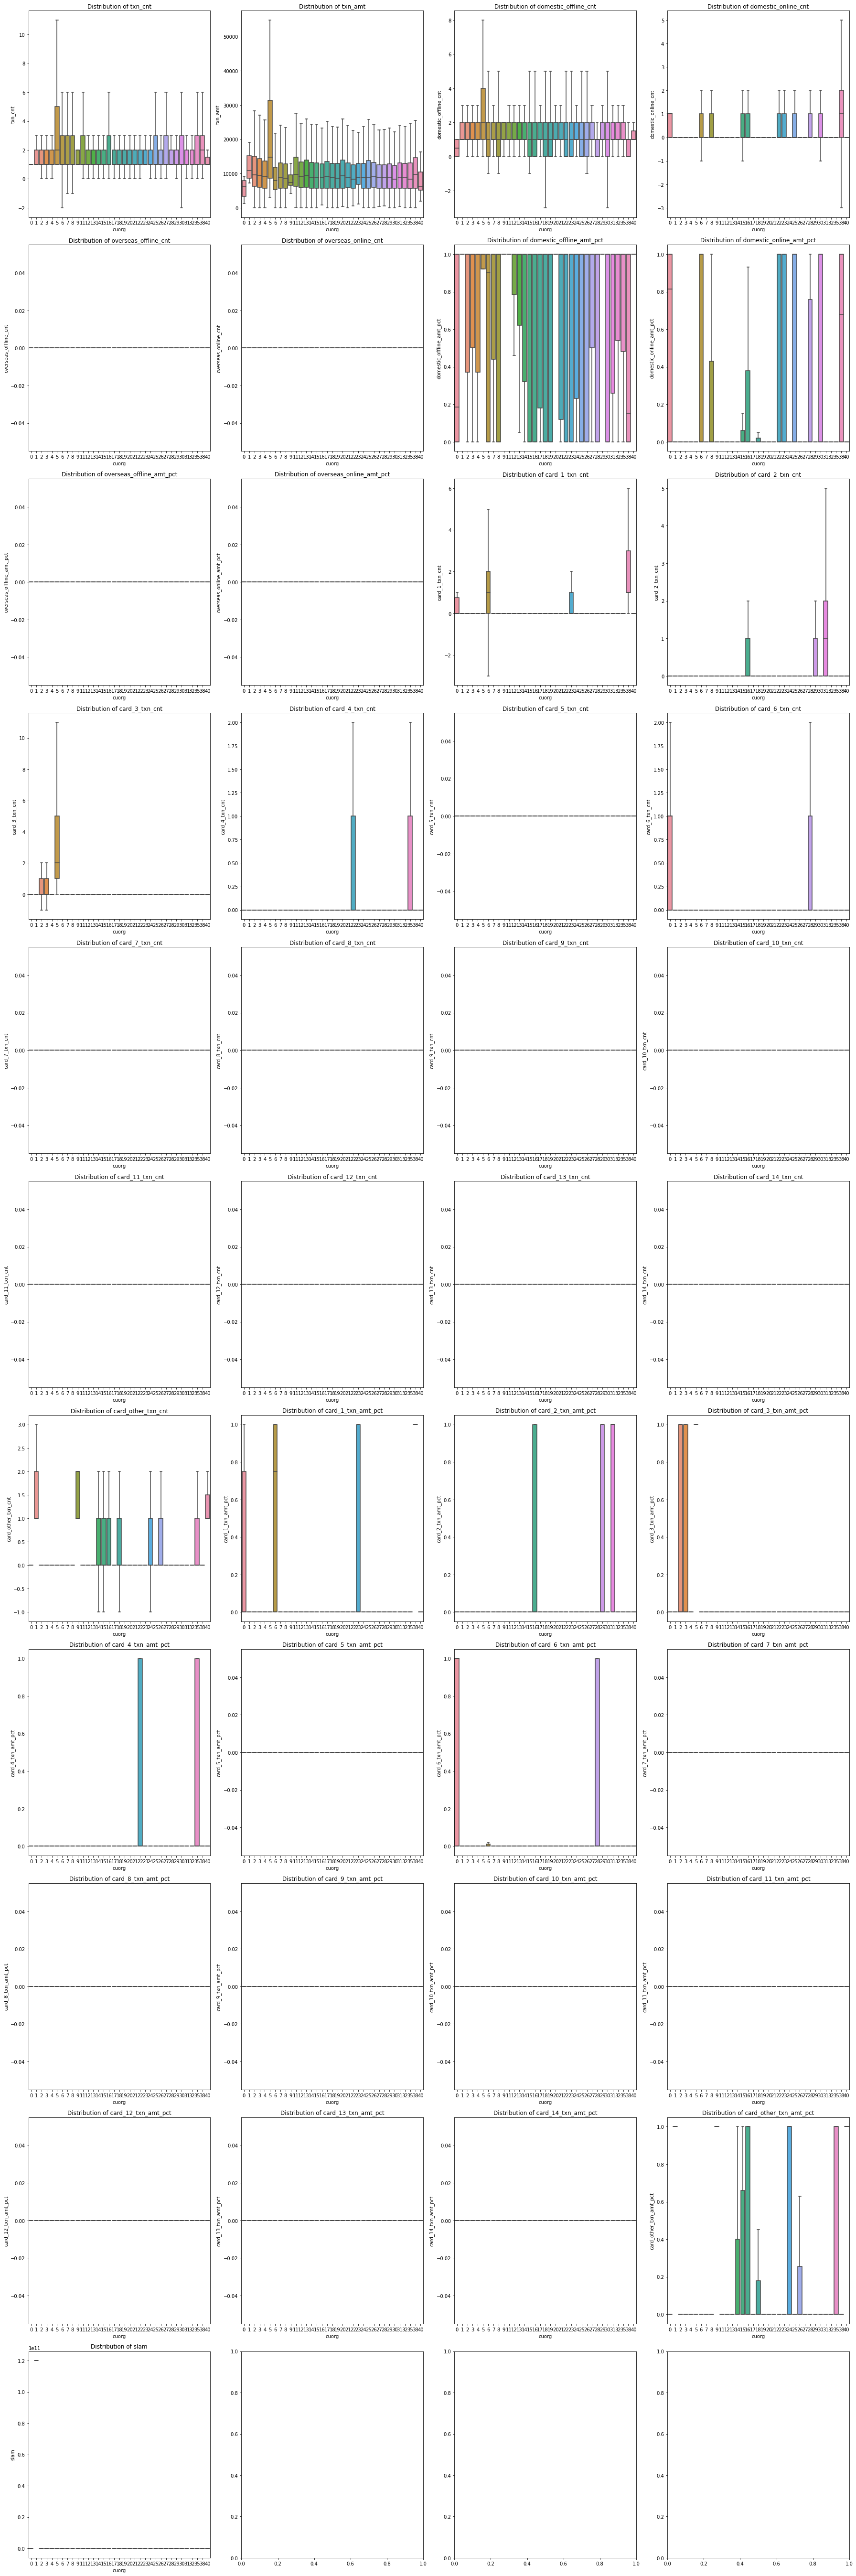

In [58]:
plot_box_single_attr('cuorg', showfliers=False)

41it [01:01,  1.50s/it]


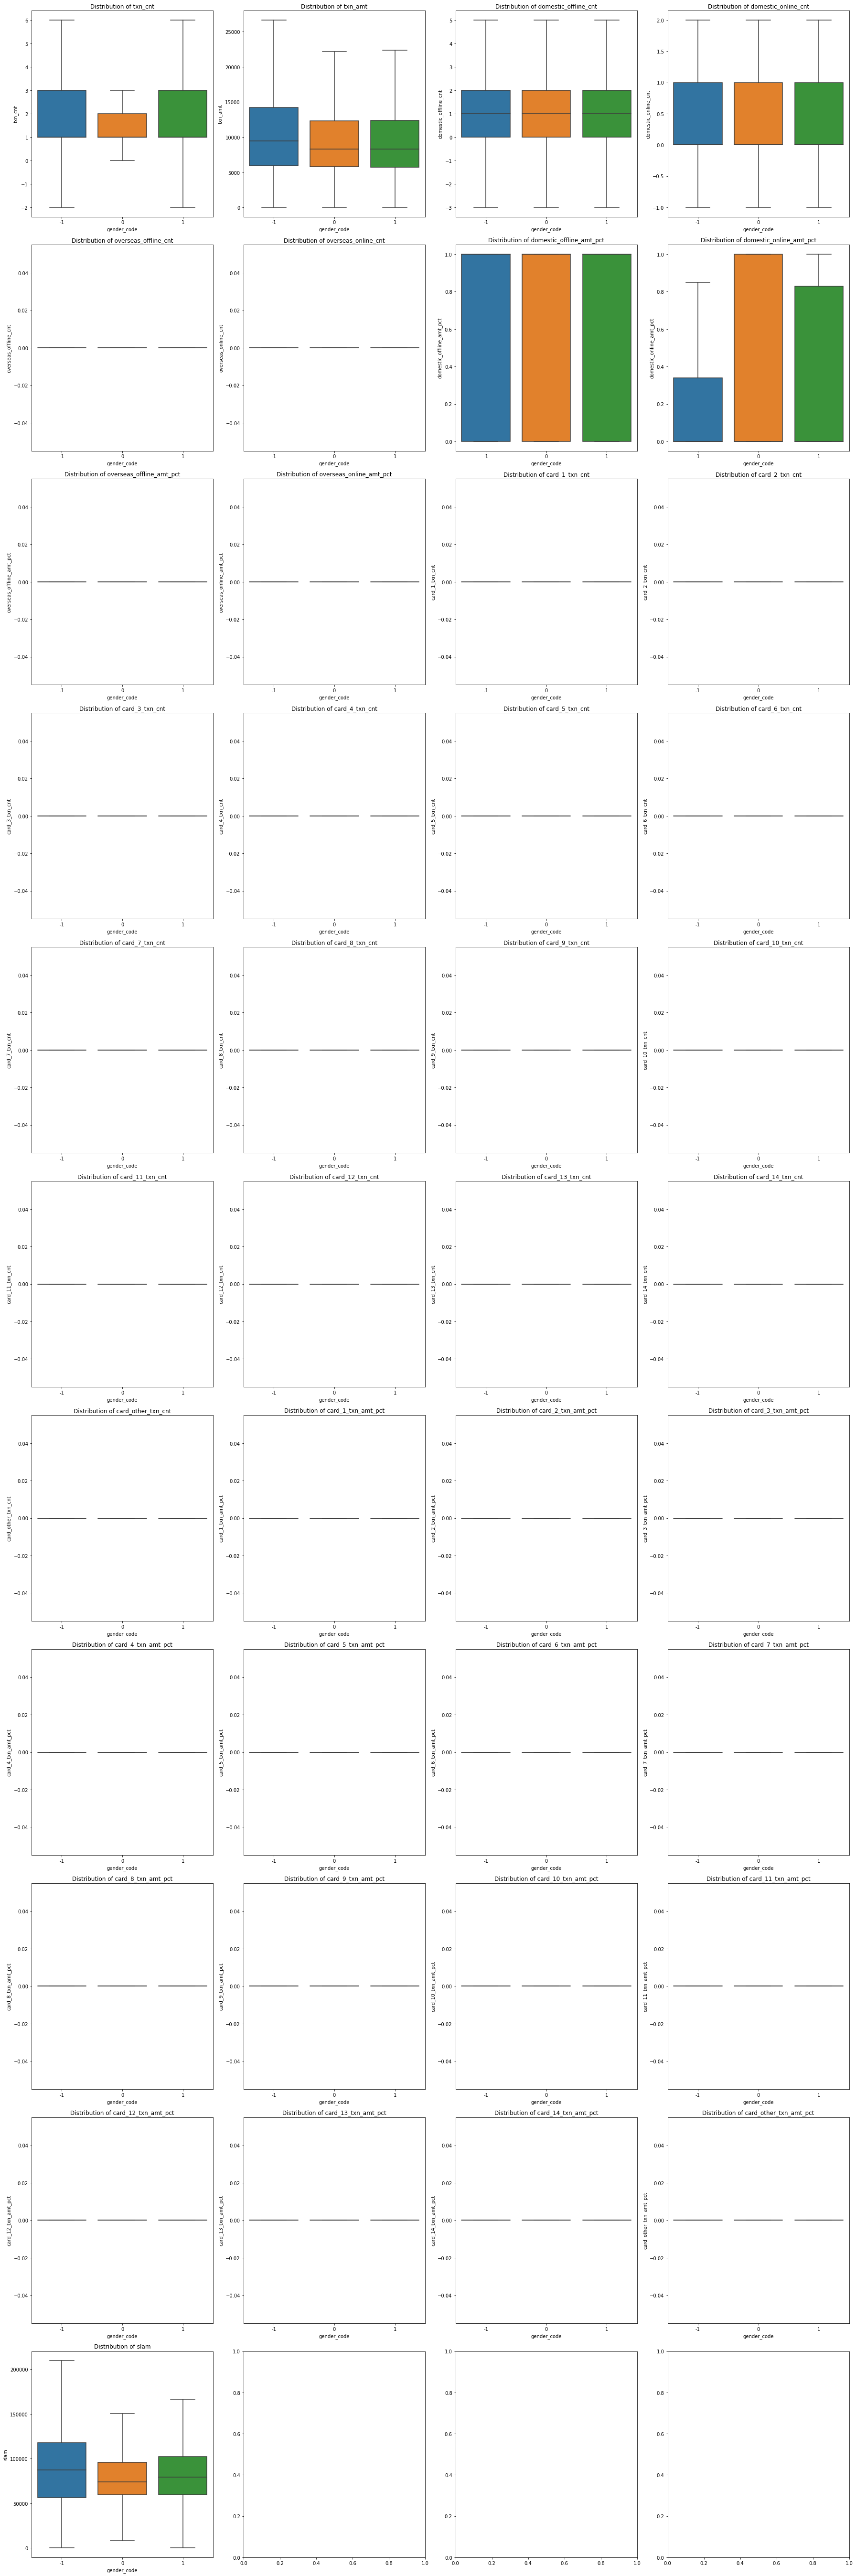

In [59]:
plot_box_single_attr('gender_code', showfliers=False)

41it [01:07,  1.64s/it]


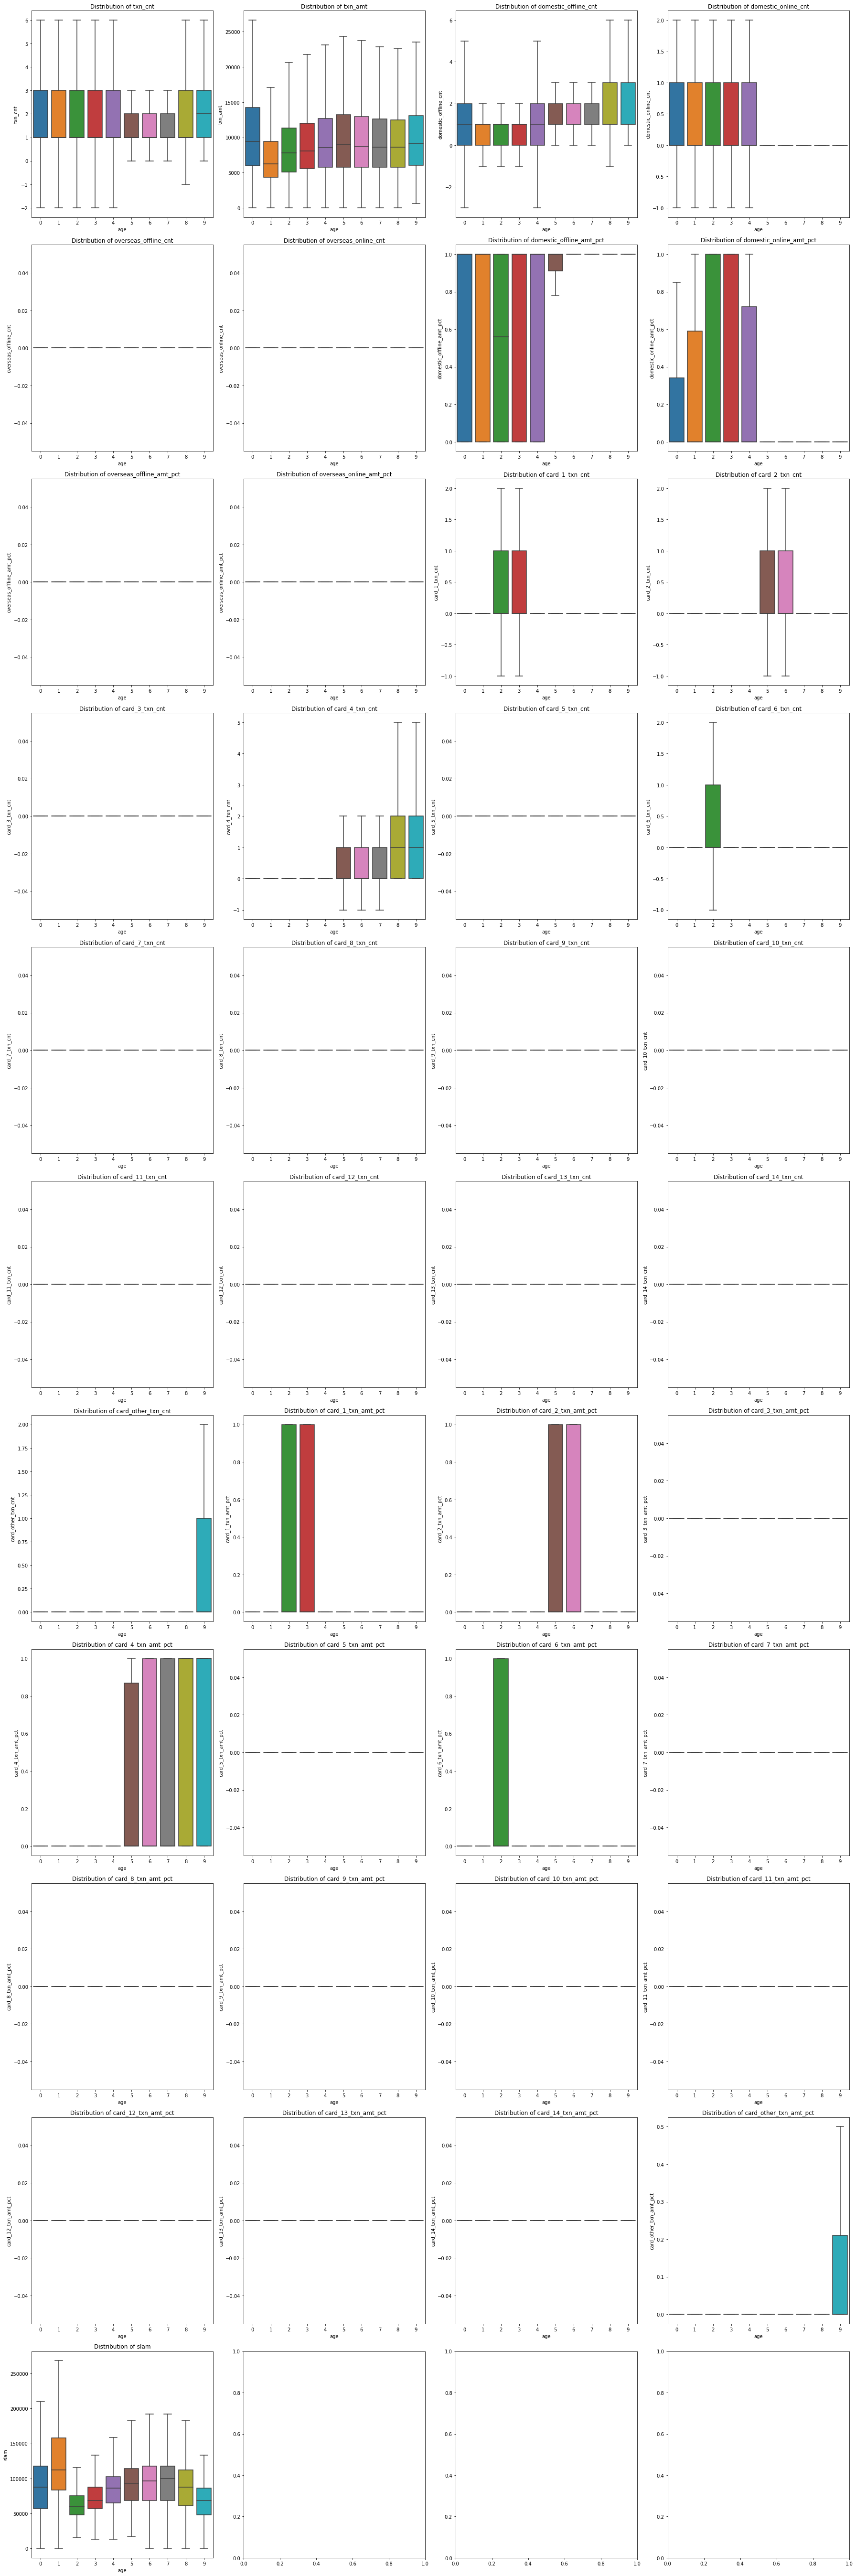

In [60]:
plot_box_single_attr('age', showfliers=False)

49it [00:03, 16.01it/s]


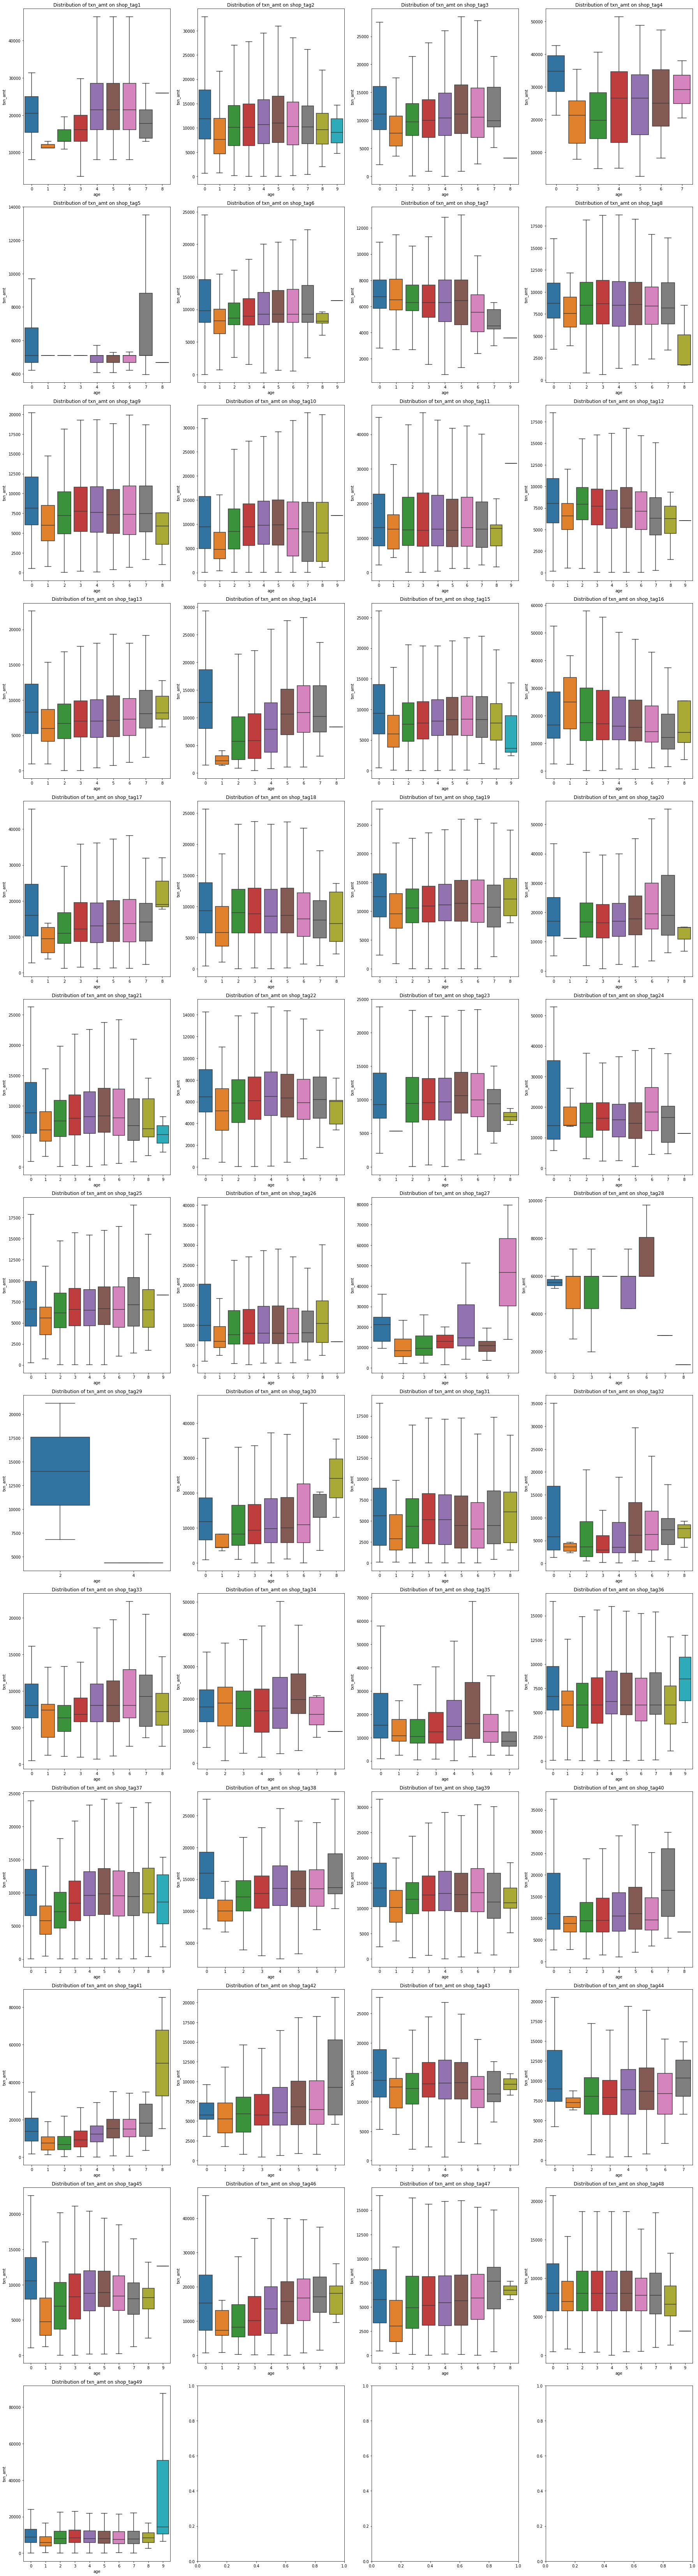

In [4]:
def plot_box_(attr, feat, showfliers=False):
    '''Plot box plot of the specified numeric feature versus cat. 
    features, and each plot takes care only one `shop_tag`.
    '''
    n_cols = 4
    n_rows = (50 // n_cols) + 1
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 50*2-8))
    for i, shop_tag in tqdm(enumerate(SHOP_TAGS_)):
        df_ = df[(df['shop_tag'] == shop_tag) & (df['dt'] == 23)]
        sns.boxplot(x=attr, y=feat, data=df_, showfliers=showfliers,
                    ax=axs[i//n_cols, i%n_cols])
        axs[i//n_cols, i%n_cols].set_title(f"Distribution of {feat} "
                                           f"on shop_tag{shop_tag}")
        del df_
    plt.tight_layout()

plot_box_('age', 'txn_amt')

In [3]:
# txn_amt representation for pct-related features
del df
gc.collect()

df = pd.read_parquet(DATA_PATH_TXN_AMTS)
df = pd.concat([df, pd.read_parquet(DATA_PATH_RAW, columns=CLI_ATTRS[1:]+['primary_card'])], axis=1)
numeric_feats = [col for col in df.columns if 'txn_amt' in col]

19it [00:32,  1.71s/it]
19it [00:34,  1.84s/it]
19it [00:39,  2.06s/it]
19it [00:31,  1.67s/it]
19it [00:35,  1.87s/it]
19it [00:34,  1.84s/it]
19it [00:32,  1.71s/it]
19it [00:34,  1.84s/it]


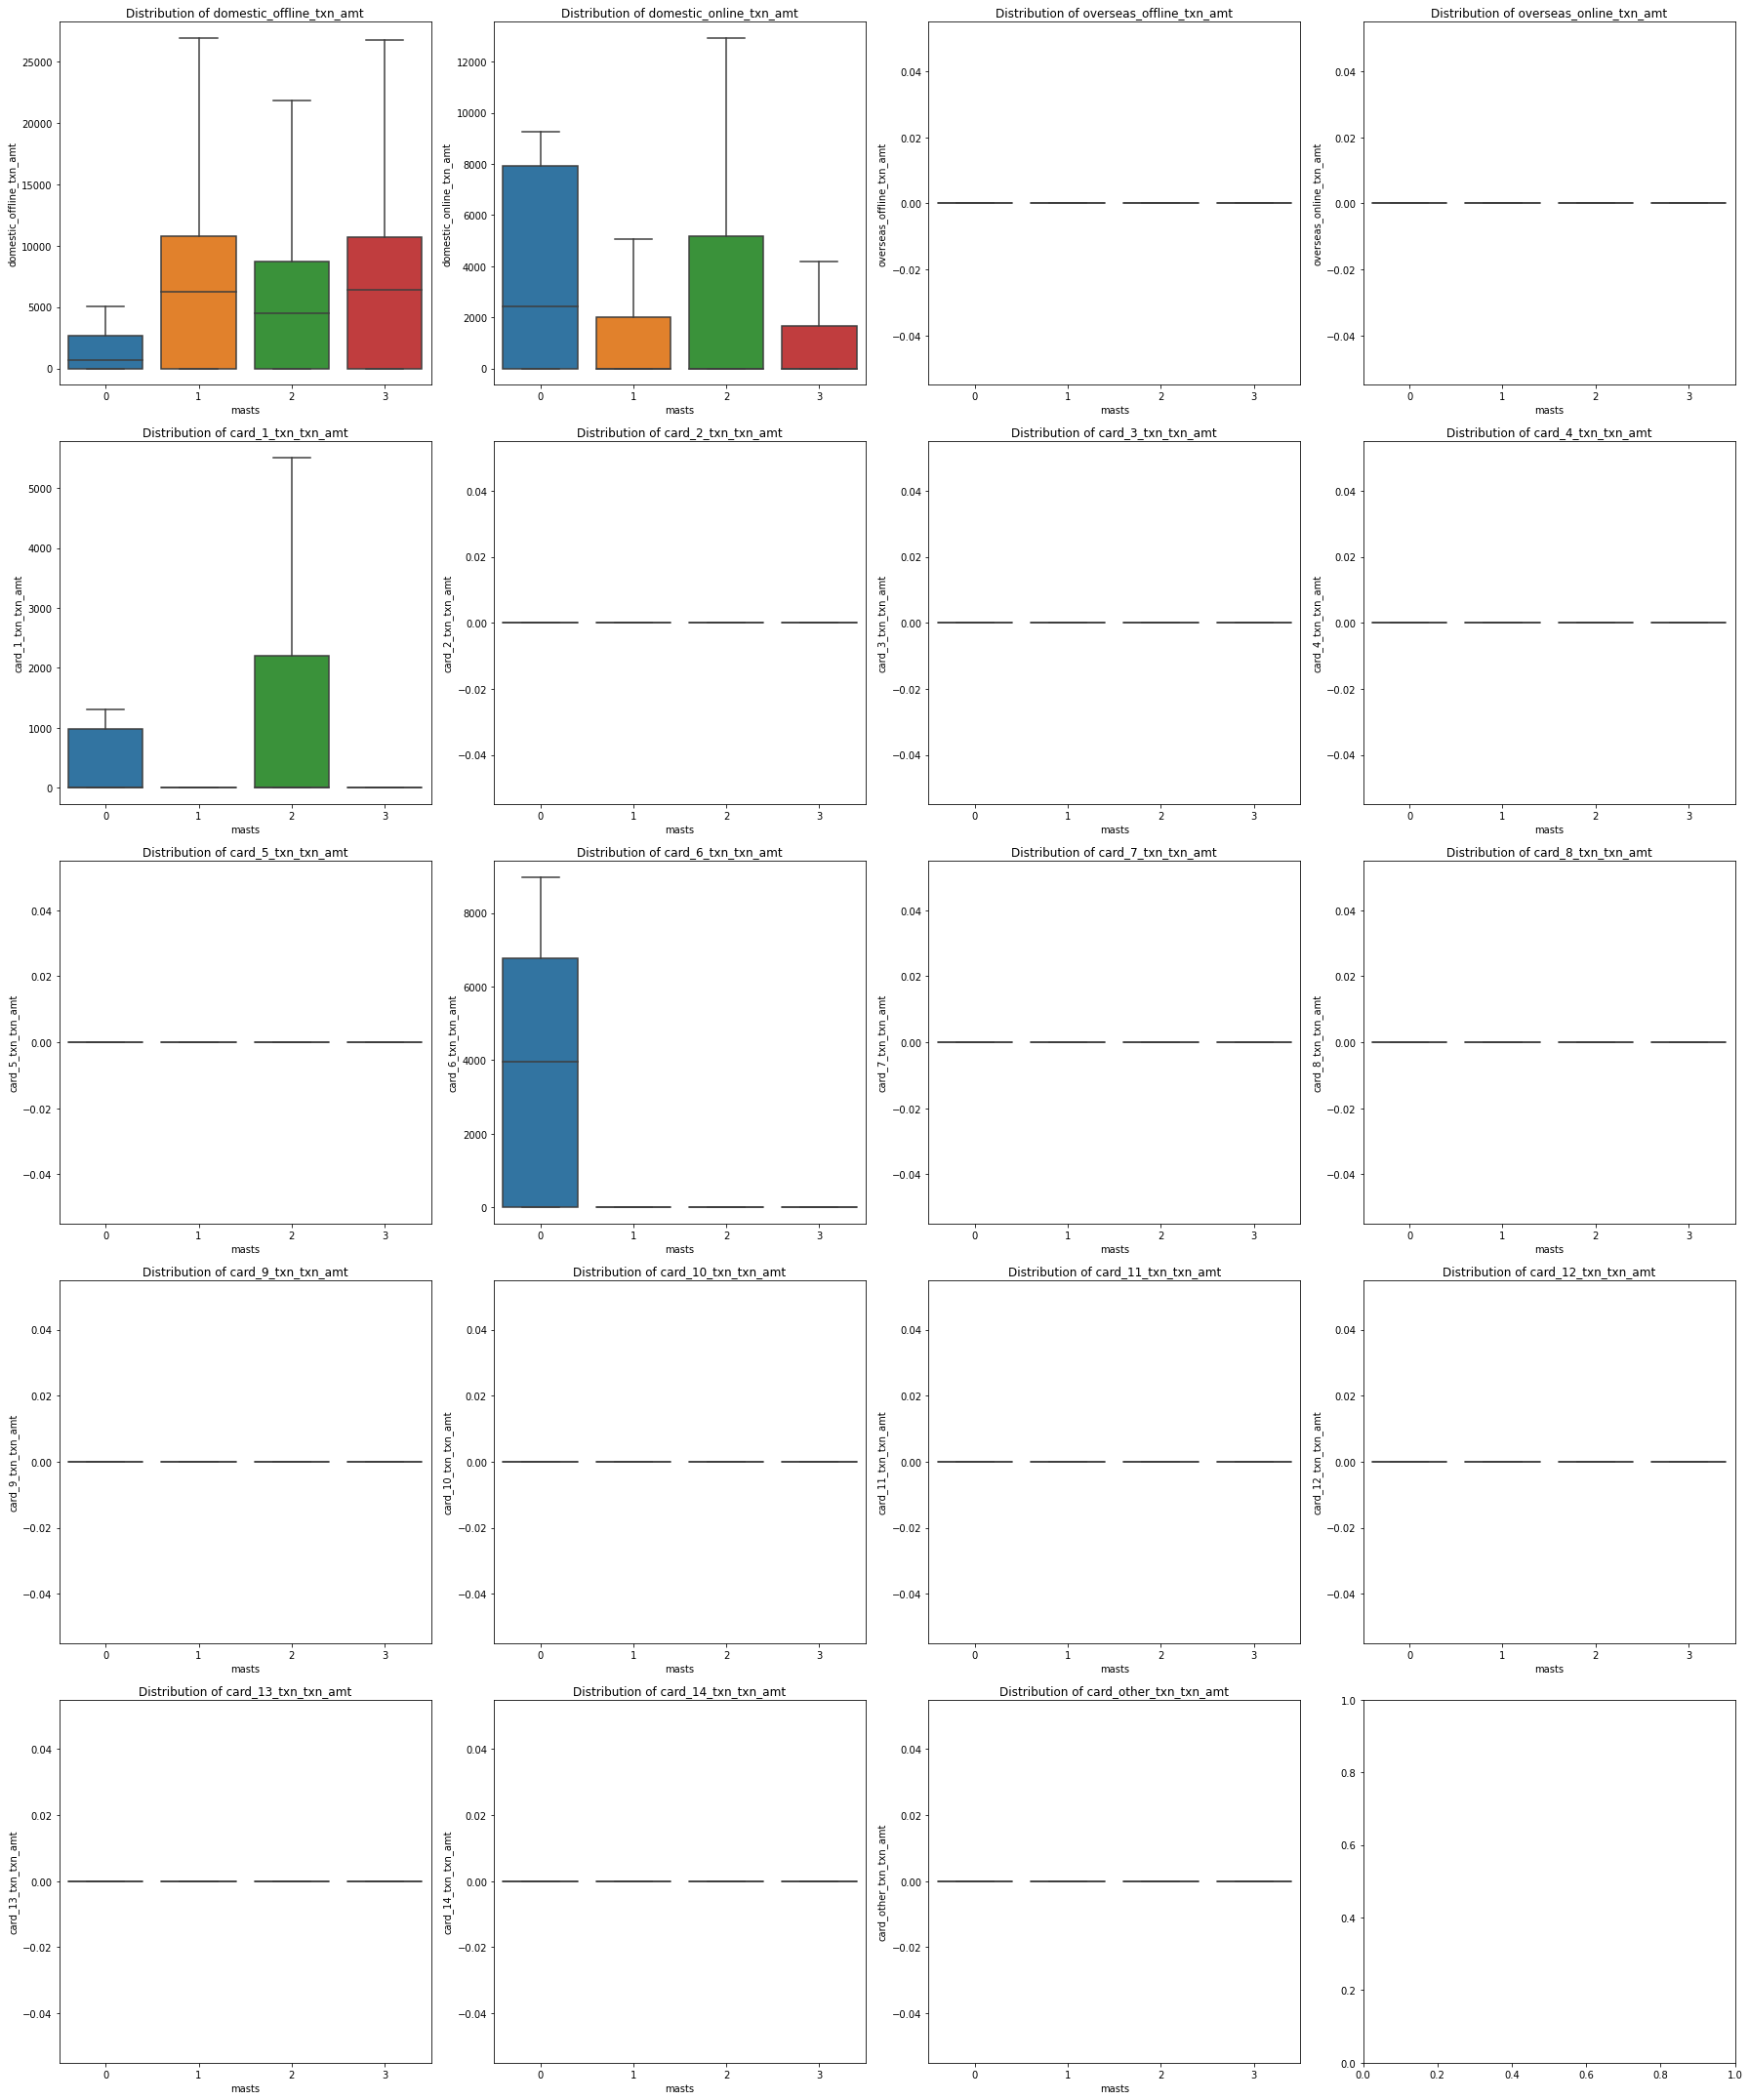

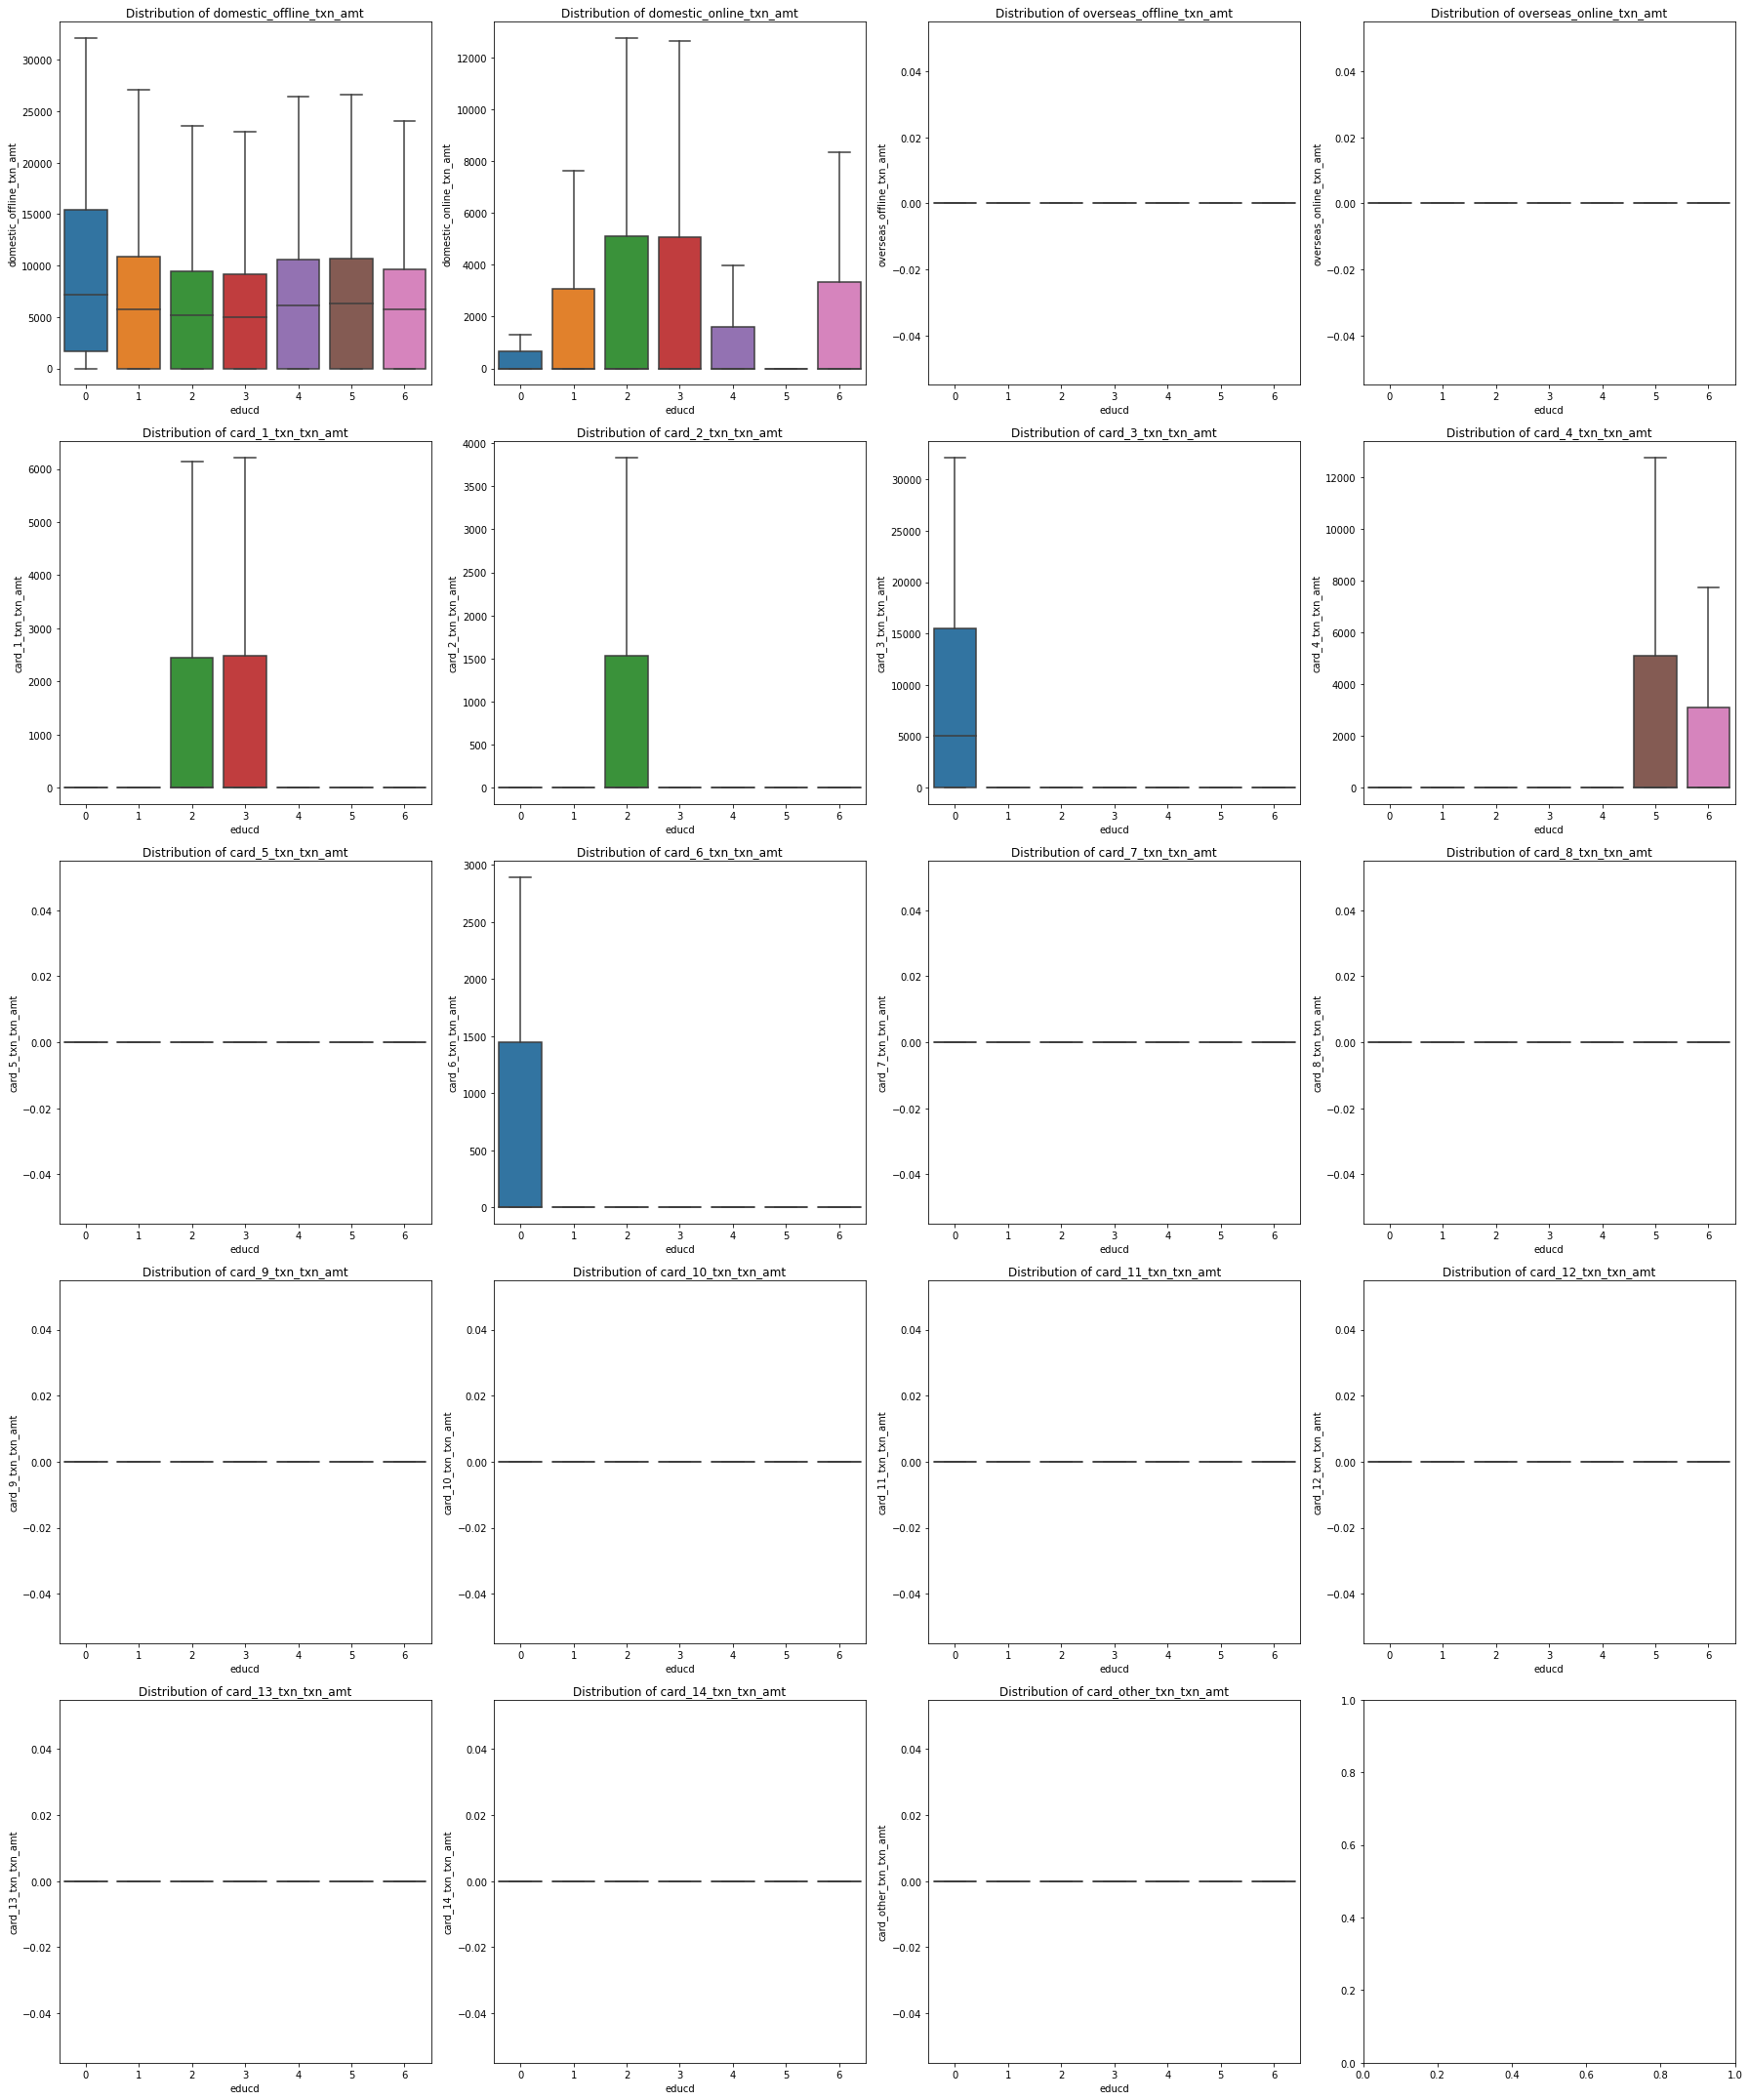

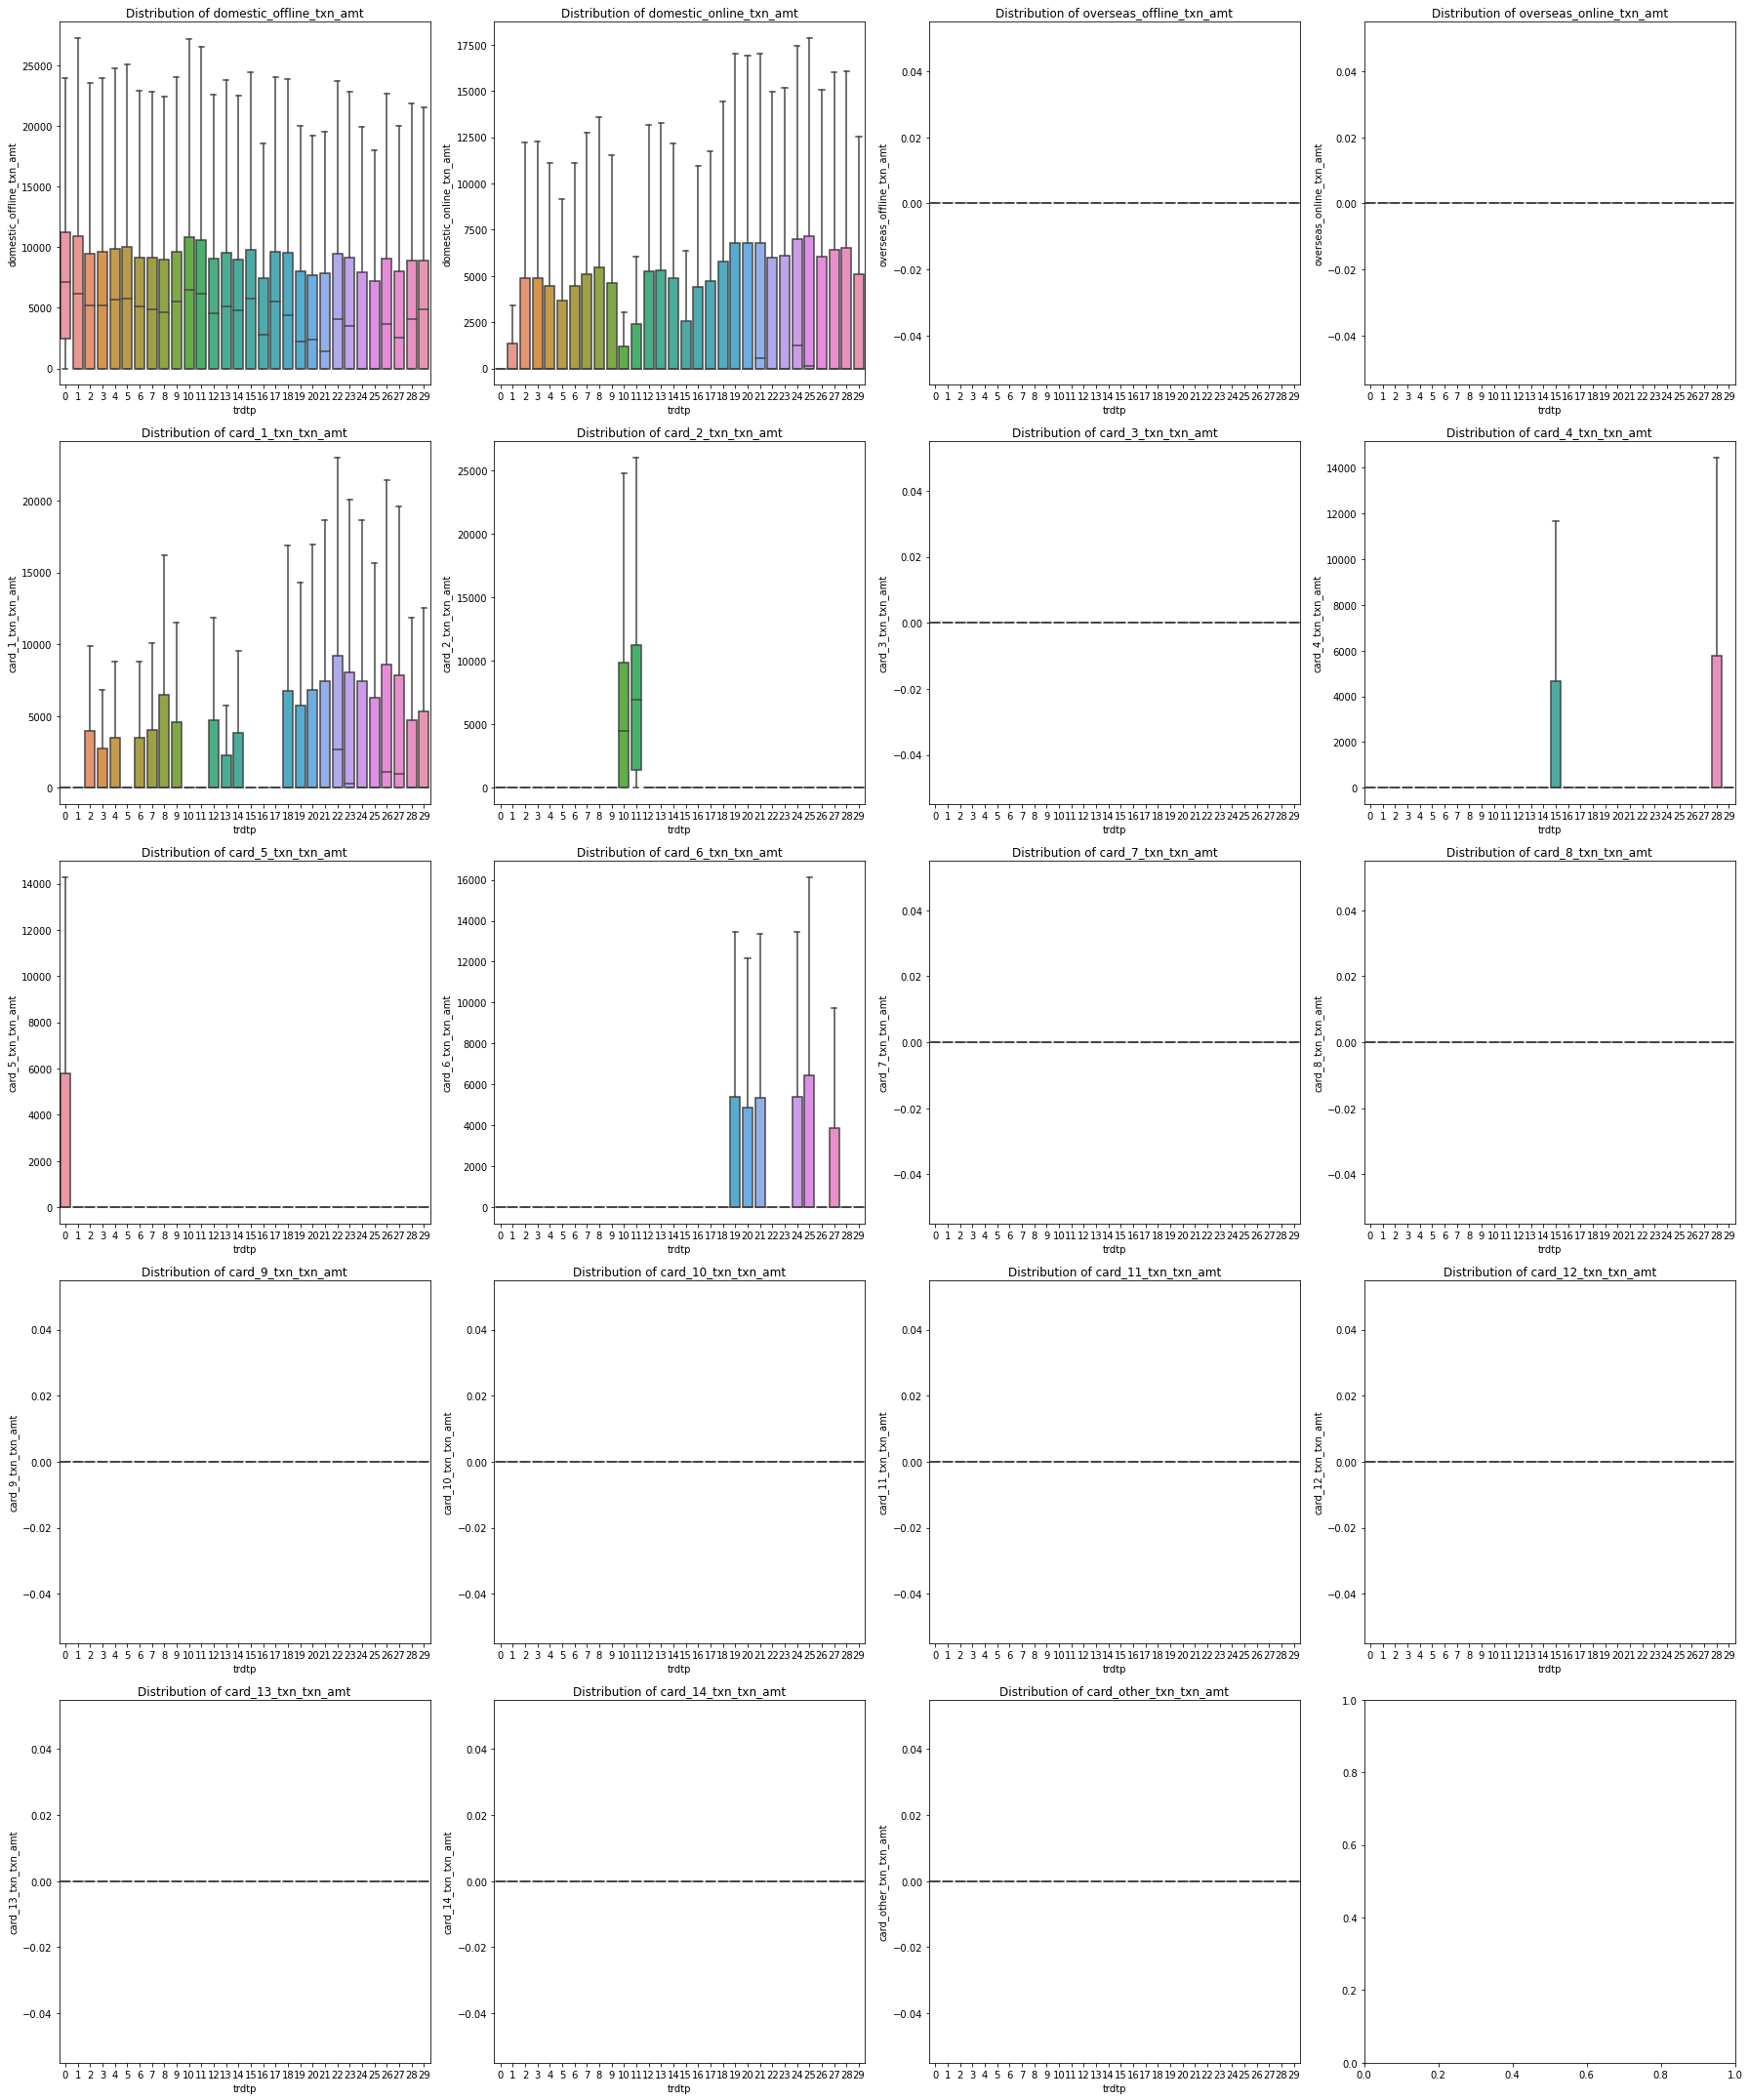

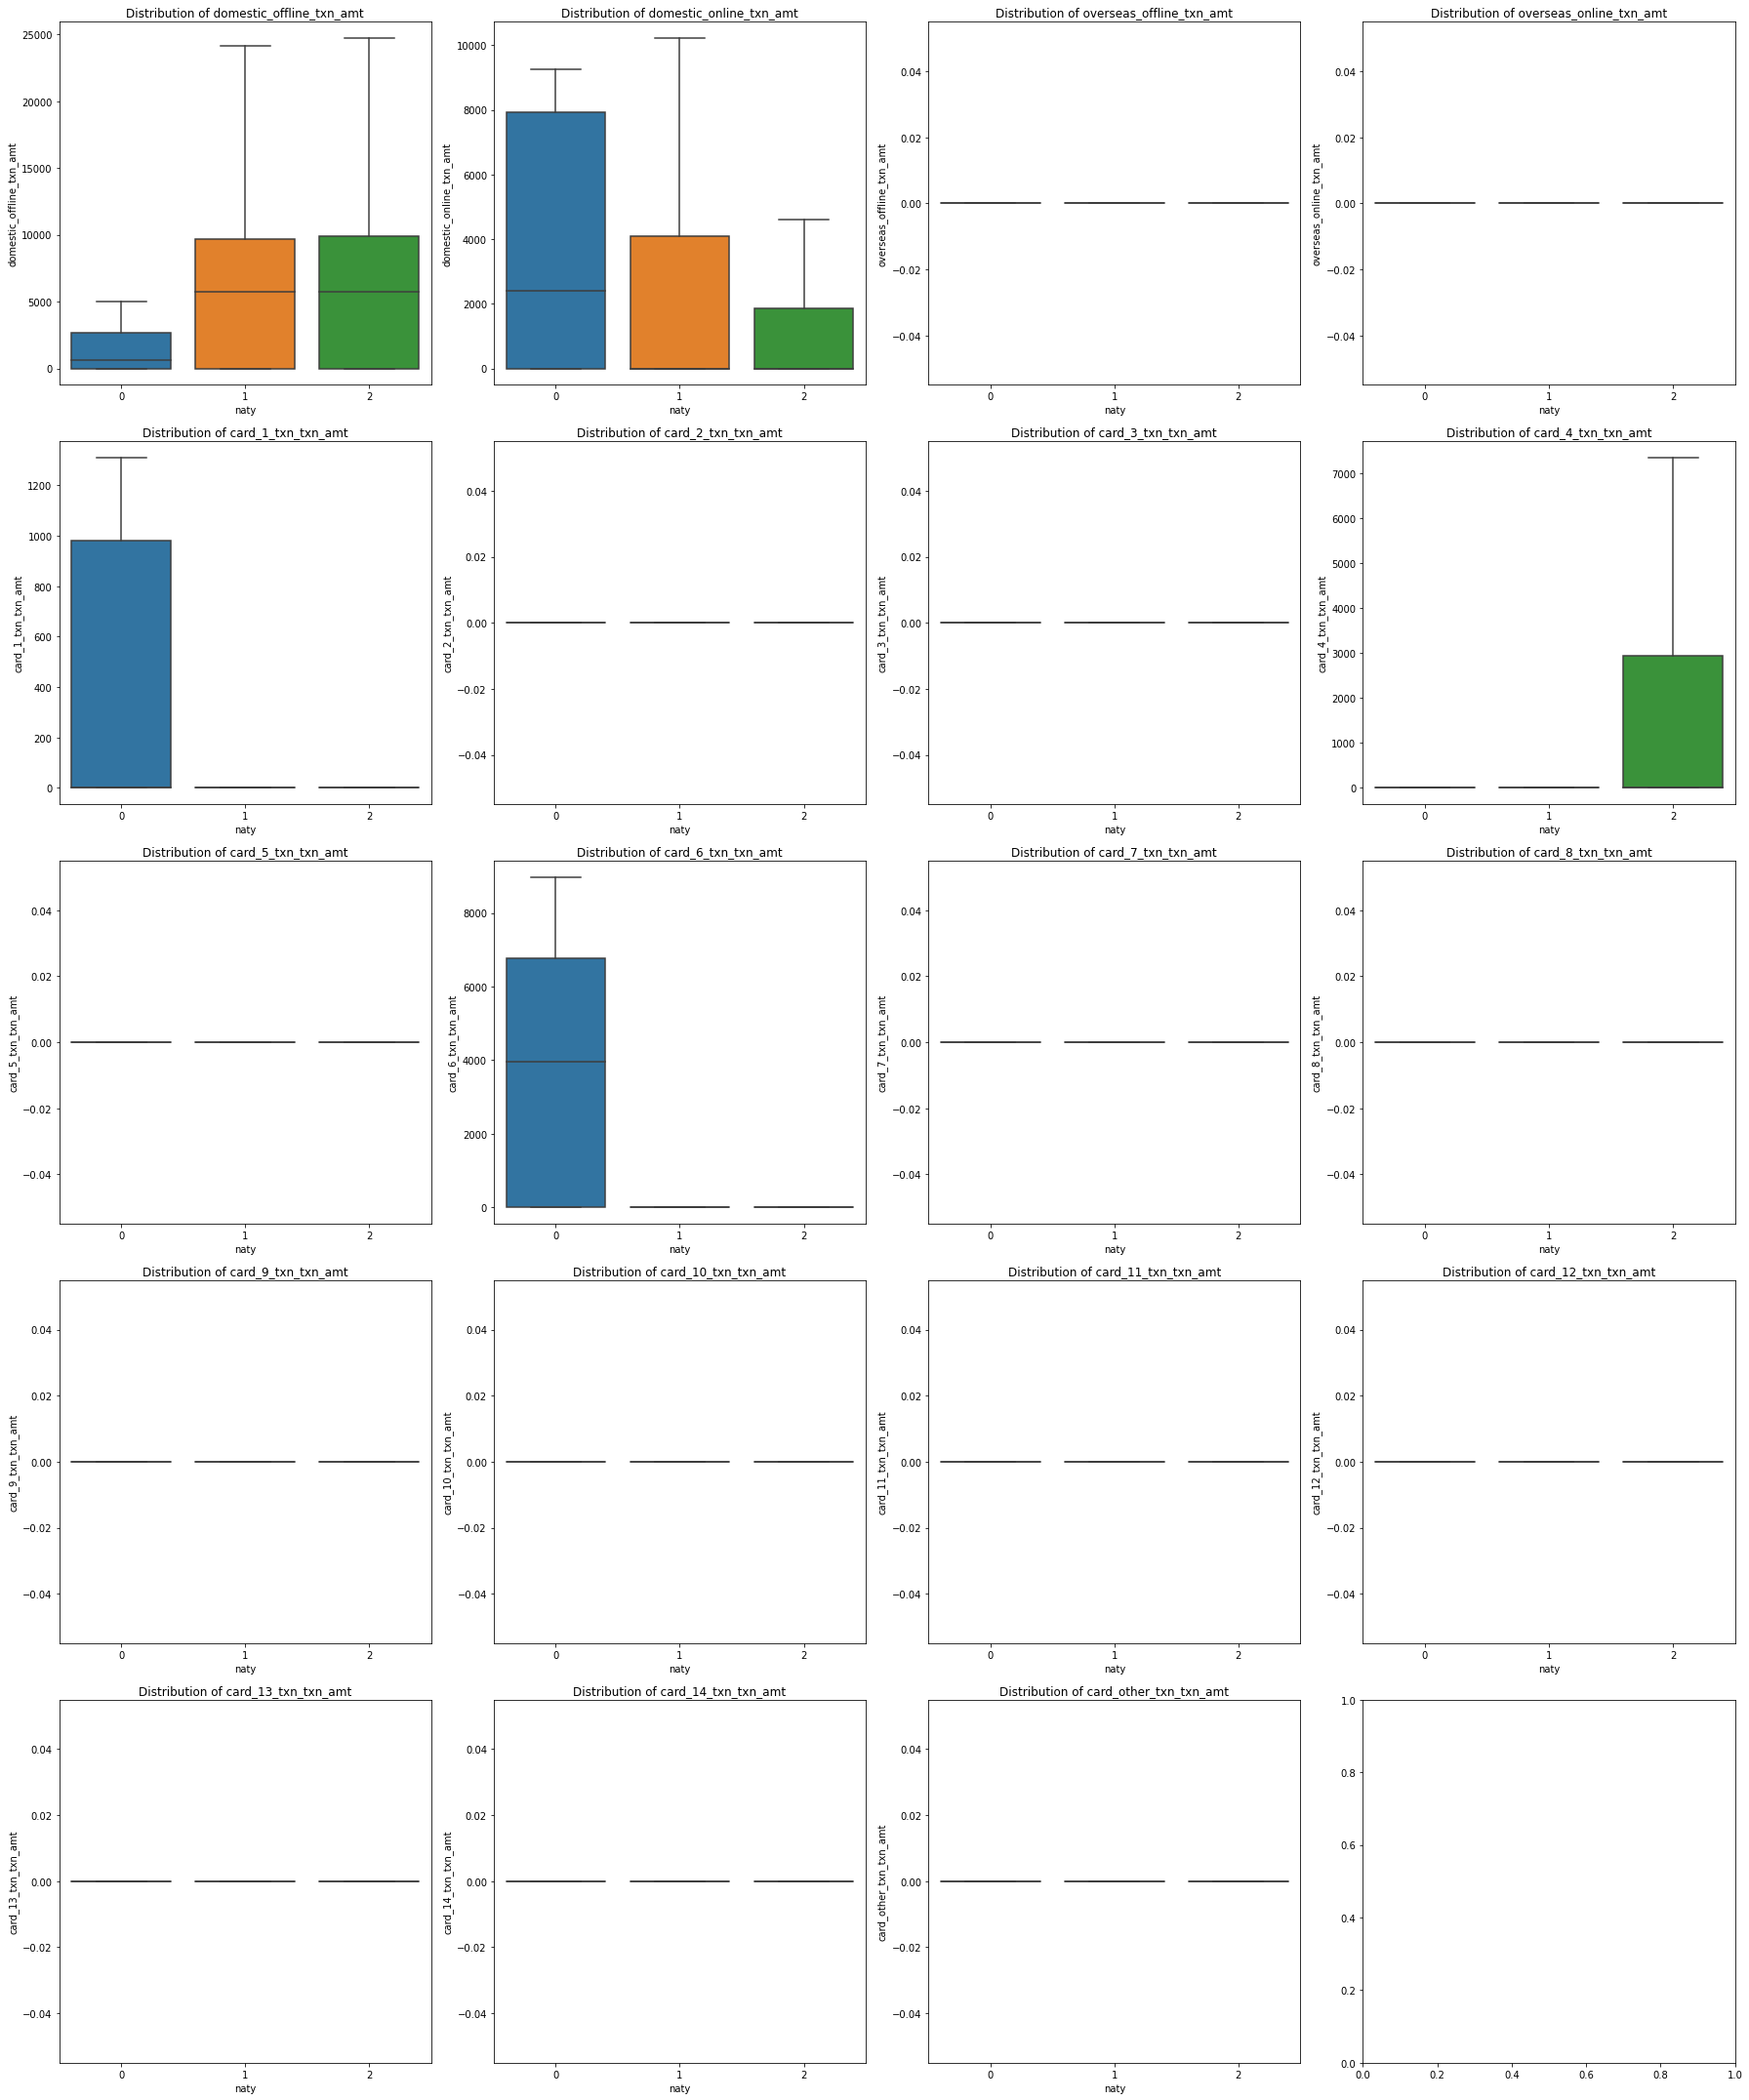

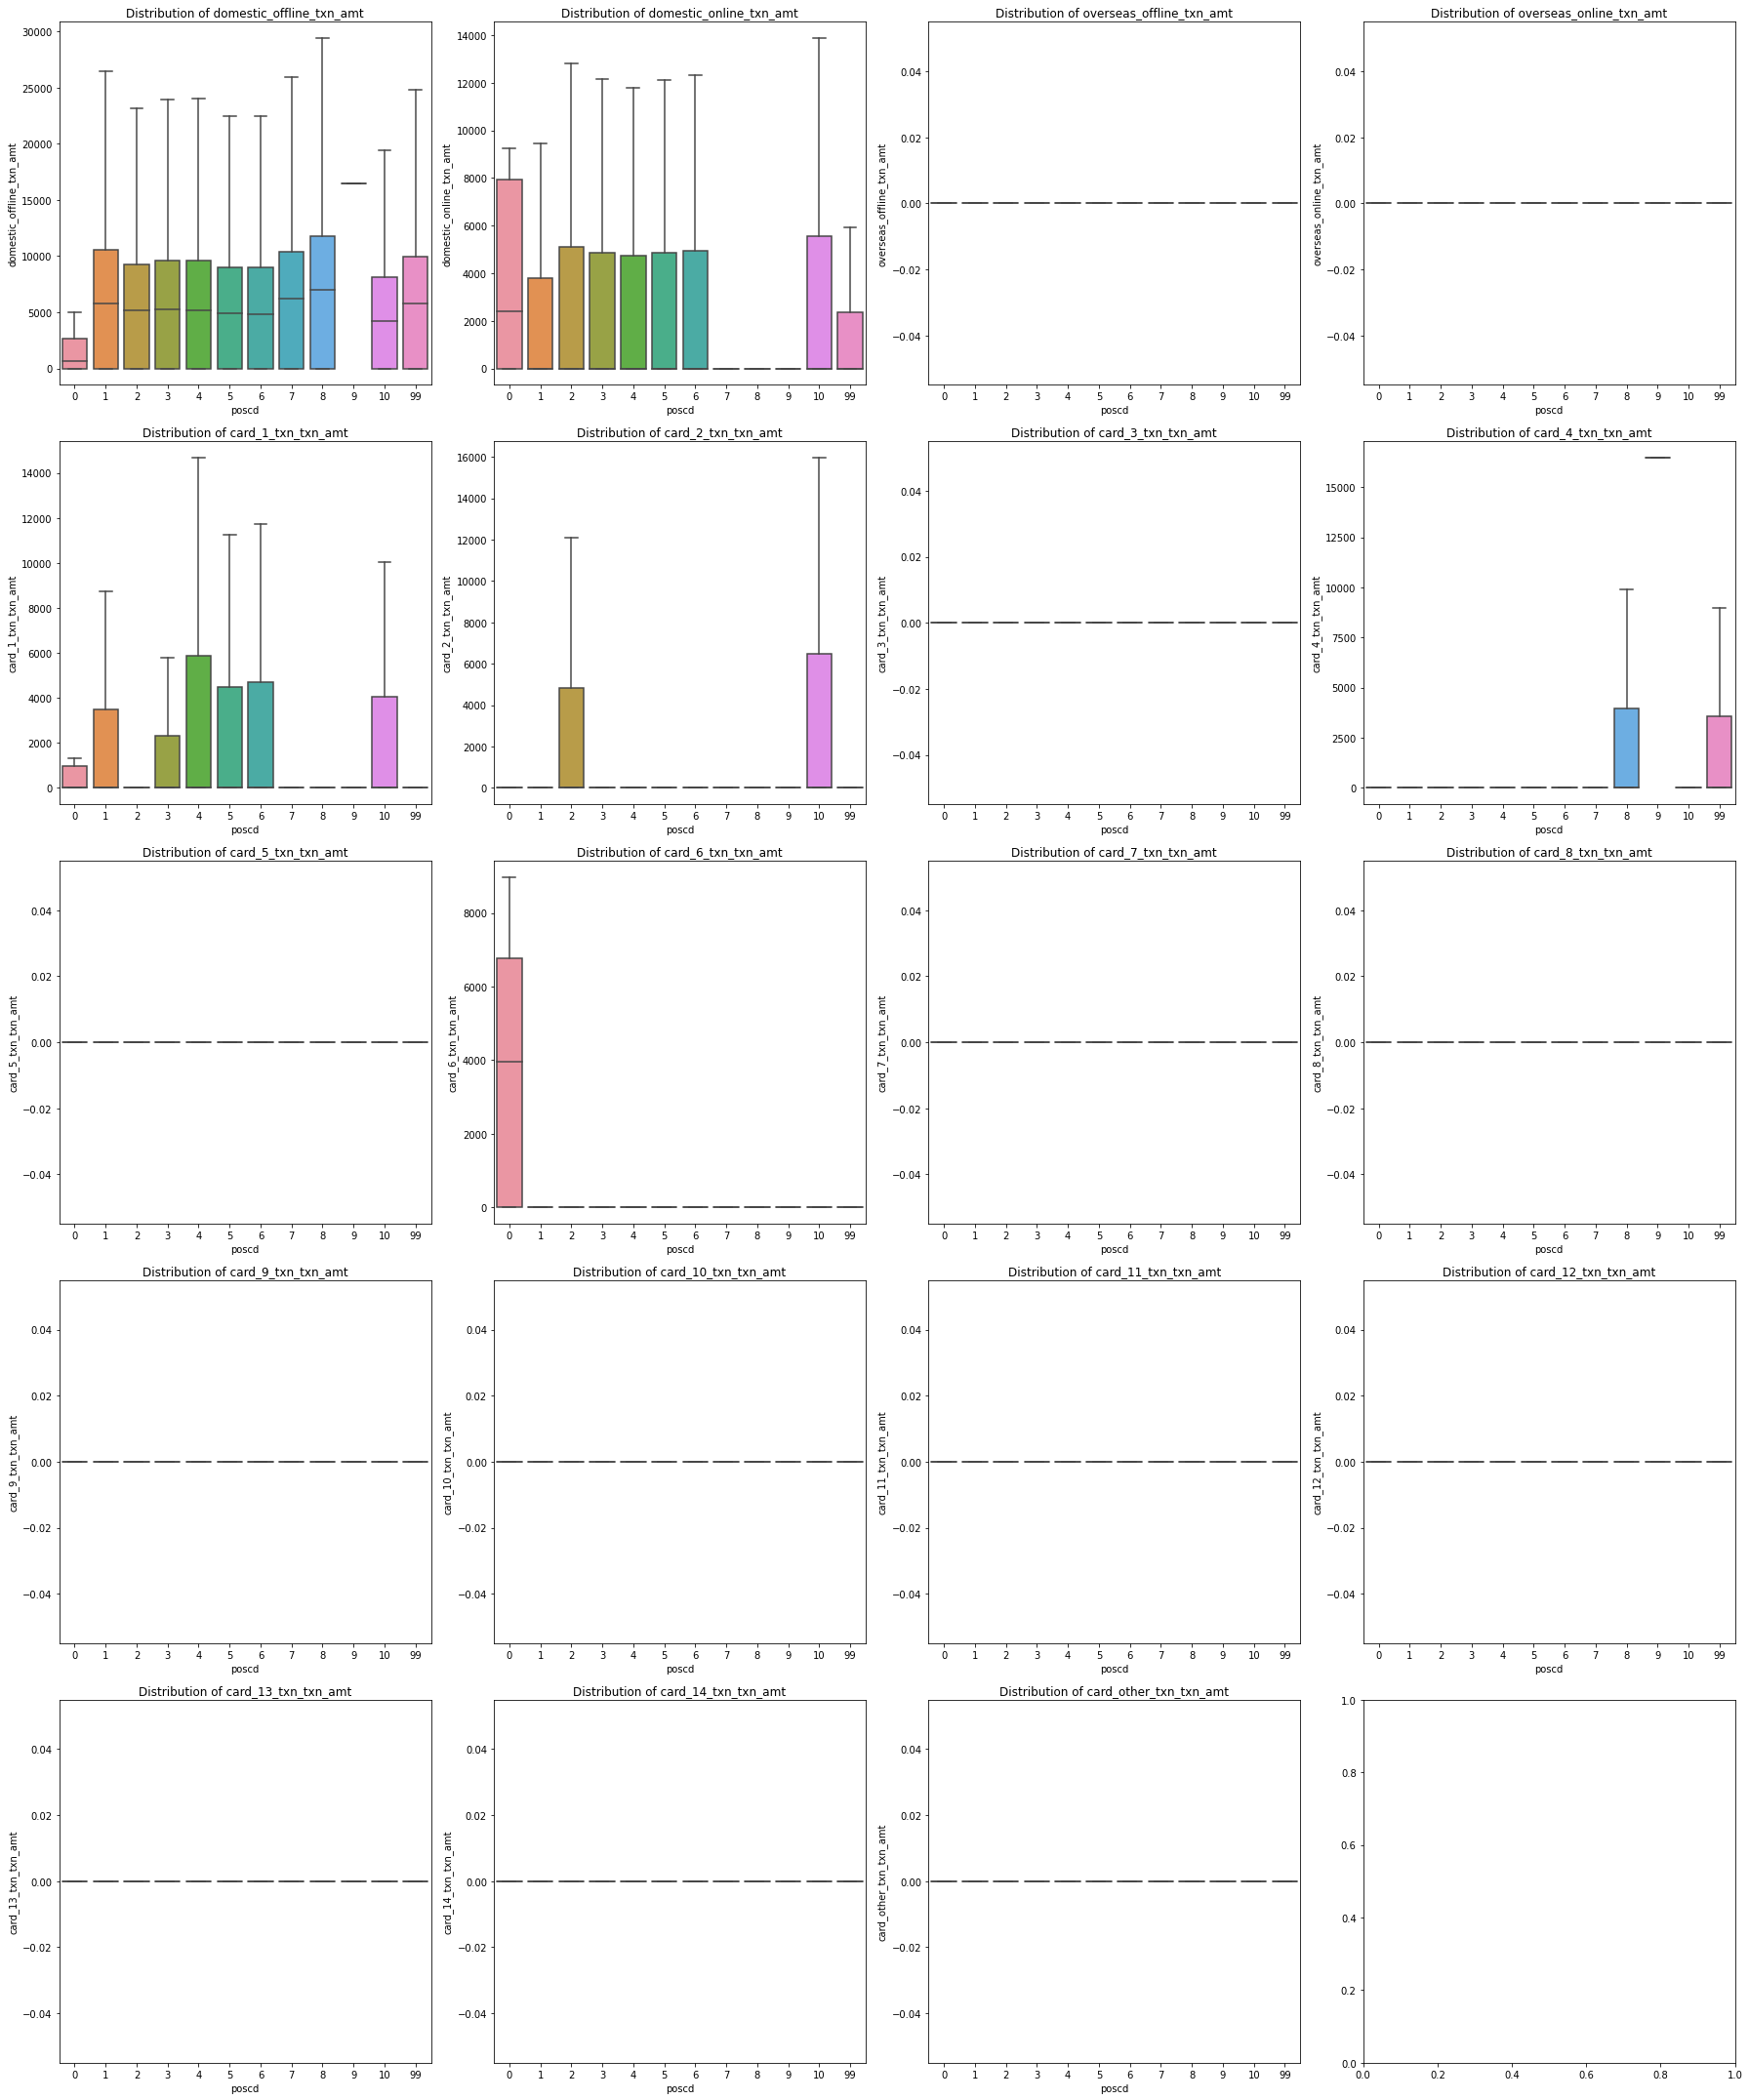

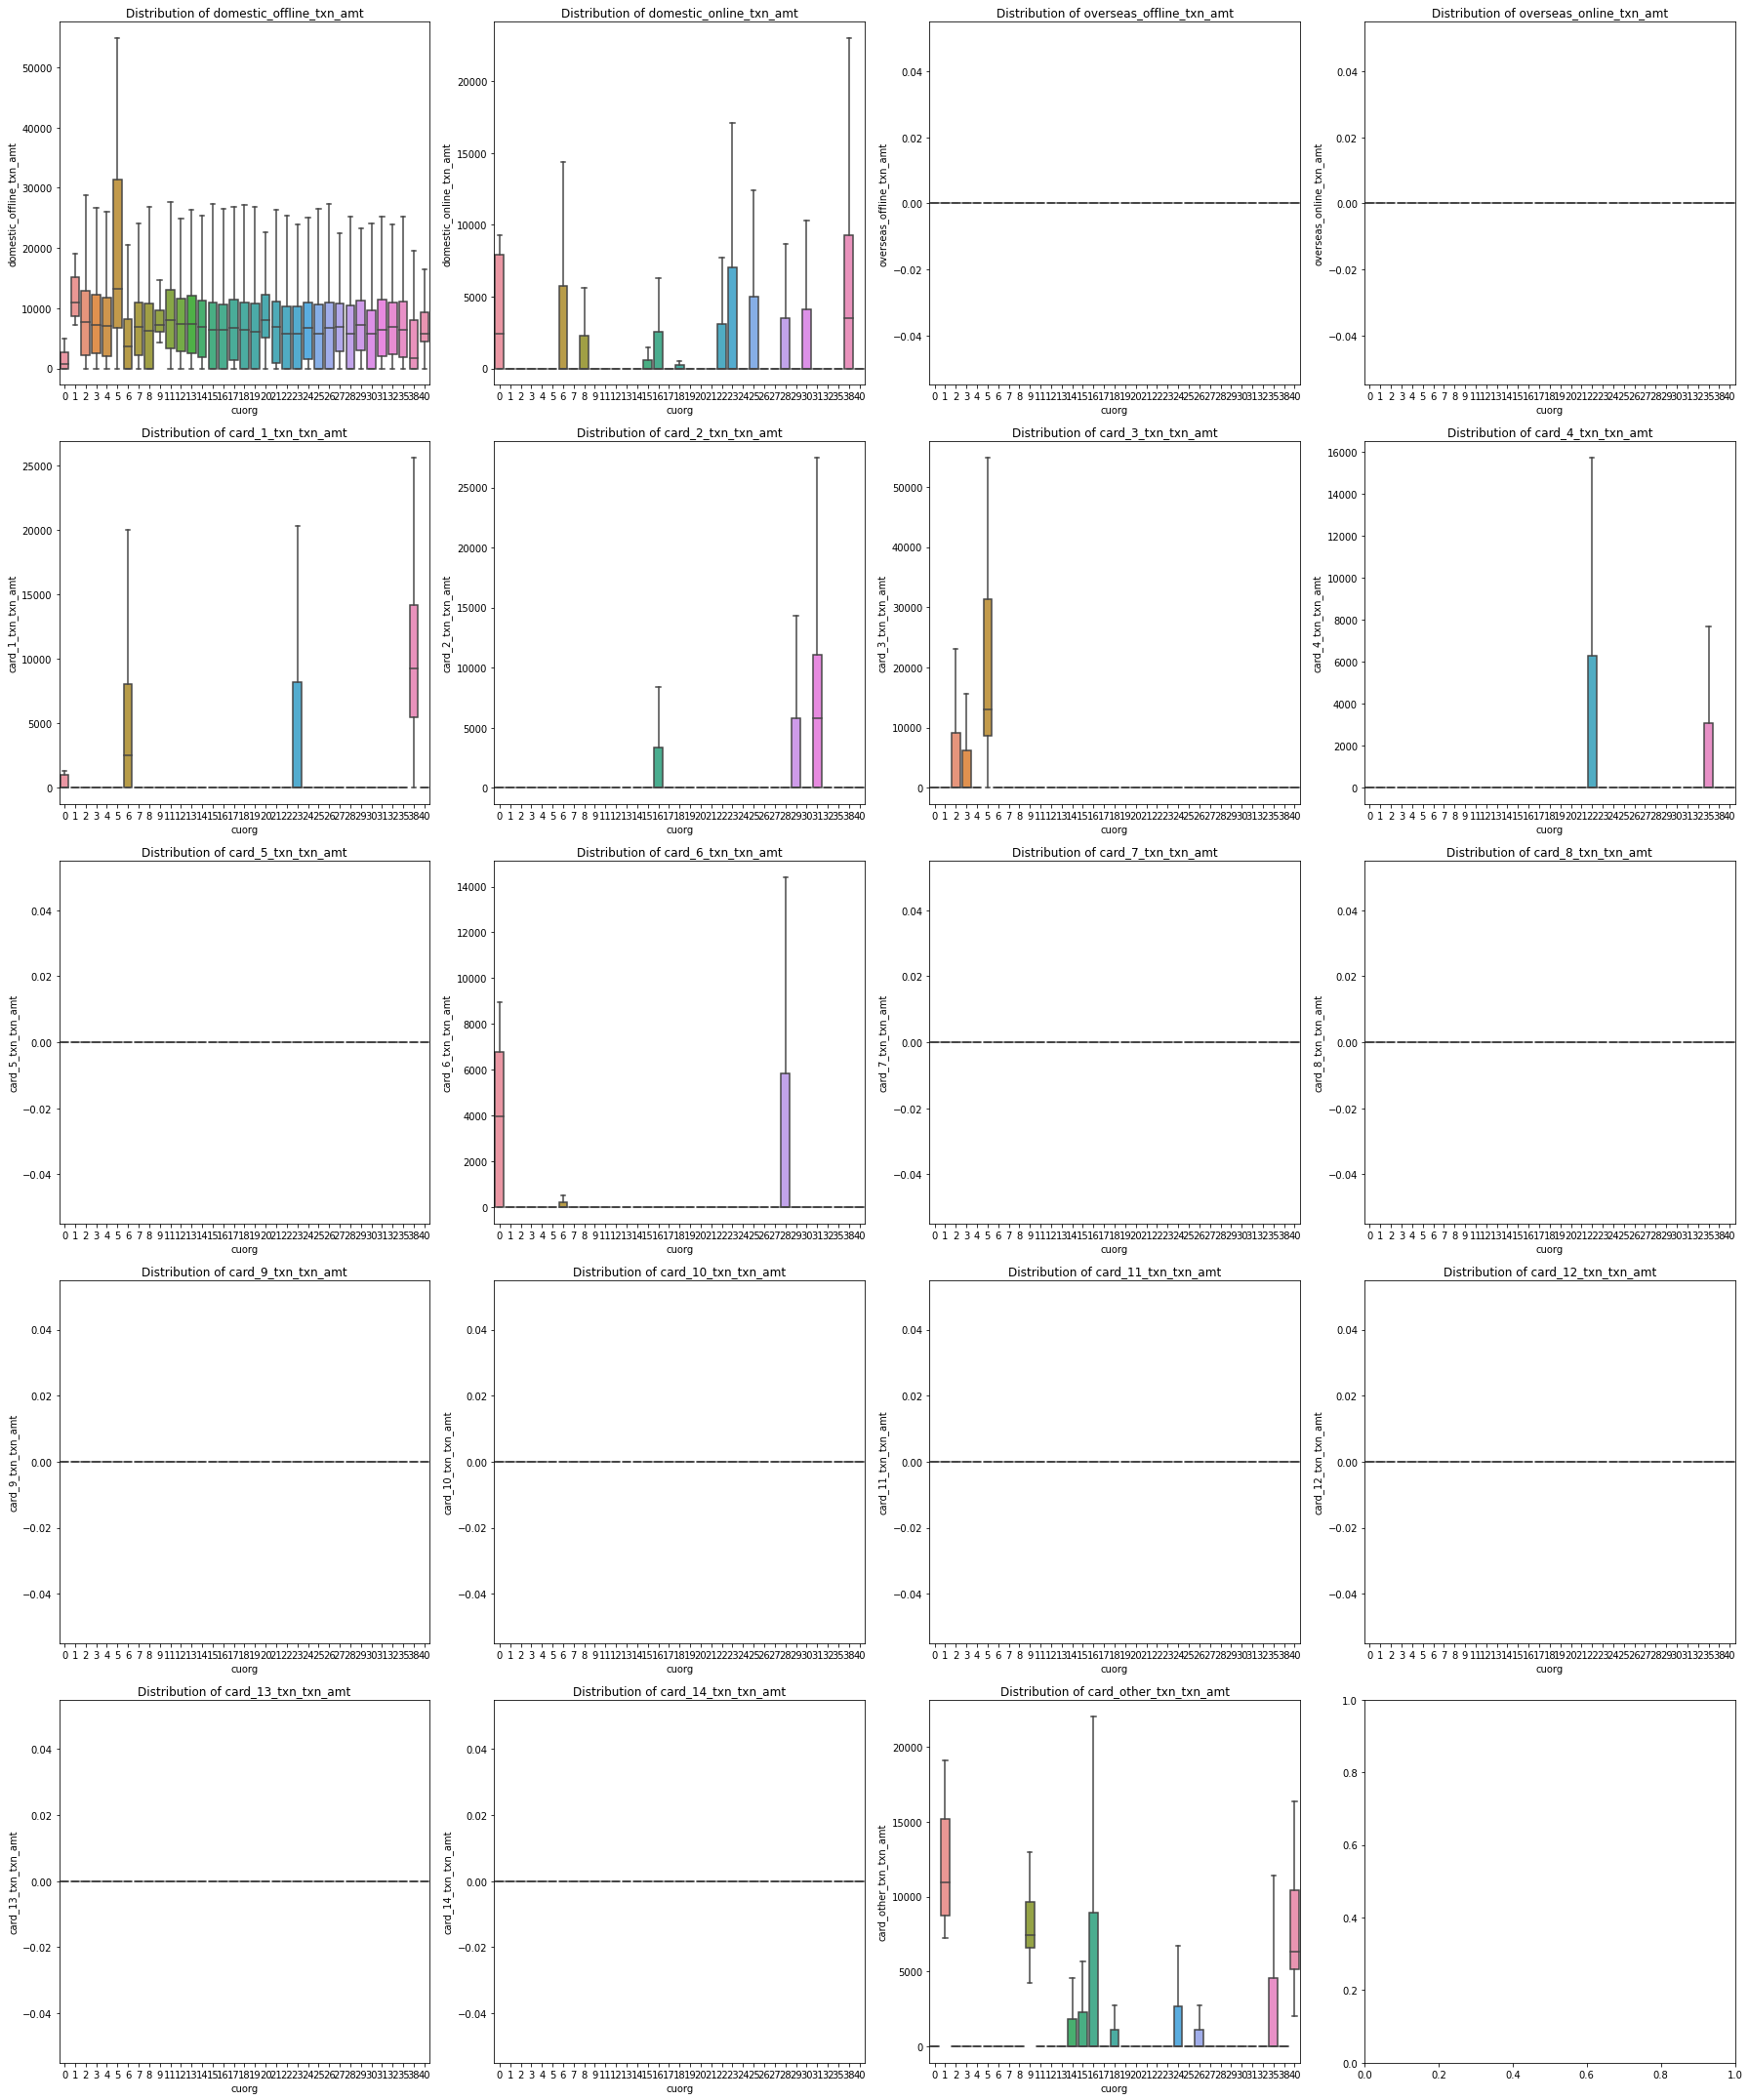

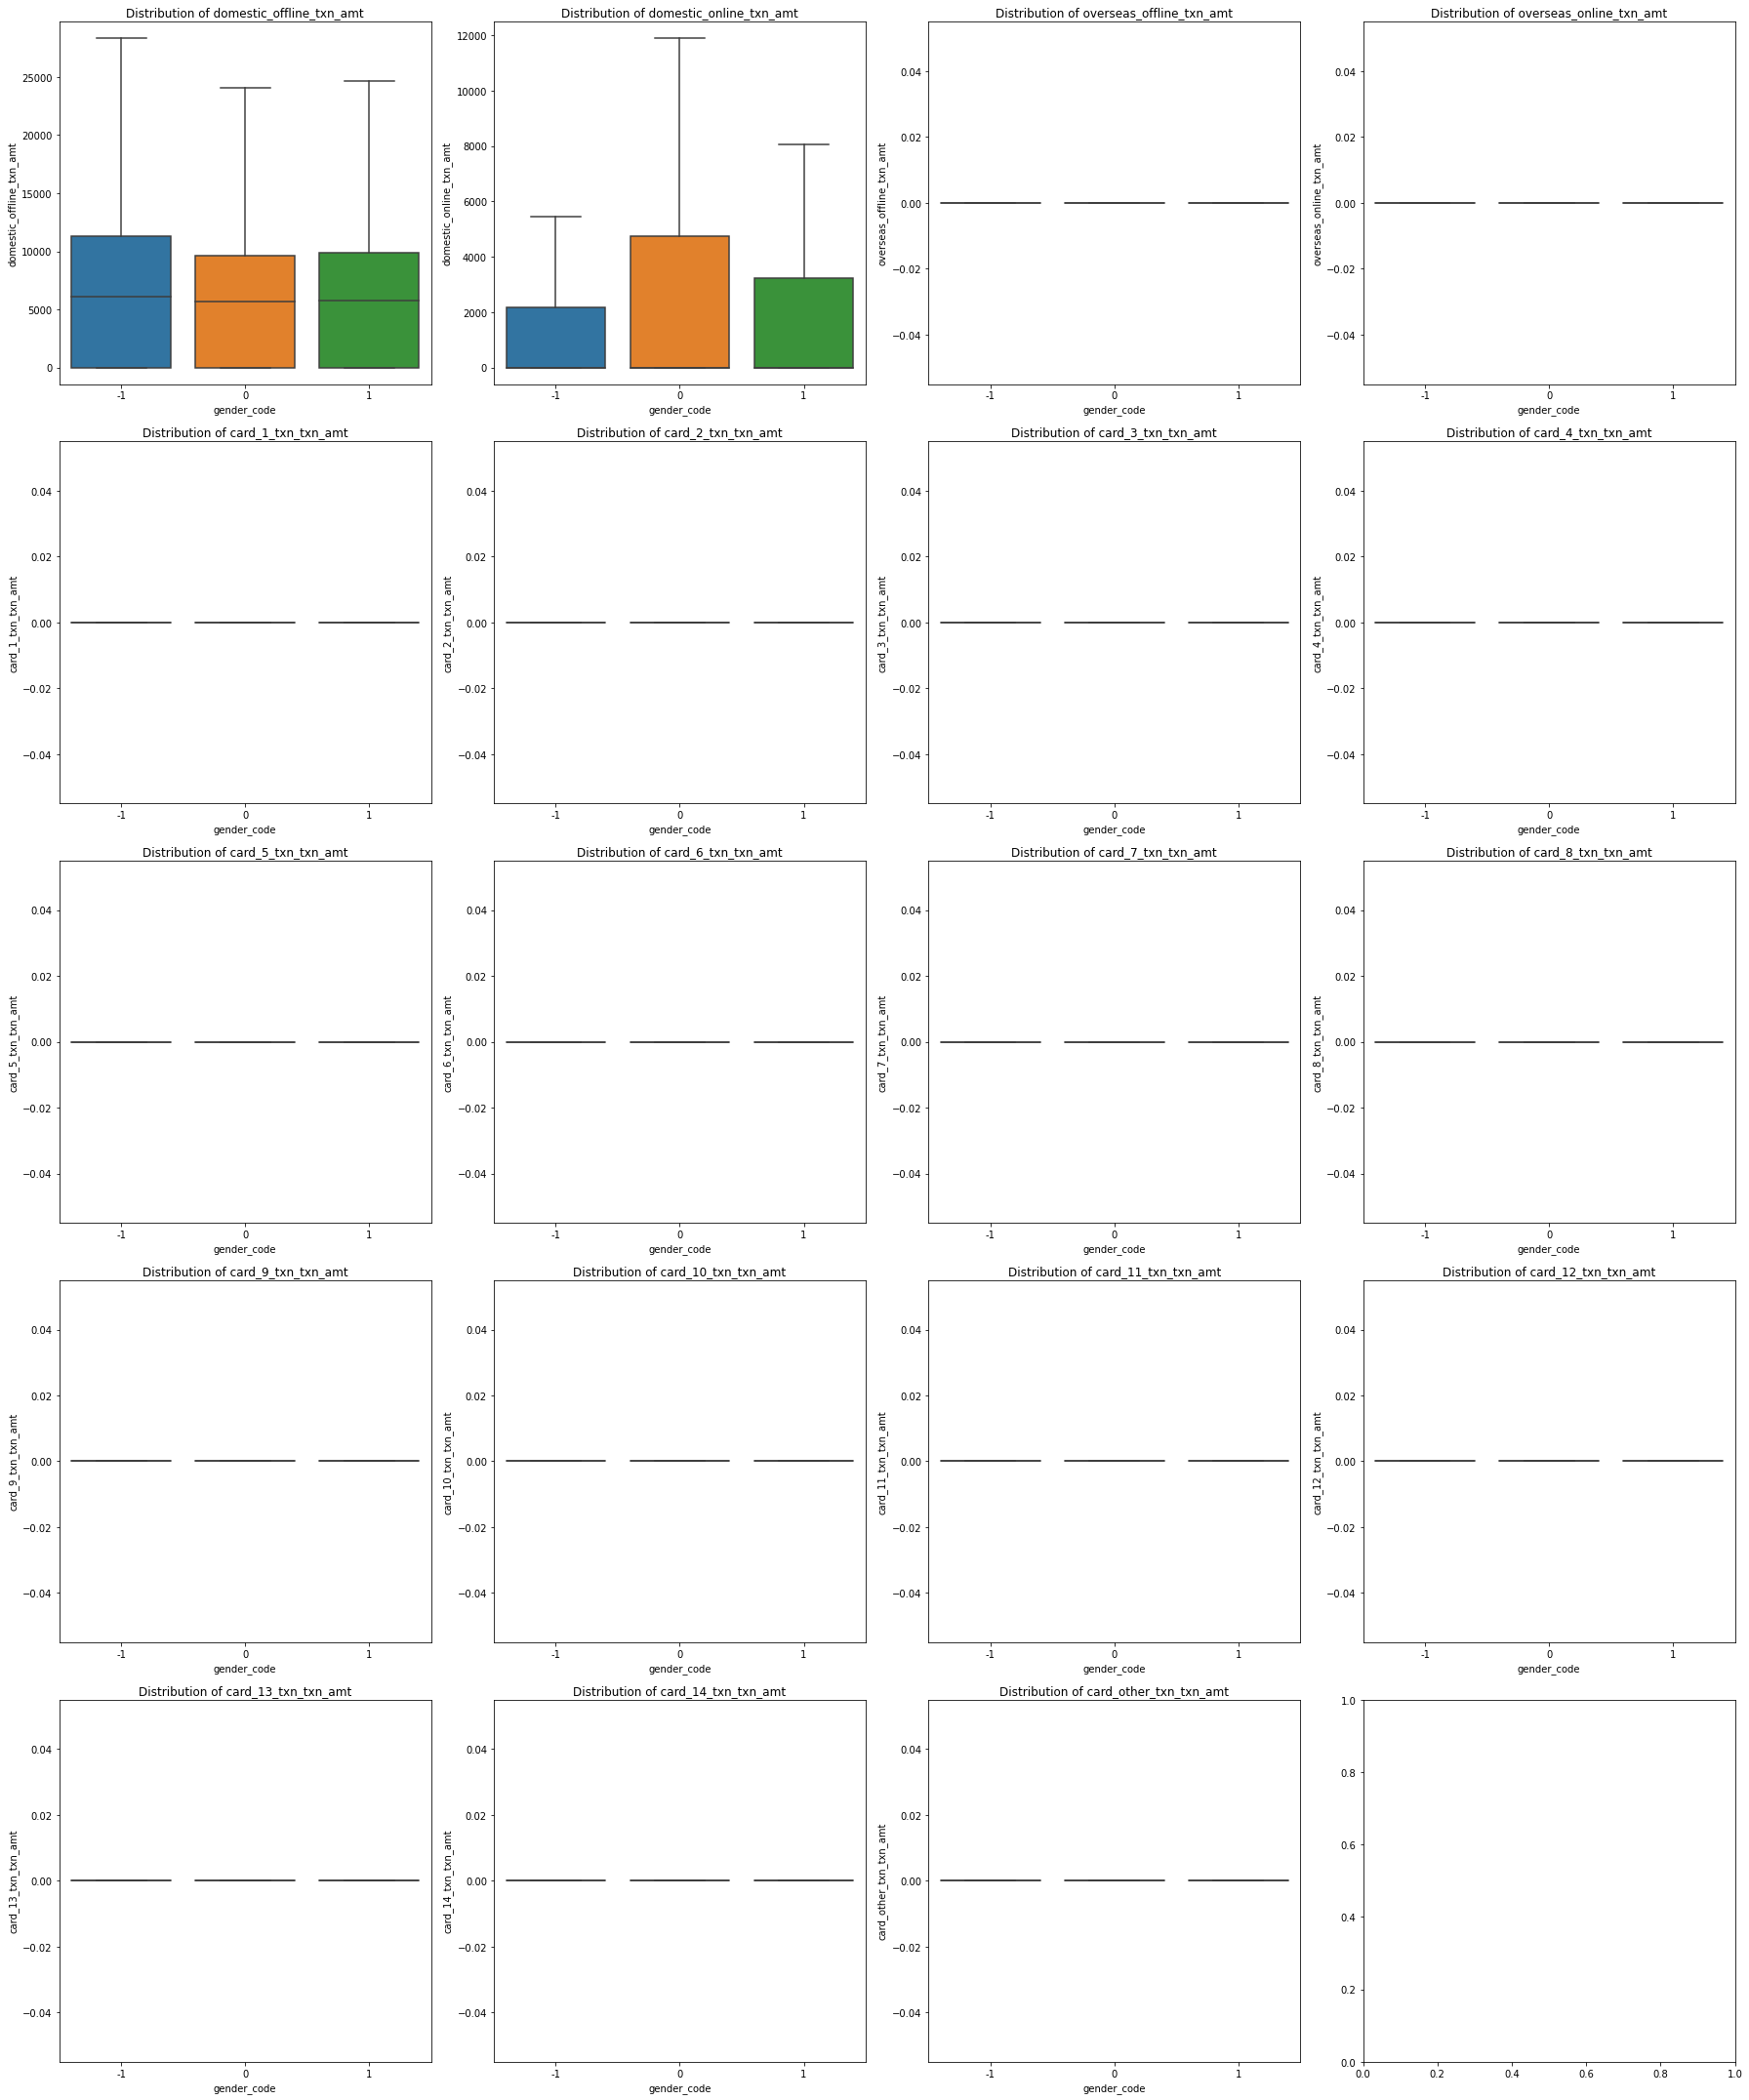

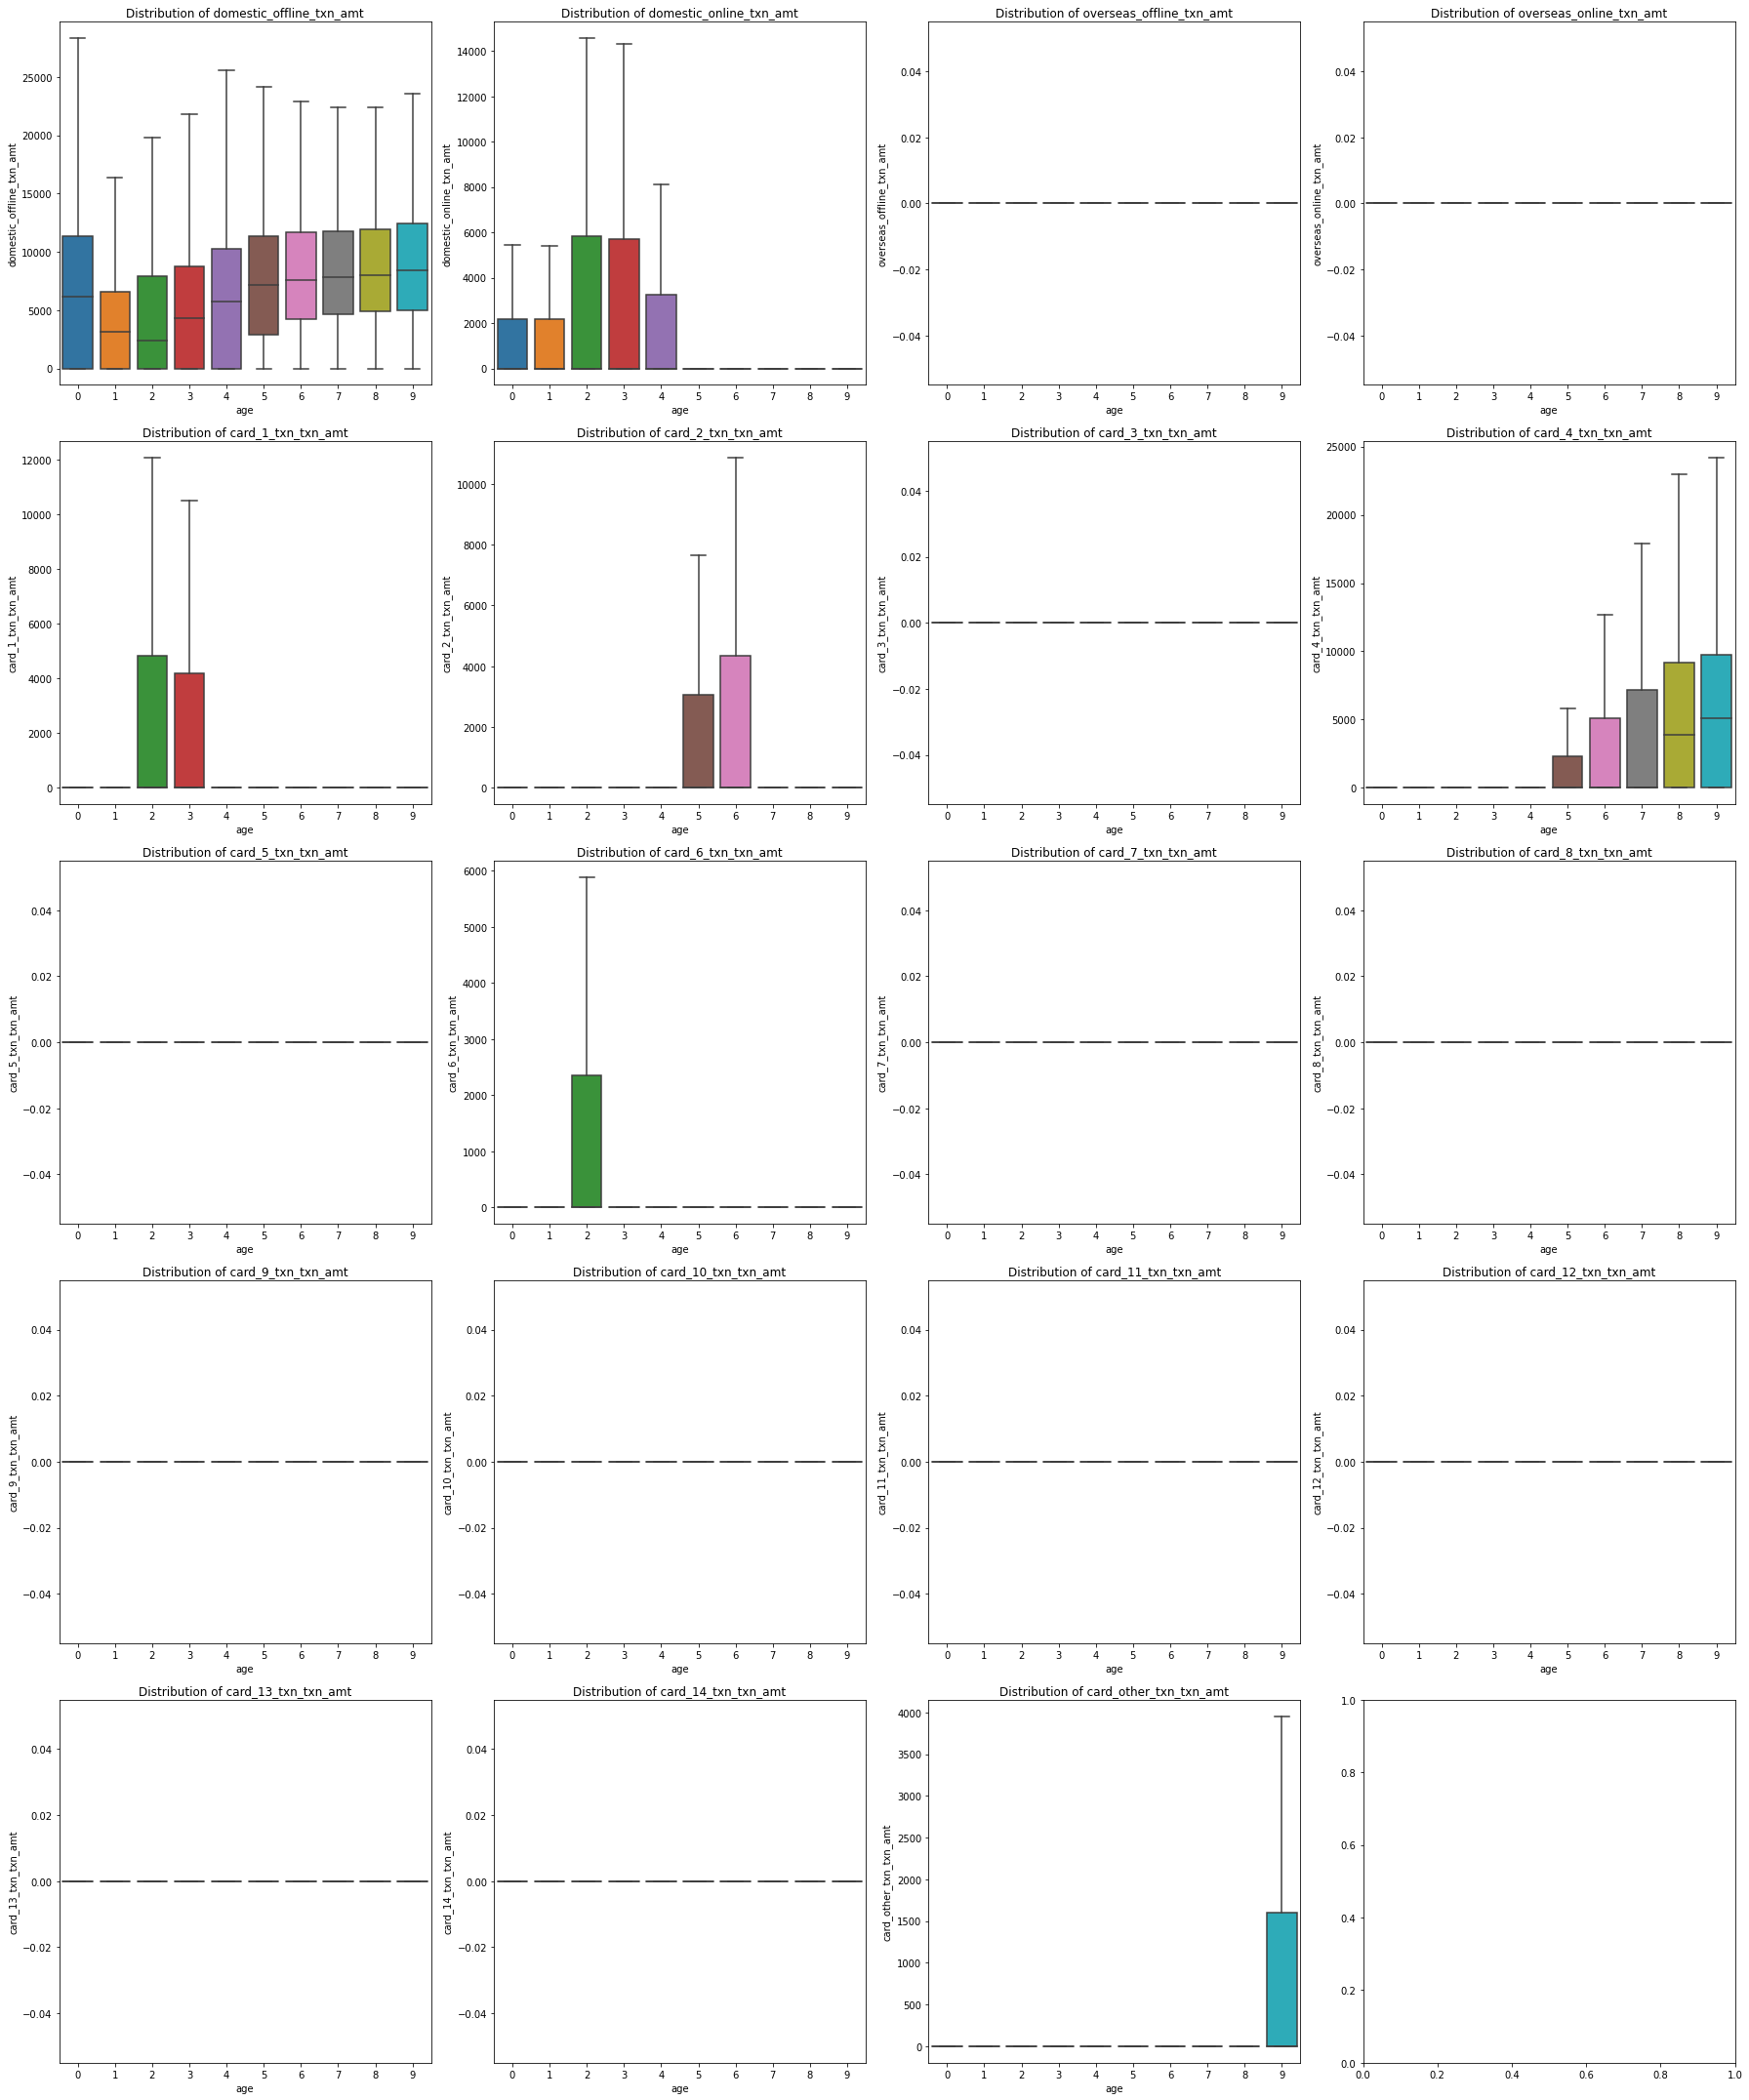

In [4]:
# For pct columns in txn_amt representation 
for col in CLI_ATTRS[1:]:
    # Exclude `chid`
    plot_box_single_attr(col, showfliers=False)

### *Groupby PK*
In this section, fine-grained analysis is done by grouping samples using different PK compnent (*e.g.*, `dt`, `shop_tag`). 

41it [01:02,  1.53s/it]


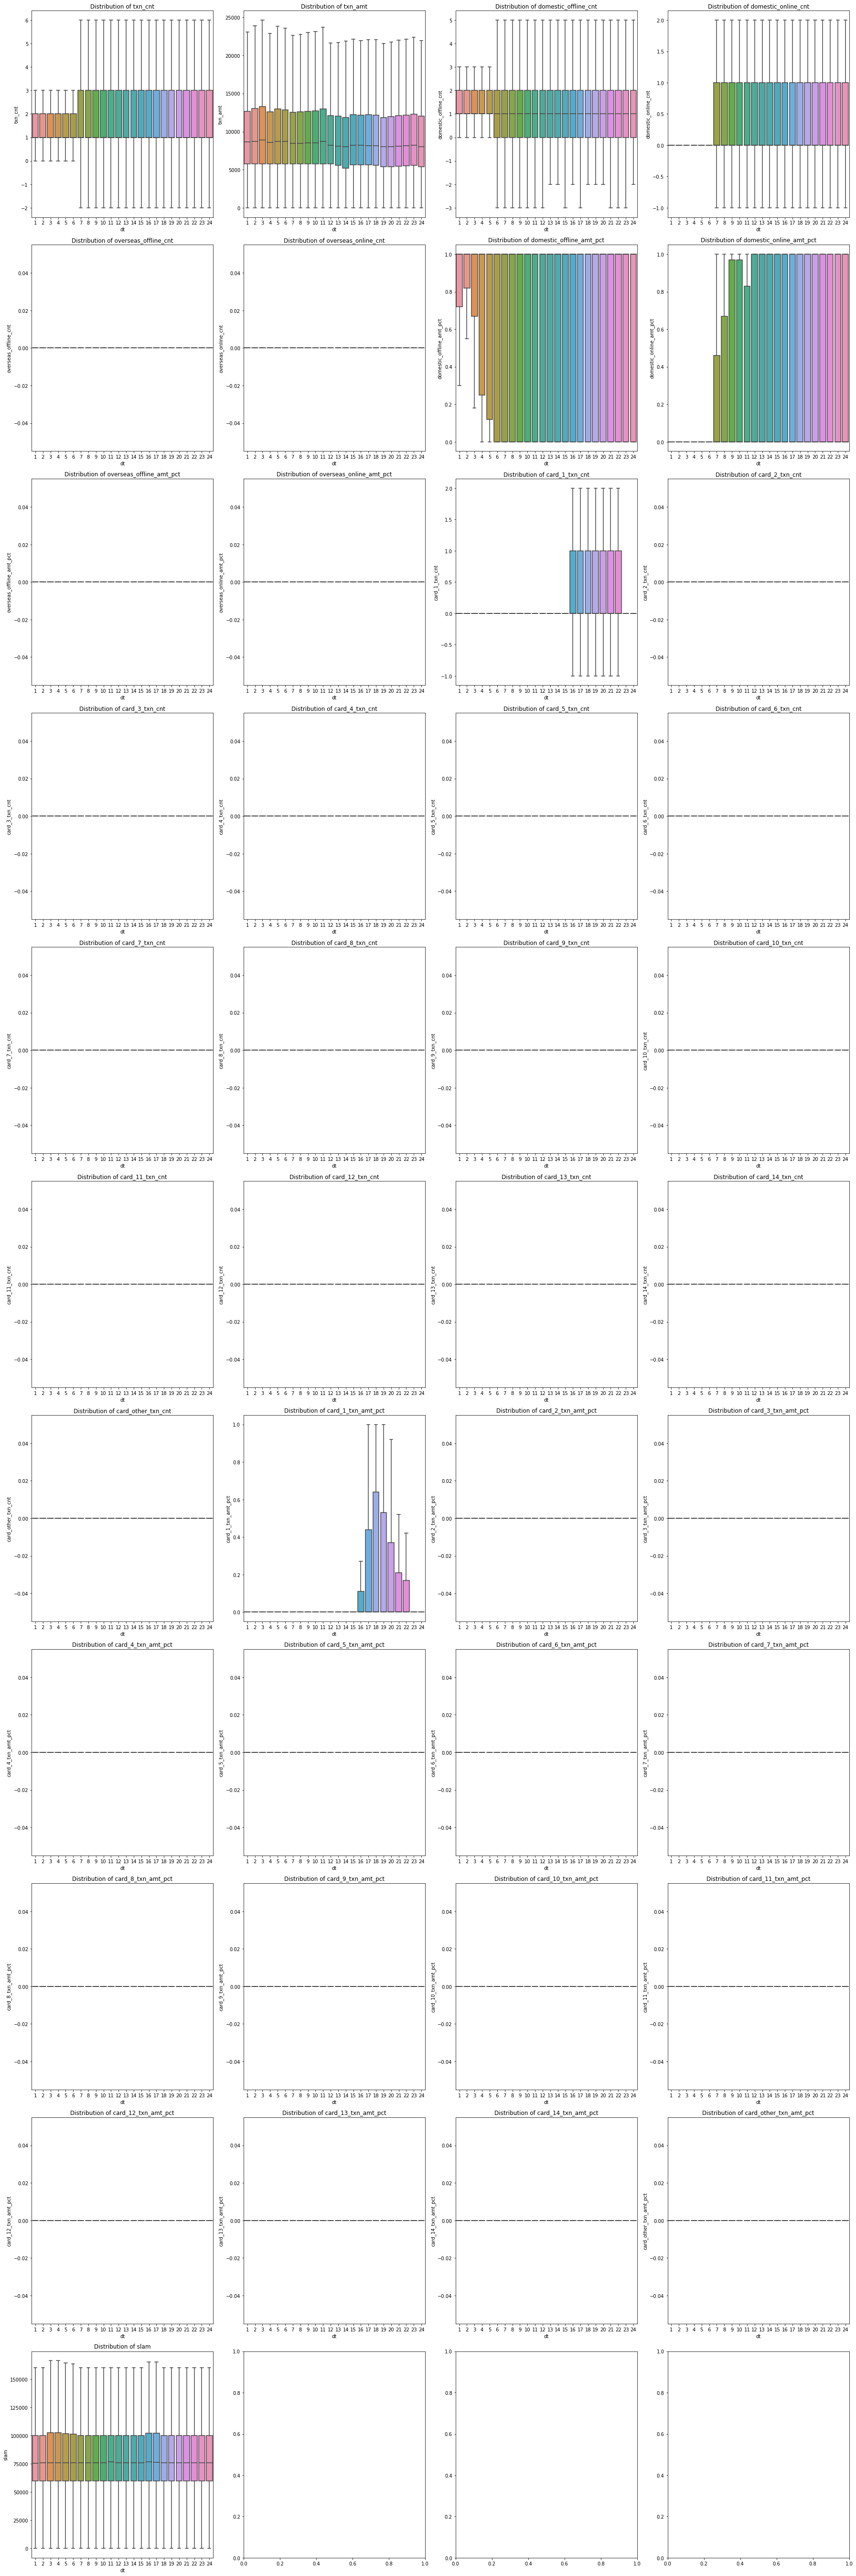

In [61]:
plot_box_single_attr('dt', showfliers=False)

41it [01:26,  2.12s/it]


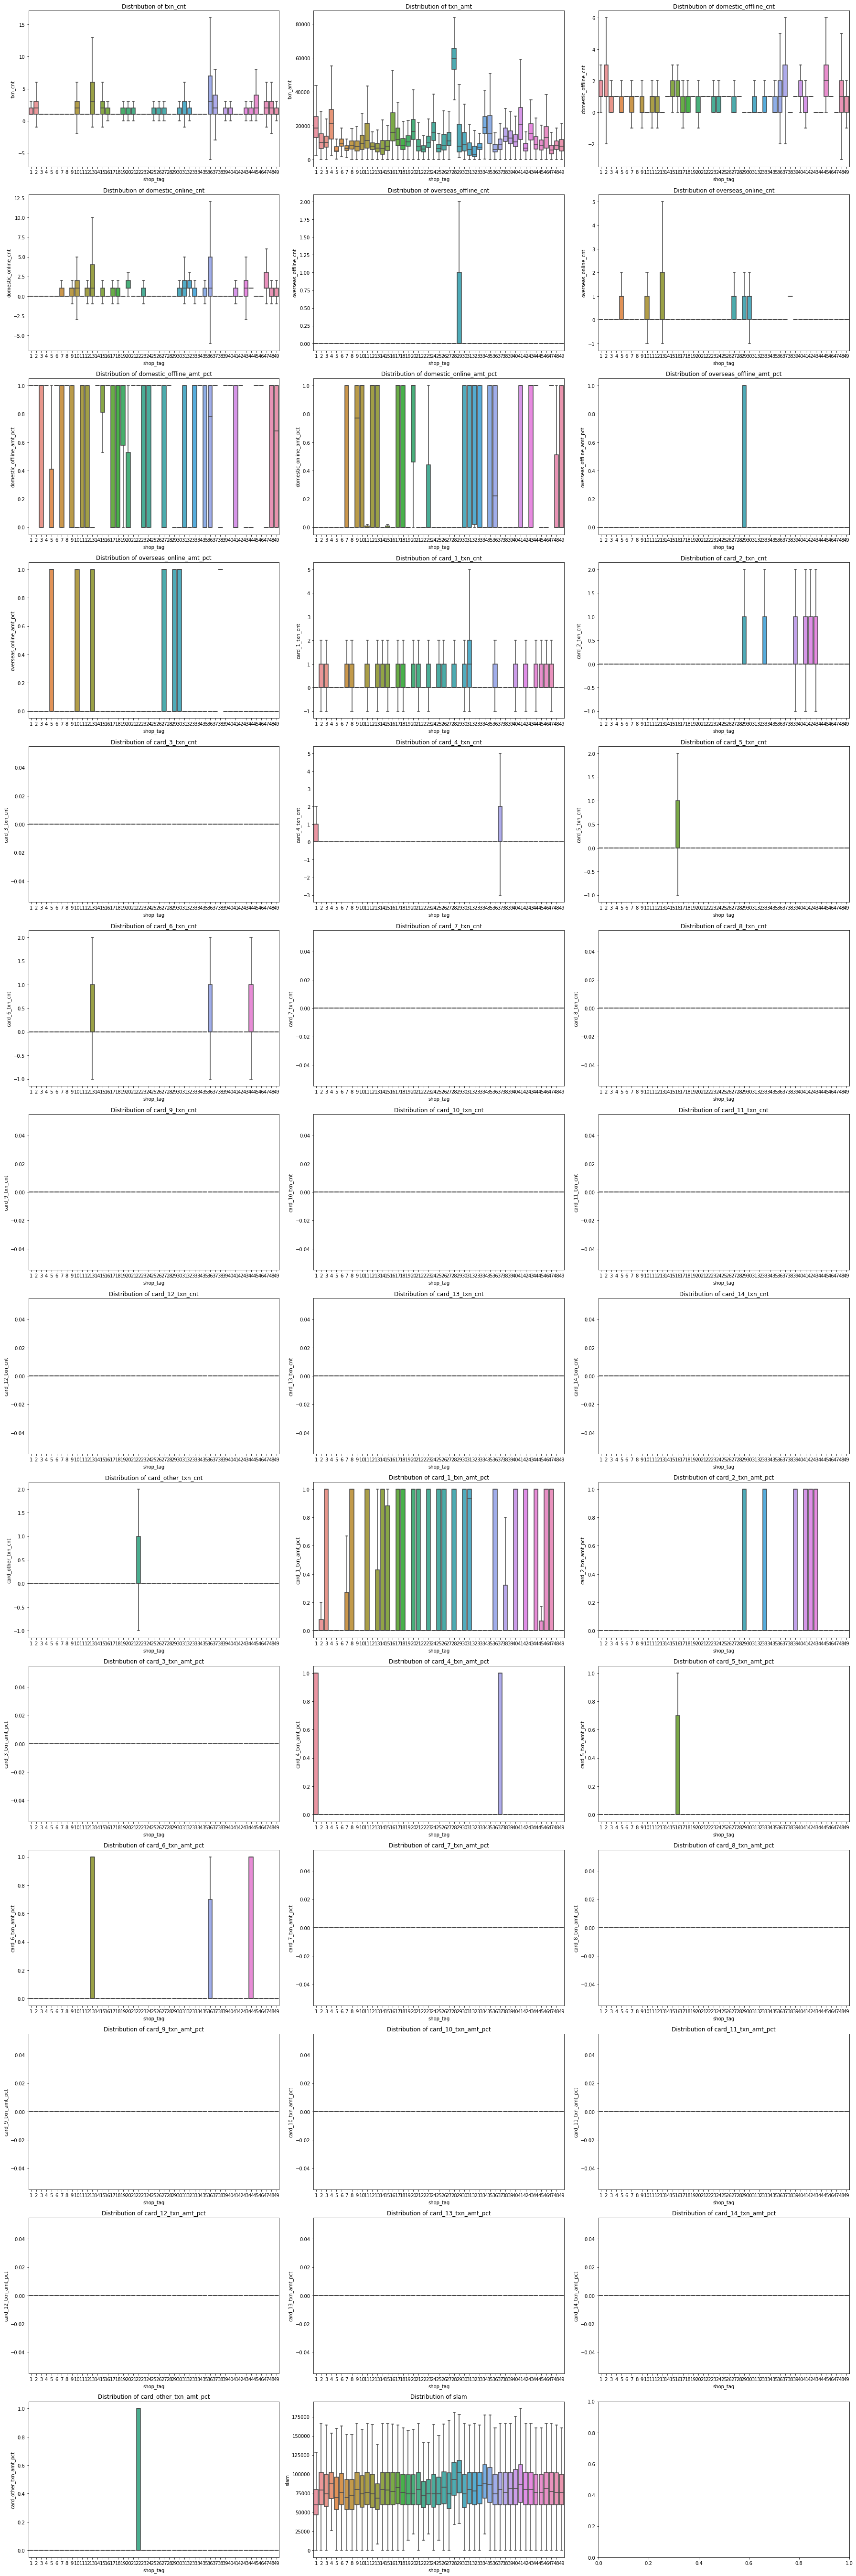

In [64]:
plot_box_single_attr('shop_tag', showfliers=False, n_cols=3)

41it [01:01,  1.49s/it]


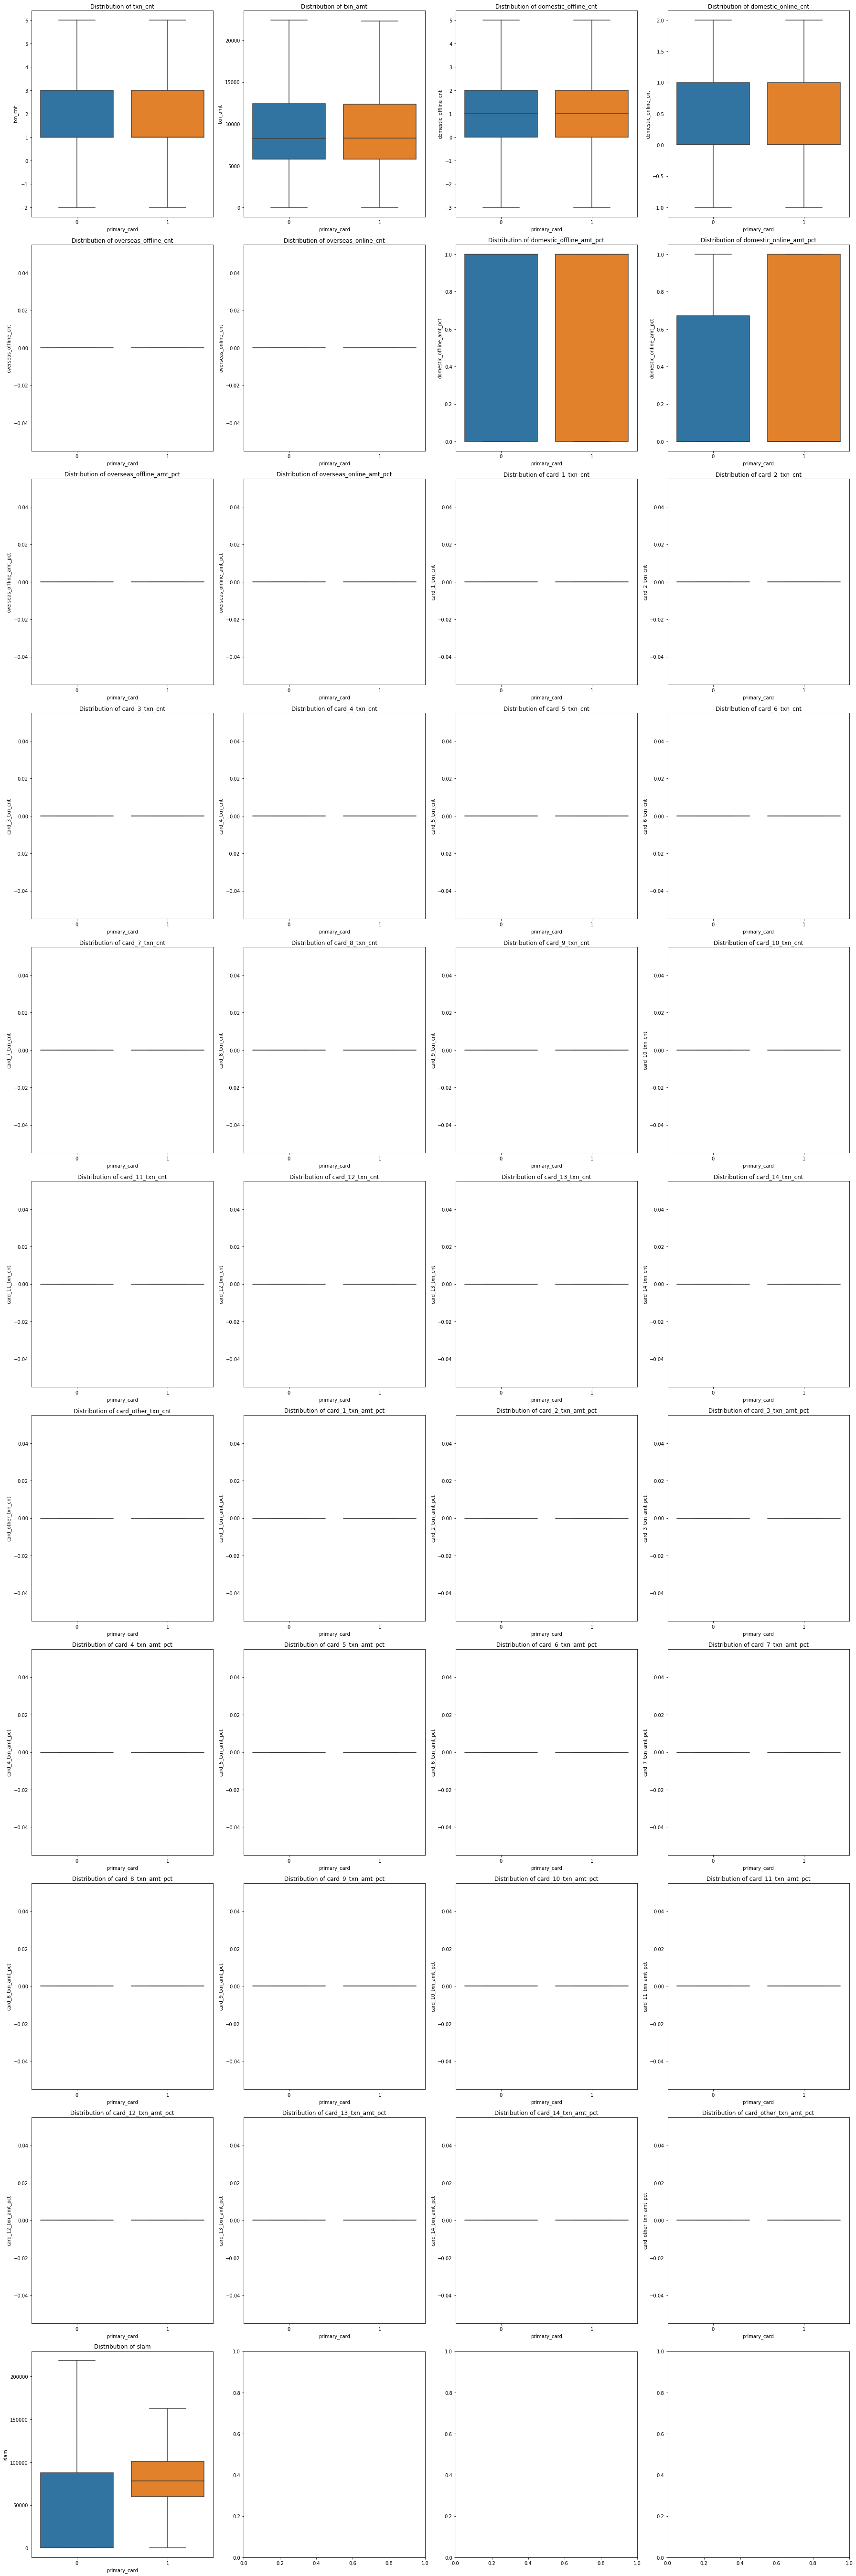

In [65]:
# Other
plot_box_single_attr('primary_card', showfliers=False)

19it [00:31,  1.64s/it]
19it [00:43,  2.29s/it]
19it [00:32,  1.69s/it]


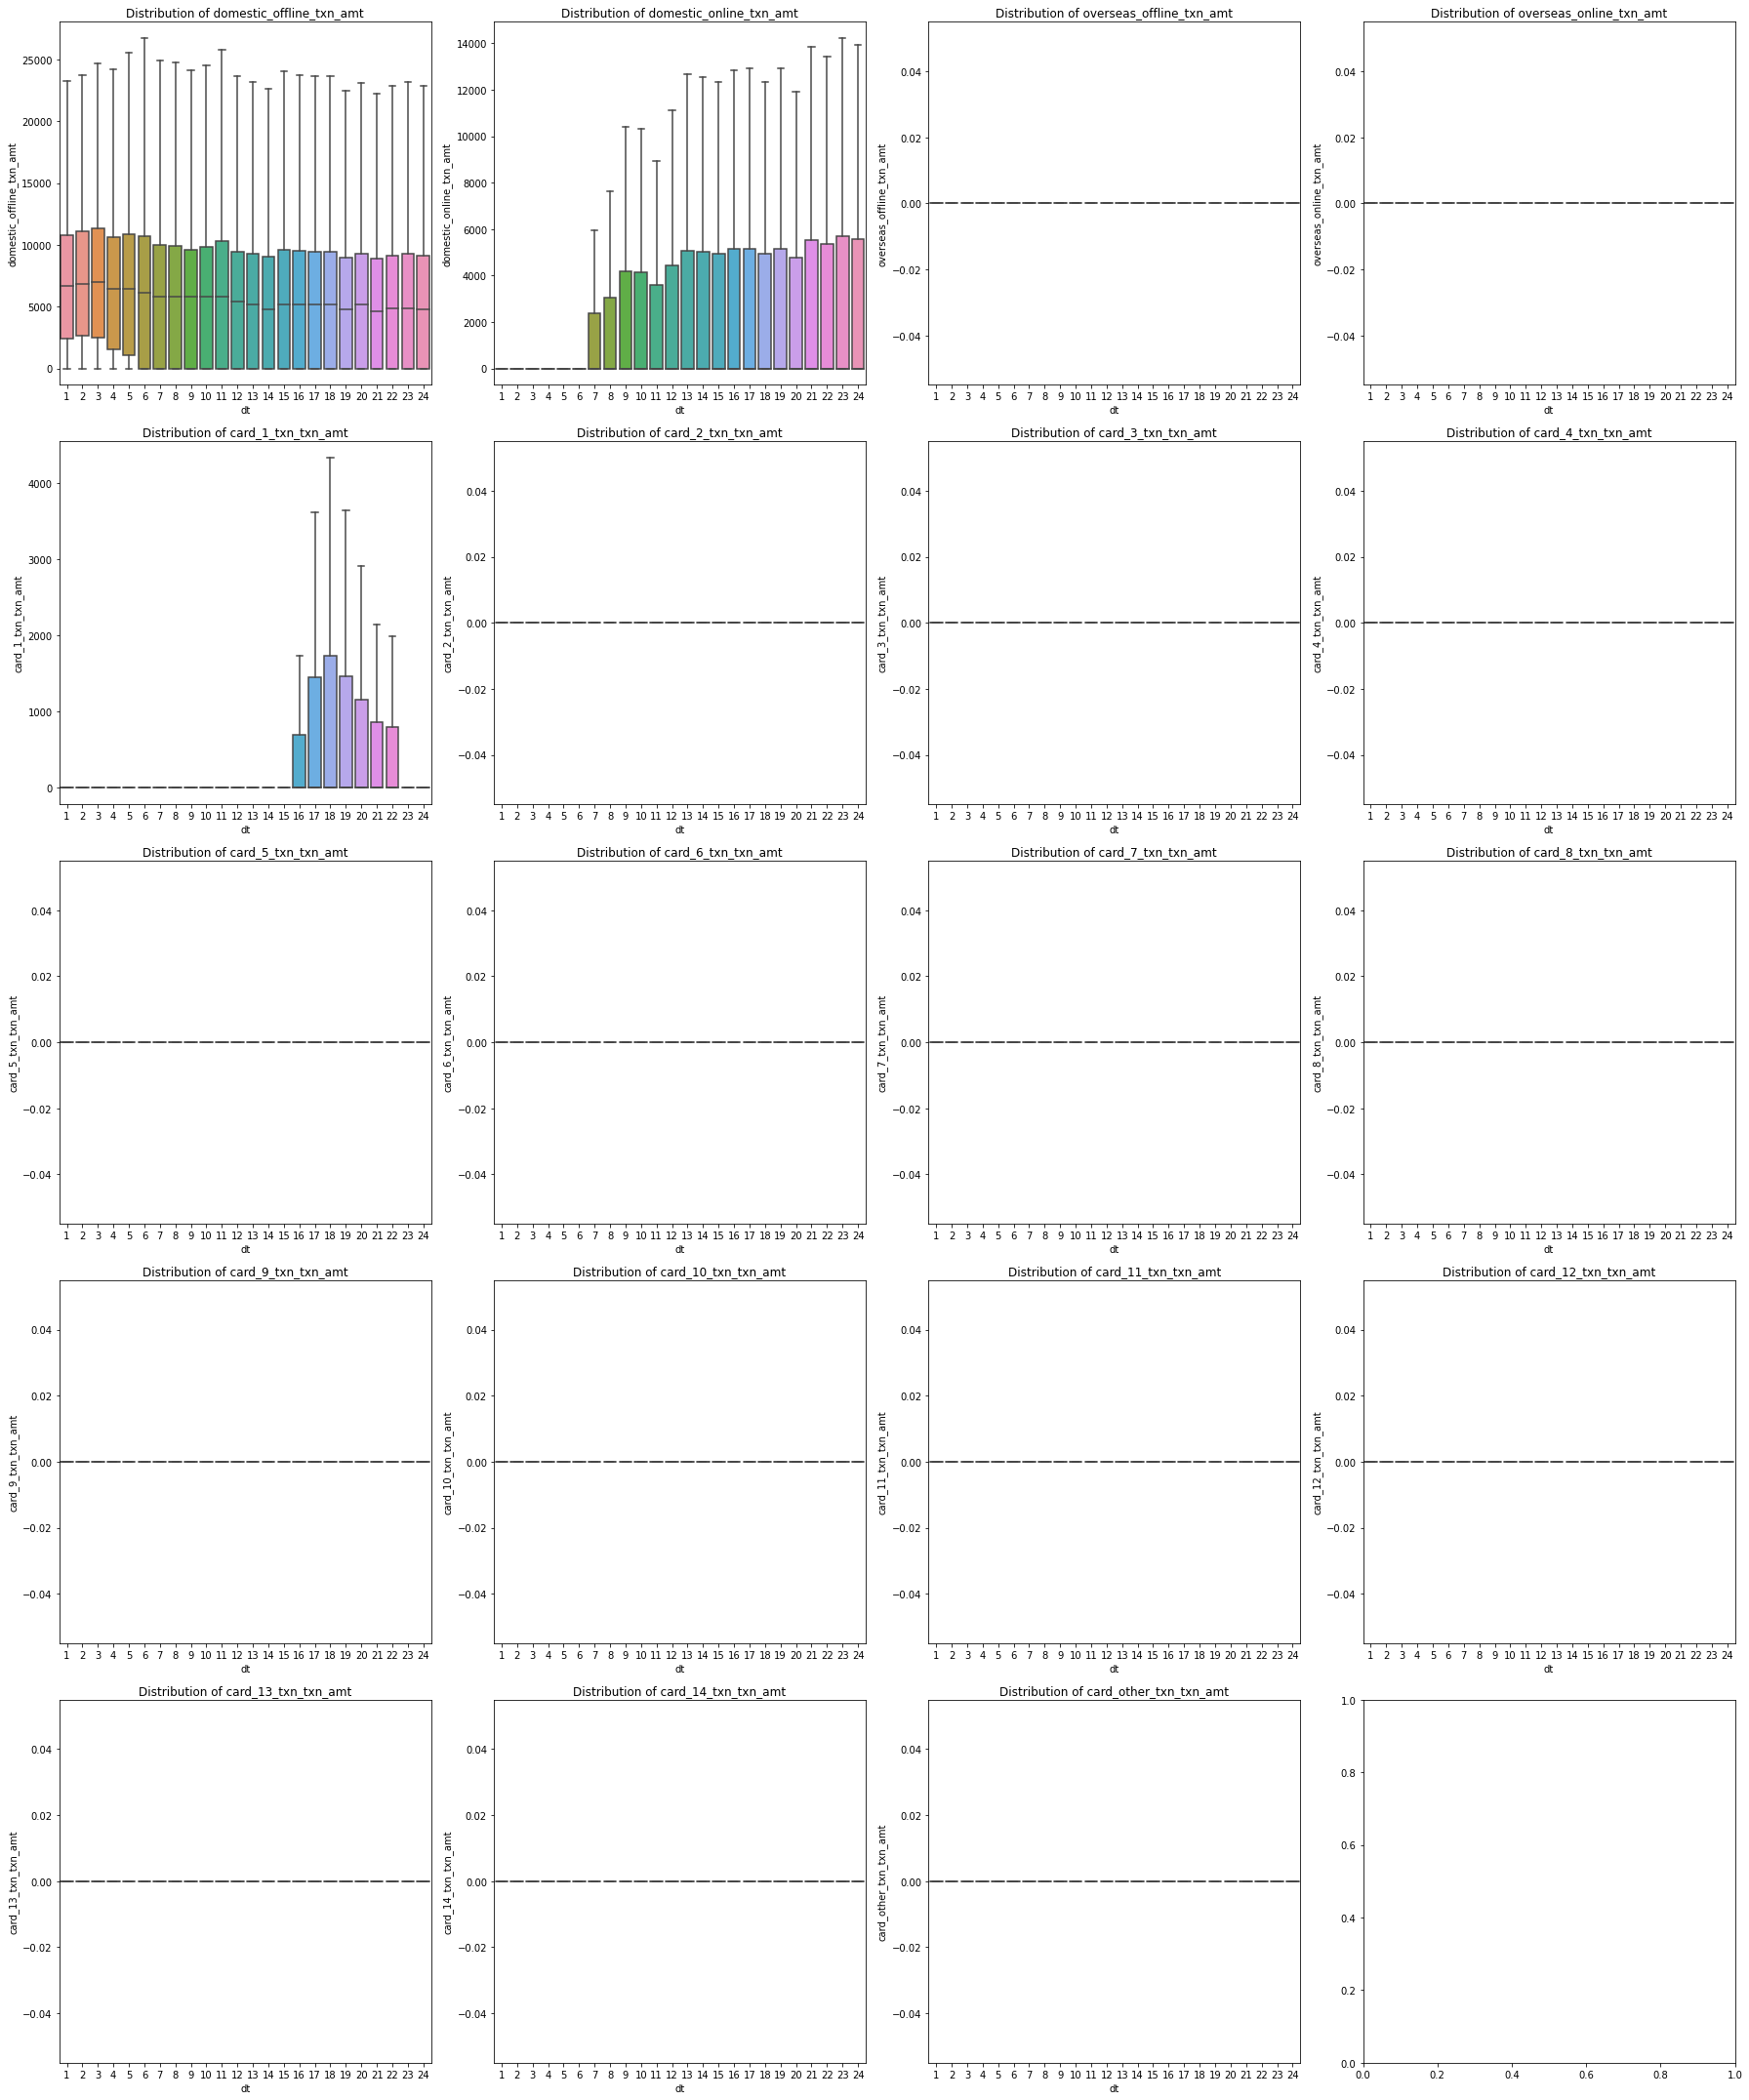

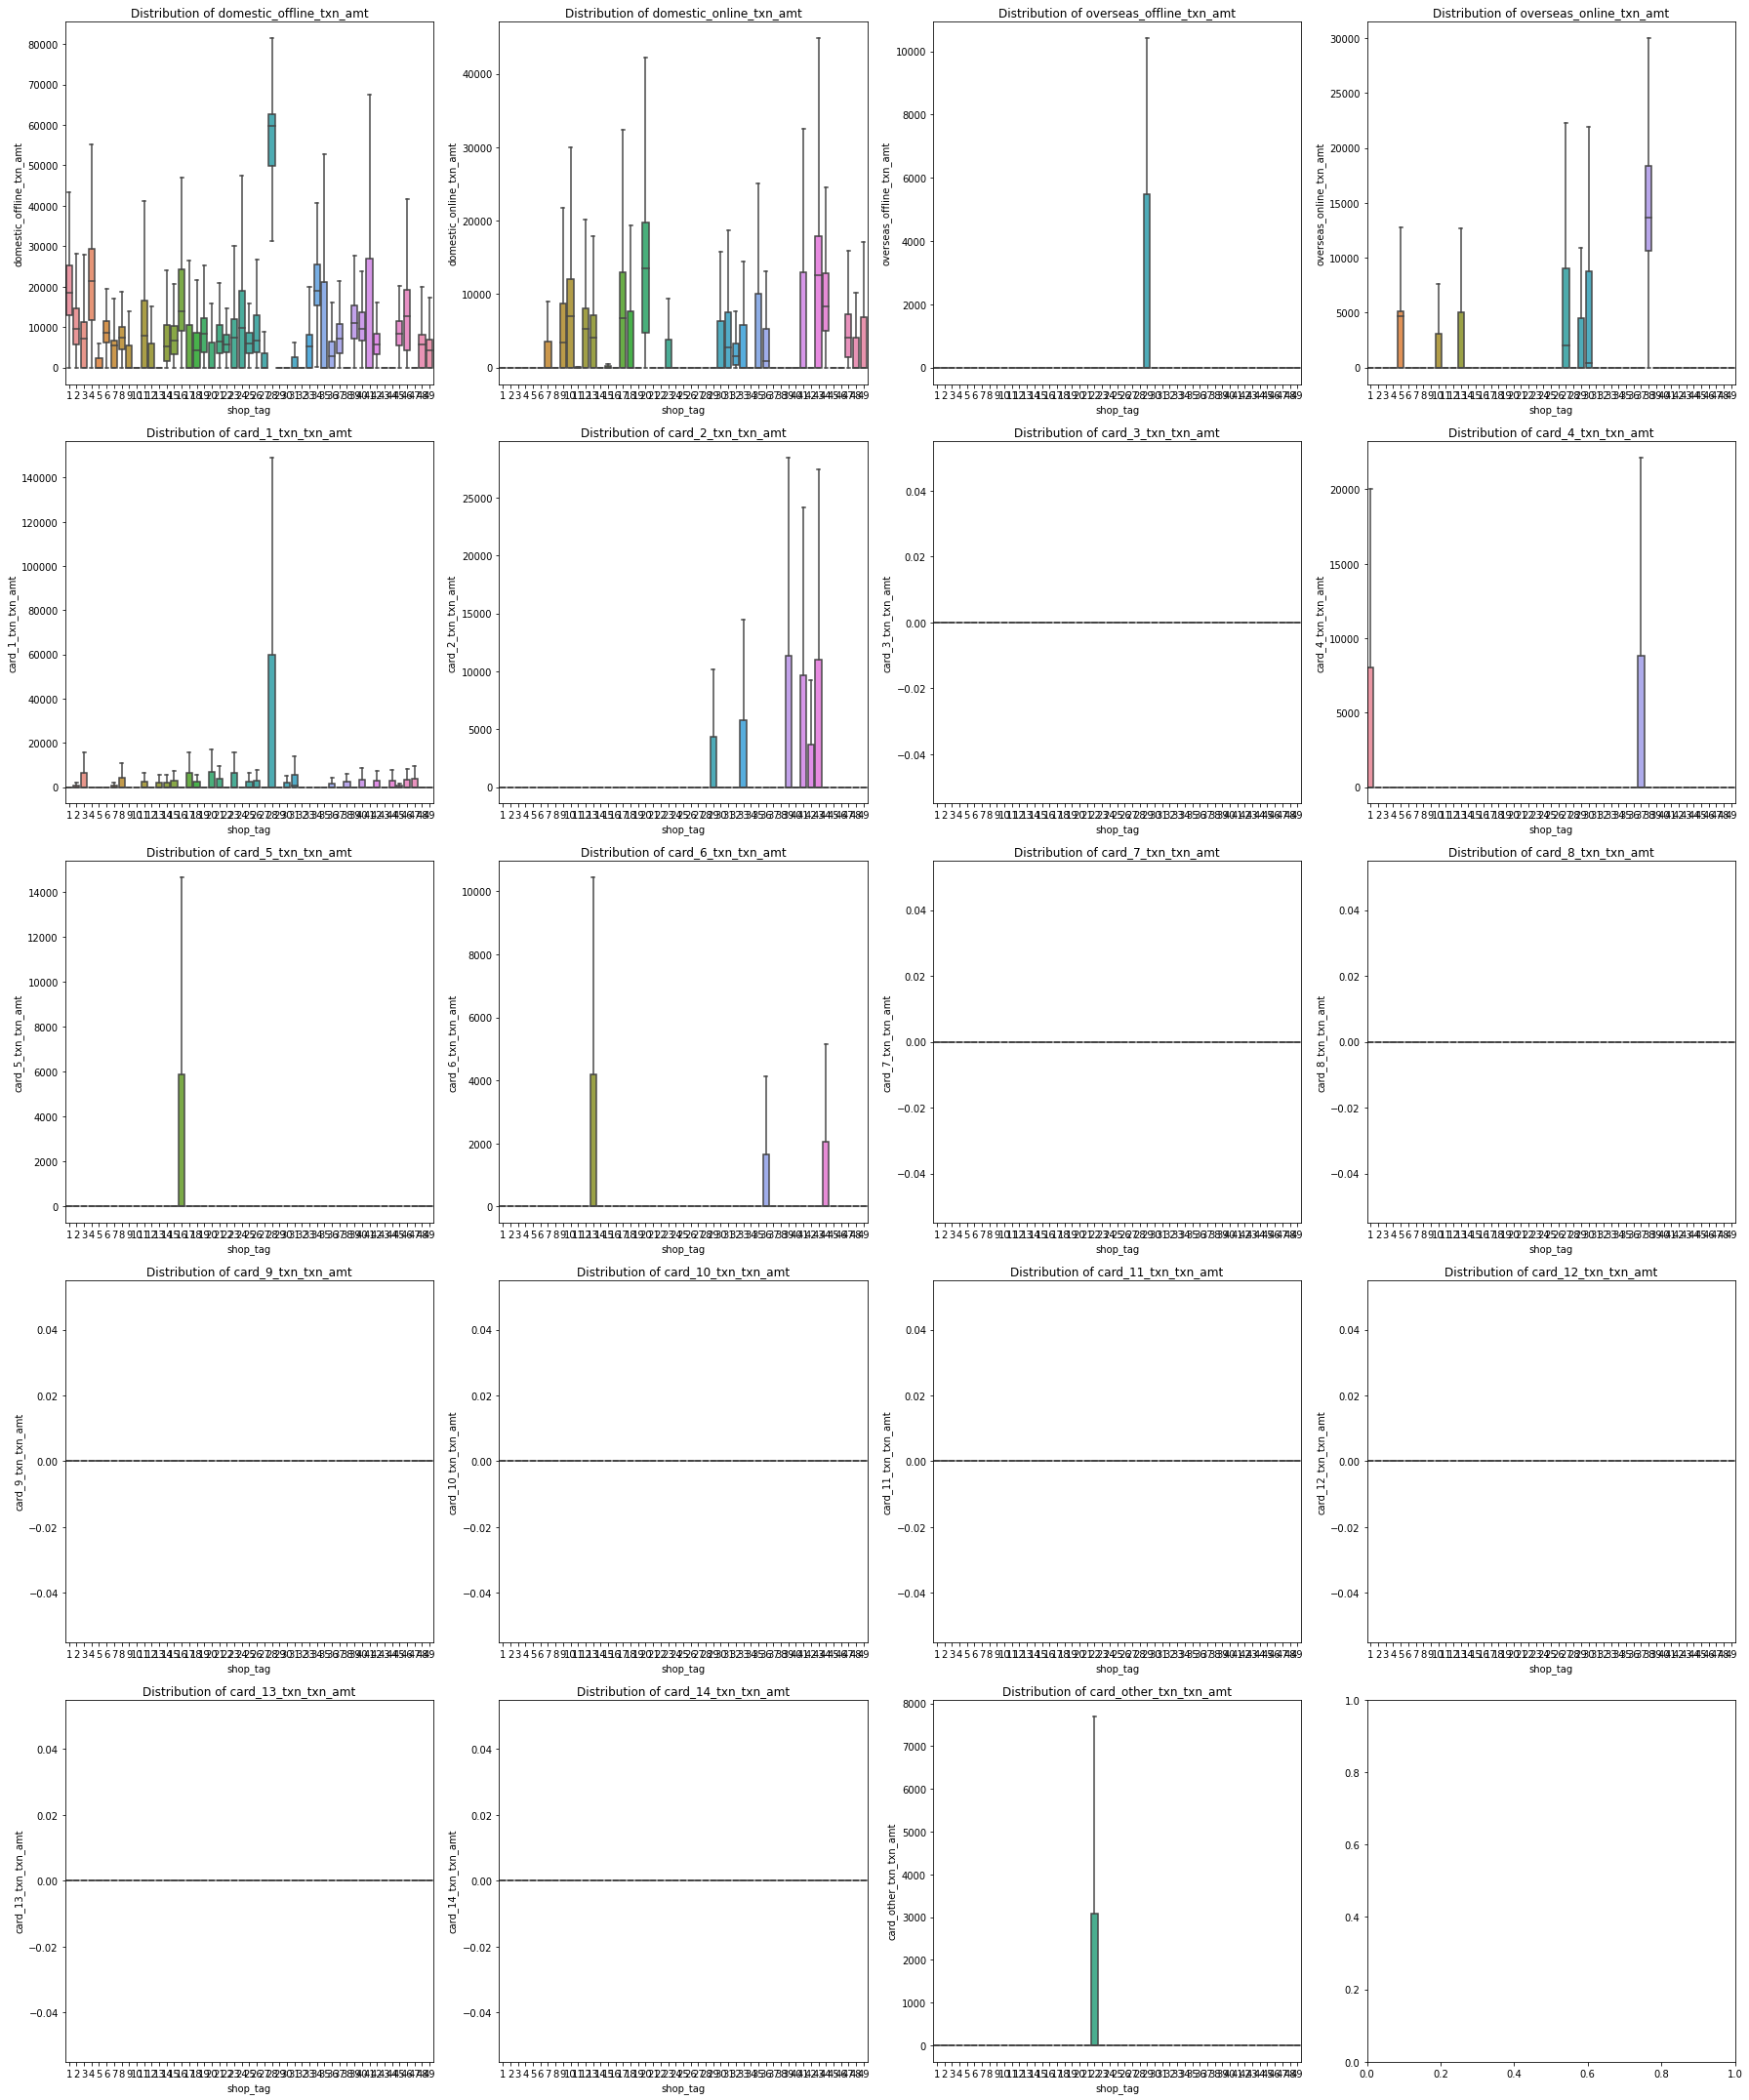

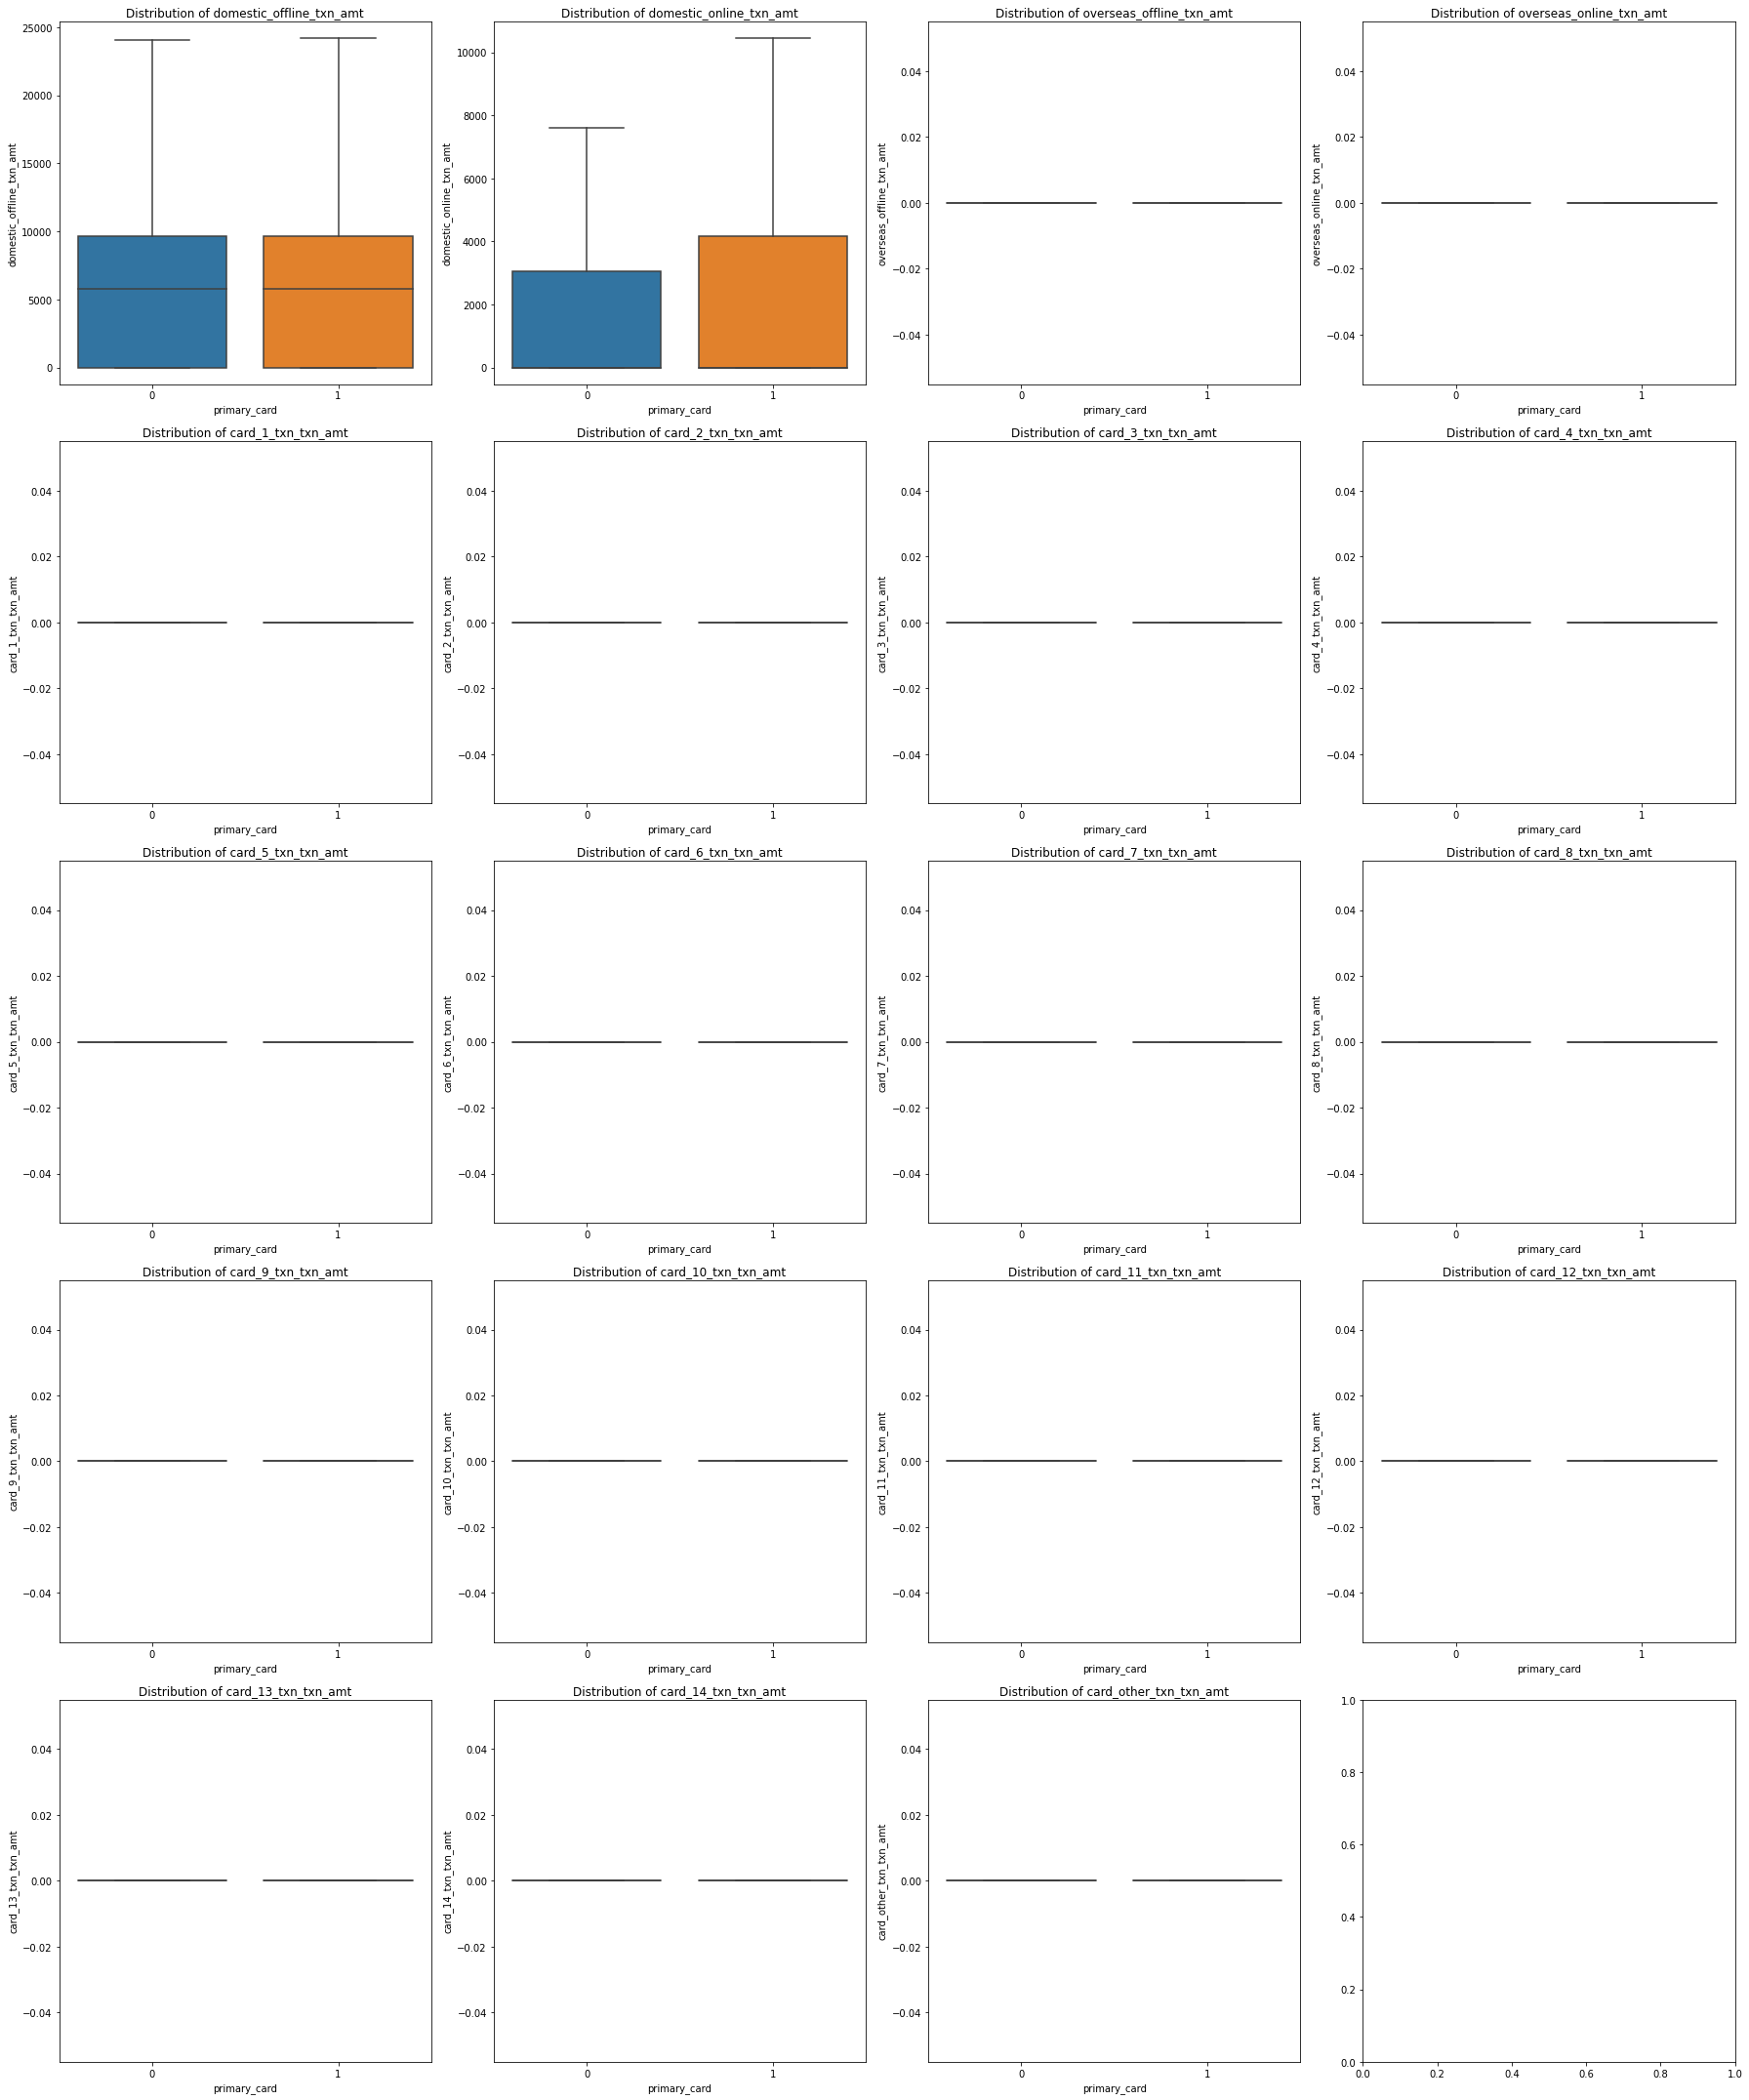

In [5]:
# For pct columns in txn_amt representation 
df = pd.read_parquet(DATA_PATH_TXN_AMTS)
for col in ['dt', 'shop_tag', 'primary_card']:
    # Exclude `chid`
    plot_box_single_attr(col, showfliers=False)

### *Sptial Dependency among `shop_tag`s*
This is motivated by the concept of **association rules**, potentially helpful to indicate one transaction on the specified `shop_tag` based on the others. Also, this analysis won't limit target `shop_tag`s to legitimate ones; instead, all of the `shop_tag`s will be explored to see if they can be put into feature set to help boost the performance.
#### Analysis and Observation 
1. 
<!-- <div class='alert alert-block alert-warning'>
    <p>.</p>
</div> -->

### *More on `txn_amt`*
After thoroughly checking the each feature meaning, I think imputing NaNs in `txn_amt` feature map is unreasonable. Because **returning for refund** is considered to be **negative** when calculating real `txn_amt`, the smallest value in `txn_amt` (*i.e.*, ~22) is possibly to be a **real negative values**. Hence, I will try to do reverse engineering, tryin to find out what's the best imputation value to use. If I fail, the imputation value can be determined by observing the change on the validation score when fixing the feature set.
#### Analysis and Observation 
1. There's a significant peak in distribution; hence, I guess imputation can be derived from values near this bin.
<!-- <div class='alert alert-block alert-warning'>
    <p>.</p>
</div> -->

In [5]:
df = pd.read_parquet(DATA_PATH_RAW, columns=PK+['txn_cnt', 'txn_amt'])
txn_cnt_val_cnts = df['txn_cnt'].value_counts().sort_values(ascending=False)
txn_cnt_val_cnts.head()

1    17820437
2     6303448
3     3010089
4     1739392
5     1069955
Name: txn_cnt, dtype: int64

In [6]:
# Extract txn_cnt with val counts greater than a threshold 
thres = 1000
txn_cnt_tmp = txn_cnt_val_cnts[txn_cnt_val_cnts > thres]
df_tmp = df[df['txn_cnt'].isin(txn_cnt_tmp.index)]

[]

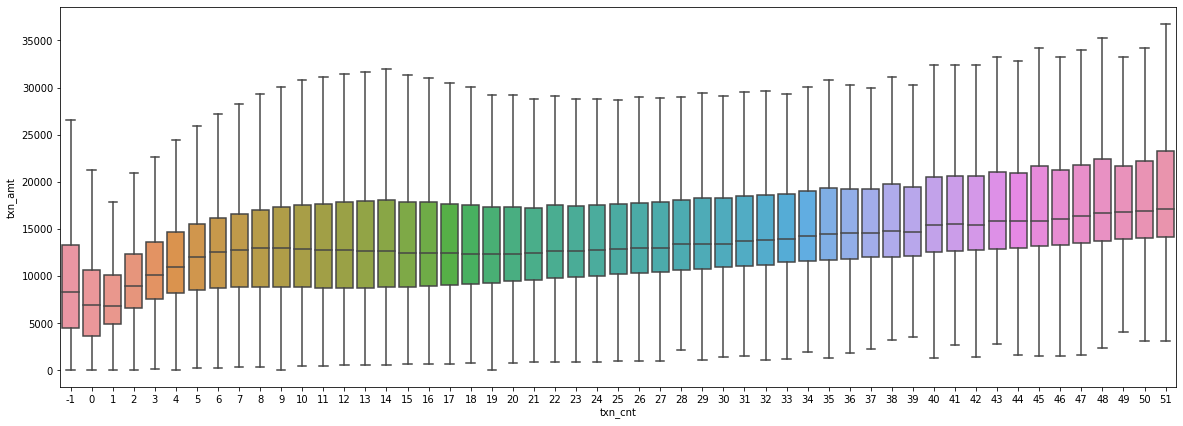

In [11]:
# Plot transaction amount distribution versus transaction count
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(x='txn_cnt', y='txn_amt', data=df_tmp, showfliers=False)
plt.plot()

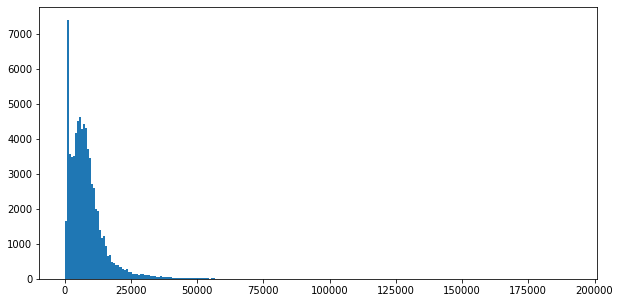

In [12]:
# Show transction amount distribution of those with transaction count 
# equal to 0
df_0cnt = df[df['txn_cnt'] == 0]
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(x=df_0cnt['txn_amt'], bins=250)
plt.show()

In [12]:
cnt_gps = df_tmp.groupby('txn_cnt')

txn_amt_modes = {}
for cnt, gp in cnt_gps:
    txn_amt_sorted = gp['txn_amt'].value_counts().sort_values(ascending=False)
    txn_amt_mode = (txn_amt_sorted.index[0], txn_amt_sorted.values[0])
    txn_amt_modes[cnt] = txn_amt_mode[0]

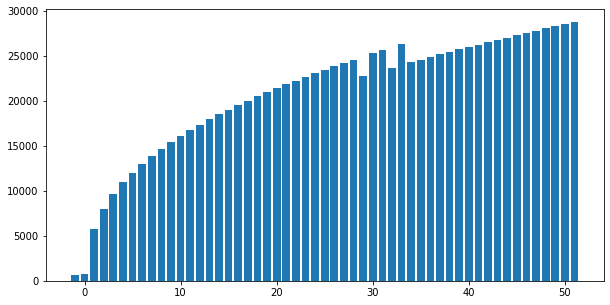

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=list(txn_amt_modes.keys()), height=list(txn_amt_modes.values()))
plt.show()

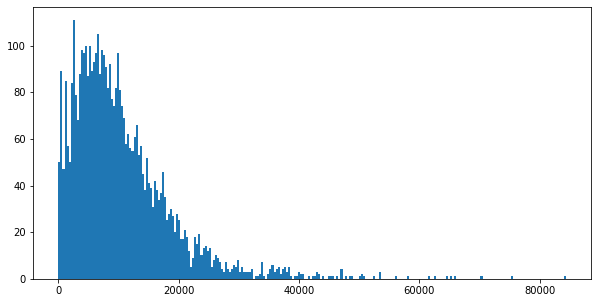

Min txn_amt 22.37085105979261 | Max 84338.24886919487


In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(x=df_neg_cnt['txn_amt'], bins=250)
plt.show()
print(f"Min txn_amt {df_neg_cnt['txn_amt'].min()} | Max {df_neg_cnt['txn_amt'].max()}")

In [ ]:
# Observe most frequent bins
df_ = df[df['txn_cnt'] == 0]  
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(x=df_['txn_amt'], bins=250)
plt.show()

In [ ]:
# Calculate imputed value using weighte sum of top 2 frequent values 
df_['txn_amt'].value_counts().sort_values()   
# imput = 1332.986072 * 2315 / (3108 + 2315) + 797.165663 * 3108 / (3108 + 2315)

### *Anomaly Analysis*
Clients with **anomaly feature values** in some of the numeric columns might probably reveal their transaction behavior, so I want to analyze them and fuse the findings into the modeling process.
#### Analysis and Observation 
1. 
<!-- <div class='alert alert-block alert-warning'>
    <p>.</p>
</div> -->

### *Correlation Coefficient* 
To better understand simple numeric feature interaction, correlation is a great direction to start.
#### Analysis and Observation 
1. 
<!-- <div class='alert alert-block alert-warning'>
    <p>.</p>
</div> -->

### *Percentage-Related Features*
Because the percentage representation of features related to **transaction channels** and **card transaction information** will make feature meaning obscure, making model hard to learn. Hence, I decide to recover the meaning of **transaction amount** (*i.e.*, `txn_amt`). And, I redo the zero value analysis to make further analysis more clear, helping me think about how to further select the raw feature to use in the next feature engineering process.

In [2]:
# Prepare raw data 
df = pd.read_parquet(DATA_PATH_RAW)
df.head(1)

dt      chid  shop_tag  txn_cnt      txn_amt  domestic_offline_cnt  \
0   1  10321418        45        3  3891.965283                     3   

   domestic_online_cnt  overseas_offline_cnt  overseas_online_cnt  \
0                    0                     0                    0   

   domestic_offline_amt_pct  domestic_online_amt_pct  \
0                       1.0                      0.0   

   overseas_offline_amt_pct  overseas_online_amt_pct  card_1_txn_cnt  \
0                       0.0                      0.0               0   

   card_2_txn_cnt  card_3_txn_cnt  card_4_txn_cnt  card_5_txn_cnt  \
0               0               0               3               0   

   card_6_txn_cnt  card_7_txn_cnt  card_8_txn_cnt  card_9_txn_cnt  \
0               0               0               0               0   

   card_10_txn_cnt  card_11_txn_cnt  card_12_txn_cnt  card_13_txn_cnt  \
0                0                0                0                0   

   card_14_txn_cnt  card_other_txn_cnt  card_1_txn_amt_pct  \
0                0                   0                 0.0   

   card_2_txn_amt_pct  card_3_txn_amt_pct  card_4_txn_amt_pct  \
0                 0.0                 0.0                 1.0   

   card_5_txn_amt_pct  card_6_txn_amt_pct  card_7_txn_amt_pct  \
0                 0.0                 0.0                 0.0   

   card_8_txn_amt_pct  card_9_txn_amt_pct  card_10_txn_amt_pct  \
0                 0.0                 0.0                  0.0   

   card_11_txn_amt_pct  card_12_txn_amt_pct  card_13_txn_amt_pct  \
0                  0.0                  0.0                  0.0   

   card_14_txn_amt_pct  card_other_txn_amt_pct  masts  educd  trdtp  naty  \
0                  0.0                     0.0      1      4      5     1   

   poscd  cuorg          slam  gender_code  age  primary_card  
0     99     30  95982.822967            1    4             1

In [3]:
# Get ratio of zero values in each features (same as analysis 1-4)
df_zero_ratios = pd.DataFrame(columns=['feature', 'zero_ratio'])
for col in COLS:
    series = df[col]
    zero_ratio = { 
        'feature': col,
        'zero_ratio': (series == 0).sum() / N_LINES
    }
    df_zero_ratios = df_zero_ratios.append(zero_ratio, ignore_index=True)
    del series
df_zero_ratios.sort_values(by=['zero_ratio'], ascending=False, inplace=True)
df_zero_ratios.T

26                   41               25  \
feature     card_14_txn_cnt  card_14_txn_amt_pct  card_13_txn_cnt   
zero_ratio          0.99529             0.995281          0.99438   

                             40                    7   \
feature     card_13_txn_amt_pct  overseas_offline_cnt   
zero_ratio             0.994359                0.9892   

                                  11               24                   39  \
feature     overseas_offline_amt_pct  card_12_txn_cnt  card_12_txn_amt_pct   
zero_ratio                  0.989199         0.986759             0.986731   

                        21                  36               23  \
feature     card_9_txn_cnt  card_9_txn_amt_pct  card_11_txn_cnt   
zero_ratio        0.986271            0.986231         0.985949   

                             38              19                  34  \
feature     card_11_txn_amt_pct  card_7_txn_cnt  card_7_txn_amt_pct   
zero_ratio             0.985931        0.981017            0.980985   

                        17                  32              15  \
feature     card_5_txn_cnt  card_5_txn_amt_pct  card_3_txn_cnt   
zero_ratio        0.969041            0.968985        0.968922   

                            30              20                  35  \
feature     card_3_txn_amt_pct  card_8_txn_cnt  card_8_txn_amt_pct   
zero_ratio            0.968843        0.964519            0.964479   

                         22                   37                       12  \
feature     card_10_txn_cnt  card_10_txn_amt_pct  overseas_online_amt_pct   
zero_ratio         0.960937             0.960882                 0.926737   

                             8                   27                      42  \
feature     overseas_online_cnt  card_other_txn_cnt  card_other_txn_amt_pct   
zero_ratio             0.926725            0.892597                 0.89242   

                        18                  33              14  \
feature     card_6_txn_cnt  card_6_txn_amt_pct  card_2_txn_cnt   
zero_ratio        0.872408            0.872008        0.827566   

                            29              16                  31  \
feature     card_2_txn_amt_pct  card_4_txn_cnt  card_4_txn_amt_pct   
zero_ratio             0.82718        0.817083            0.816714   

                        13                  28                   6   \
feature     card_1_txn_cnt  card_1_txn_amt_pct  domestic_online_cnt   
zero_ratio        0.762479            0.762092             0.676799   

                                 10           50                    5   \
feature     domestic_online_amt_pct  gender_code  domestic_offline_cnt   
zero_ratio                 0.675423     0.544541              0.328627   

                                  9             52        49        51  \
feature     domestic_offline_amt_pct  primary_card      slam       age   
zero_ratio                  0.327867      0.083689  0.053067  0.012787   

                  3         45        44     43    46     47     48    1   \
feature      txn_cnt     trdtp     educd  masts  naty  poscd  cuorg  chid   
zero_ratio  0.002242  0.000013  0.000001    0.0   0.0    0.0    0.0   0.0   

                 4         2    0   
feature     txn_amt  shop_tag   dt  
zero_ratio      0.0       0.0  0.0

In [ ]:
# Convert percentage representation to 'txn_amt' representation 
pct_cols = [col for col in df.columns if 'pct' in col]
txn_amt_cols = [col.replace('amt_pct', 'txn_amt') for col in pct_cols]

txn_amts = df[pct_cols].values * np.expand_dims(df['txn_amt'].values, axis=1)
df_txn_amts = pd.DataFrame(txn_amts, columns=txn_amt_cols)
df_txn_amts = pd.concat([df[PK], df_txn_amts], axis=1)
df_txn_amts.to_parquet(DATA_PATH_RAW, index=False)
df_txn_amts.head()

In [2]:
# Observe basic description of these converted features
df = pd.read_parquet(DATA_PATH_RAW)
df.describe()

dt          chid      shop_tag  domestic_offline_txn_amt  \
count  3.297565e+07  3.297565e+07  3.297565e+07              3.297565e+07   
mean   1.349221e+01  1.025032e+07  2.792852e+01             2.012532e+107   
std    6.750148e+00  1.443259e+05  1.536785e+01             1.155685e+111   
min    1.000000e+00  1.000000e+07  1.000000e+00              0.000000e+00   
25%    8.000000e+00  1.012553e+07  1.500000e+01              0.000000e+00   
50%    1.400000e+01  1.025029e+07  3.200000e+01              5.767360e+03   
75%    1.900000e+01  1.037523e+07  4.100000e+01              9.653003e+03   
max    2.400000e+01  1.050000e+07  4.900000e+01             6.636455e+114   

       domestic_online_txn_amt  overseas_offline_txn_amt  \
count             3.297565e+07              3.297565e+07   
mean              3.646470e+59              8.712722e+23   
std               2.093965e+63              5.003231e+27   
min               0.000000e+00              0.000000e+00   
25%               0.000000e+00              0.000000e+00   
50%               0.000000e+00              0.000000e+00   
75%               4.084866e+03              0.000000e+00   
max               1.202447e+67              2.873077e+31   

       overseas_online_txn_amt  card_1_txn_txn_amt  card_2_txn_txn_amt  \
count             3.297565e+07        3.297565e+07        3.297565e+07   
mean              9.926491e+08        3.646470e+59        1.780418e+03   
std               5.700228e+12        2.093965e+63        6.901373e+03   
min               0.000000e+00        0.000000e+00        0.000000e+00   
25%               0.000000e+00        0.000000e+00        0.000000e+00   
50%               0.000000e+00        0.000000e+00        0.000000e+00   
75%               0.000000e+00        0.000000e+00        0.000000e+00   
max               3.273323e+16        1.202447e+67        1.925759e+07   

       card_3_txn_txn_amt  card_4_txn_txn_amt  card_5_txn_txn_amt  \
count        3.297565e+07        3.297565e+07        3.297565e+07   
mean        2.012532e+107        8.659263e+12        7.521171e+47   
std         1.155685e+111        4.972532e+16        4.318990e+51   
min          0.000000e+00        0.000000e+00        0.000000e+00   
25%          0.000000e+00        0.000000e+00        0.000000e+00   
50%          0.000000e+00        0.000000e+00        0.000000e+00   
75%          0.000000e+00        0.000000e+00        0.000000e+00   
max         6.636455e+114        2.855448e+20        2.480155e+55   

       card_6_txn_txn_amt  card_7_txn_txn_amt  card_8_txn_txn_amt  \
count        3.297565e+07        3.297565e+07        3.297565e+07   
mean         1.051243e+03        1.301021e+05        3.369943e+02   
std          3.416840e+03        7.427596e+08        1.179875e+05   
min          0.000000e+00        0.000000e+00        0.000000e+00   
25%          0.000000e+00        0.000000e+00        0.000000e+00   
50%          0.000000e+00        0.000000e+00        0.000000e+00   
75%          0.000000e+00        0.000000e+00        0.000000e+00   
max          2.349420e+05        4.265218e+12        6.774386e+08   

       card_9_txn_txn_amt  card_10_txn_txn_amt  card_11_txn_txn_amt  \
count        3.297565e+07         3.297565e+07         3.297565e+07   
mean         1.259361e+09         3.669614e+02         2.480697e+23   
std          7.231809e+12         6.125802e+04         1.424526e+27   
min          0.000000e+00         0.000000e+00         0.000000e+00   
25%          0.000000e+00         0.000000e+00         0.000000e+00   
50%          0.000000e+00         0.000000e+00         0.000000e+00   
75%          0.000000e+00         0.000000e+00         0.000000e+00   
max          4.152825e+16         2.485892e+08         8.180259e+30   

       card_12_txn_txn_amt  card_13_txn_txn_amt  card_14_txn_txn_amt  \
count         3.297565e+07         3.297565e+07         3.297565e+07   
mean          6.057365e+06         6.514506e+01         7.951570e+01   
std           3